## Notes

We are weighting based on time (more recent reports are weighted more heavily when fitting data).

We have scant data past early November, and data around that point in time is suffereing from delays in reporting.


In [1]:
import modeller
import fitter

from functions.misc import knot_fn

import casadi as ca
import numpy as np
from matplotlib import pyplot as plt
from copy import copy
import pandas as pd
from scipy.integrate import trapz, cumtrapz

## Analysis of total cases

In [2]:
def seir(t, y, p):
    return [
        -p[1]*y[0]*y[2]/sum(y[:4]),
        p[1]*y[0]*y[2]/sum(y[:4]) - p[2]*y[1],
        p[2]*y[1] - p[0]*y[2],
        p[0]*y[2],
    ]

In [3]:
cases = pd.read_csv("data/samoa_cases.csv", header=0, parse_dates=["Date"], dayfirst=True)
raw_times = cases["Date"].to_numpy()
raw_times = [(t-raw_times[0])/np.timedelta64(1,'D') for t in raw_times] # convert to days since first timestamp
raw_data = cases['Cases'].to_numpy()
raw_cumdata = np.cumsum(raw_data)

In [4]:
start = 1
clip = 5
times = raw_times[start:(-clip if clip else None)]
data = raw_data[start:(-clip if clip else None)]
cumdata = raw_cumdata[start:(-clip if clip else None)]

In [5]:
additional_times = [33,35,56,60,68, 75,83,86,87,89,90,91,92, 93,94,95, 96,97, 98]
additional_cumdata = [28,36,169,314,513, 716,1174,1644,1797,2194,2437,2686,2936, 3149,3357,3530, 3728,3881, 4052]

# times = times + additional_times
# cumdata = np.concatenate([cumdata,additional_cumdata])
times = np.array(additional_times)
cumdata = np.array(additional_cumdata)

Text(0.5, 0, 'Days after 28 August 2019')

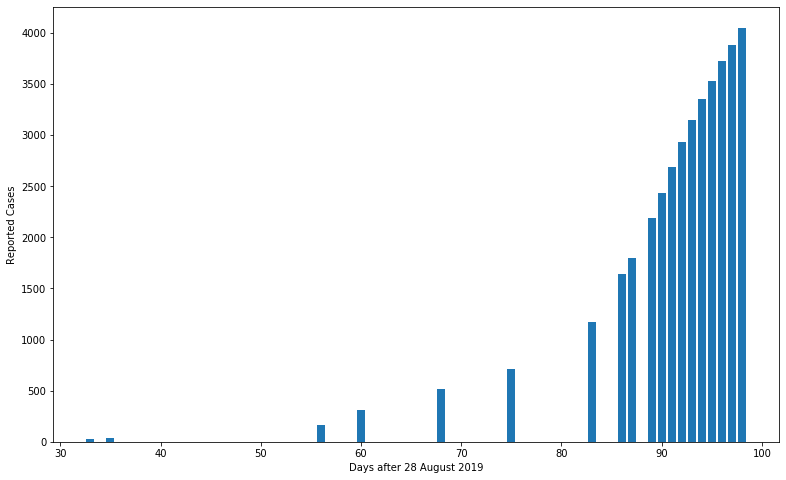

In [6]:
plt.figure(figsize=[13,8])
plt.bar(times, cumdata)
plt.ylabel("Reported Cases")
plt.xlabel("Days after 28 August 2019")

Text(0.5, 0, 'Days after 28 August 2019')

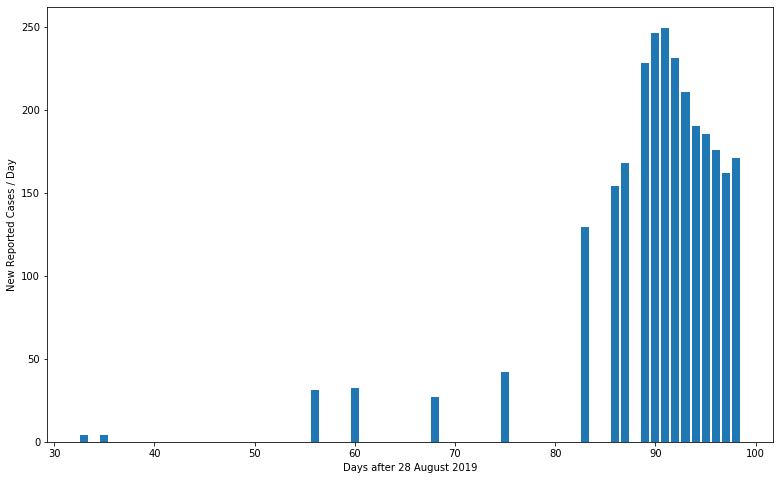

In [7]:
plt.figure(figsize=[13,8])
plt.bar(times, np.gradient(cumdata, times))
plt.ylabel("New Reported Cases / Day")
plt.xlabel("Days after 28 August 2019")

In [8]:
def cumE(t, p, e):
    dt = ca.diff(t)
    xm = (e[:-1]+e[1:])/2
    return p[2]*ca.vcat([0, ca.cumsum(xm*dt)])

In [9]:
data_pd = np.array([[i] for i in cumdata])
p0 = [1/8, 1, 1/8]
config = {
    "grid_size": 100,
    "basis_number": 24,
    "model_form": {
        "state": 4,
        "parameters": 3
    },
    "time_span": [times[0], 150],
    "knot_function": None,
    "model": seir,
    "dataset": {"y": data_pd, "t": np.array(times)},
    "observation_model": [cumE],
    "observation_vector": [[1]],
    "weightings":[
        [1]*4,
        np.sqrt(times/np.mean(times))
    ],
    "regularisation_value": copy(p0),
}

In [10]:
model = modeller.Model(config)
config['regularisation_value'][1] = model.ps[1]
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}
ipopt_opts = {
    'ipopt': {
        'print_level': 5,
        'print_frequency_iter': 10,
        
    }
}

solver = ca.nlpsol('solver', 'ipopt', solver_setup, ipopt_opts)

In [11]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)


In [12]:
c0 = [max(cumdata)*np.ones(config['basis_number']) for _ in range(4)]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*4) + [0]*len(config['regularisation_value'])
alpha = 1e2

In [13]:
pure_solve = solver(x0=x0, p=[0, 0], lbx=lbx, lbg=0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1496
Number of nonzeros in Lagrangian Hessian.............:     1775

Total number of variables............................:       99
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

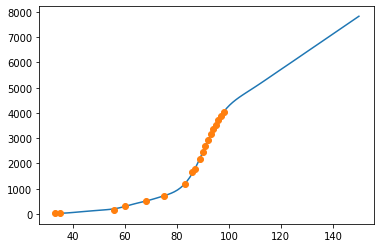

In [14]:
pure_xs = getx(pure_solve['x'])
pure_ps = getp(pure_solve['x'])
plt.plot(model.observation_times, pure_ps[2]*cumtrapz(pure_xs[1].toarray().flatten(),model.observation_times, initial=0))
plt.plot(times, cumdata, 'o')

In [15]:
lbg = [0]*len(model.observation_times)*config['model_form']['state']
ubg = [140000]*len(model.observation_times)*config['model_form']['state']
# lbg[0] = 150000

In [16]:
prange = np.logspace(-6, 6, num=100)
sols = []
xguess = x0
for p in prange:
    solve_opts = {
        'x0': xguess,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': lbg,
        'ubg': ubg
    }
    print(f"Solving for p={p}")
    sols.append(solver(**solve_opts))
    xguess = np.array(sols[-1]['x']).flatten()

Solving for p=1e-06
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1496
Number of nonzeros in Lagrangian Hessian.............:     1775

Total number of variables............................:       99
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      400
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      400
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du

 480  1.1672309e+02 0.00e+00 3.65e+03  -2.5 4.63e+01    -  1.00e+00 1.00e+00f  1
 490  1.1668563e+02 0.00e+00 7.50e+03  -2.5 6.58e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.1664898e+02 0.00e+00 1.03e+04  -2.5 2.91e+02    -  1.00e+00 2.50e-01f  3
 510  1.1661303e+02 0.00e+00 8.24e+03  -2.5 1.23e+02    -  1.00e+00 5.00e-01f  2
 520  1.1657933e+02 0.00e+00 6.70e+03  -2.5 1.07e+02    -  1.00e+00 5.00e-01f  2
 530  1.1654548e+02 0.00e+00 5.31e+03  -2.5 1.88e+02    -  1.00e+00 2.50e-01f  3
 540  1.1651265e+02 0.00e+00 5.36e+03  -2.5 1.88e+02    -  1.00e+00 2.50e-01f  3
 550  1.1648220e+02 0.00e+00 9.46e+03  -2.5 6.79e+01    -  1.00e+00 1.00e+00f  1
 560  1.1645051e+02 0.00e+00 6.33e+03  -2.5 2.06e+02    -  1.00e+00 2.50e-01f  3
 570  1.1641989e+02 0.00e+00 8.31e+02  -2.5 1.93e+01    -  1.00e+00 1.00e+00f  1
 580  1.1639099e+02 0.00e+00 3.80e+03  -2.5 4.13e+01    -  1.00e+00 1.00e+00f  1
 590  1.1636298e+02 0.00e+00

   0  1.1515077e+02 0.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  1.1623857e+02 0.00e+00 3.00e+04  -1.0 1.94e+03    -  5.19e-01 3.12e-02f  6
  20  1.1980599e+02 0.00e+00 1.82e+04  -1.0 1.84e+05    -  3.00e-01 2.05e-01f  2
  30  1.1882210e+02 0.00e+00 3.19e+03  -1.0 6.31e+01    -  1.00e+00 1.00e+00f  1
  40  1.1883622e+02 0.00e+00 1.51e+03  -1.0 4.54e+01    -  1.00e+00 1.00e+00f  1
  50  1.1891681e+02 0.00e+00 1.34e+04  -1.0 2.53e+02    -  1.00e+00 5.00e-01f  2
  60  1.1892265e+02 0.00e+00 1.11e+04  -1.0 1.20e+02    -  1.00e+00 1.00e+00f  1
  70  1.1894935e+02 0.00e+00 1.11e+04  -1.0 2.22e+02    -  1.00e+00 5.00e-01f  2
  80  1.1897658e+02 0.00e+00 1.07e+04  -1.0 1.16e+02    -  1.00e+00 1.00e+00f  1
  90  1.1901062e+02 0.00e+00 1.12e+04  -1.0 1.18e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1903514e+02 0.00e+00 8.83e+03  -1.0 1.76e+02    -  1.00e+00 5.00e-01f  2
 110  1.1906767e+02 0.00e+00

 970  1.1601833e+02 0.00e+00 4.01e+03  -2.5 6.47e+01    -  1.00e+00 5.00e-01f  2
 980  1.1599147e+02 0.00e+00 4.84e+03  -2.5 3.77e+01    -  1.00e+00 1.00e+00f  1
 990  1.1596494e+02 0.00e+00 4.89e+03  -2.5 7.15e+01    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  1.1593749e+02 0.00e+00 1.04e+03  -2.5 1.70e+01    -  1.00e+00 1.00e+00f  1
1010  1.1591147e+02 0.00e+00 9.81e+02  -2.5 1.63e+01    -  1.00e+00 1.00e+00f  1
1020  1.1588660e+02 0.00e+00 2.87e+03  -2.5 5.01e+01    -  1.00e+00 5.00e-01f  2
1030  1.1586068e+02 0.00e+00 3.49e+03  -2.5 5.65e+01    -  1.00e+00 5.00e-01f  2
1040  1.1583538e+02 0.00e+00 1.73e+03  -2.5 7.11e+01    -  1.00e+00 2.50e-01f  3
1050  1.1581021e+02 0.00e+00 3.82e+03  -2.5 3.08e+01    -  1.00e+00 1.00e+00f  1
1060  1.1578473e+02 0.00e+00 2.18e+03  -2.5 2.30e+01    -  1.00e+00 1.00e+00f  1
1070  1.1576041e+02 0.00e+00 1.96e+03  -2.5 2.15e+01    -  1.00e+00 1.00e+00f  1
1080  1.1573554e+02 0.00e+00

 130  1.1918303e+02 0.00e+00 2.47e+03  -1.0 4.75e+01    -  1.00e+00 1.00e+00f  1
 140  1.1922619e+02 0.00e+00 3.87e+03  -1.0 5.82e+01    -  1.00e+00 1.00e+00f  1
 150  1.1926817e+02 0.00e+00 2.05e+03  -1.0 4.21e+01    -  1.00e+00 1.00e+00f  1
 160  1.1934031e+02 0.00e+00 1.86e+04  -1.0 2.29e+02    -  1.00e+00 5.00e-01f  2
 170  1.1936777e+02 0.00e+00 1.36e+04  -1.0 3.80e+02    -  1.00e+00 2.50e-01f  3
 180  1.1940366e+02 0.00e+00 9.61e+03  -1.0 6.29e+02    -  1.00e+00 1.25e-01f  4
 190  1.1945798e+02 0.00e+00 1.56e+04  -1.0 1.09e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.1951976e+02 0.00e+00 2.33e+04  -1.0 2.45e+02    -  1.00e+00 5.00e-01f  2
 210  1.1955810e+02 0.00e+00 2.10e+04  -1.0 2.24e+02    -  1.00e+00 5.00e-01f  2
 220  1.1961795e+02 0.00e+00 2.69e+04  -1.0 1.35e+02    -  1.00e+00 1.00e+00f  1
 230  1.1963683e+02 0.00e+00 6.39e+03  -1.0 6.51e+01    -  1.00e+00 1.00e+00f  1
 240  1.1968931e+02 0.00e+00

1070  1.1570320e+02 0.00e+00 2.59e+03  -3.8 2.51e+01    -  1.00e+00 1.00e+00f  1
1080  1.1567345e+02 0.00e+00 5.49e+03  -3.8 3.61e+01    -  1.00e+00 1.00e+00f  1
1090  1.1564081e+02 0.00e+00 9.21e+02  -3.8 1.44e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  1.1561167e+02 0.00e+00 2.73e+03  -3.8 2.46e+01    -  1.00e+00 1.00e+00f  1
1110  1.1558313e+02 0.00e+00 4.01e+03  -3.8 5.59e+01    -  1.00e+00 5.00e-01f  2
1120  1.1555341e+02 0.00e+00 2.37e+03  -3.8 2.23e+01    -  1.00e+00 1.00e+00f  1
1130  1.1552507e+02 0.00e+00 6.47e+02  -3.8 1.14e+01    -  1.00e+00 1.00e+00f  1
1140  1.1549706e+02 0.00e+00 4.92e+02  -3.8 9.77e+00    -  1.00e+00 1.00e+00f  1
1150  1.1547143e+02 0.00e+00 1.89e+03  -3.8 1.91e+01    -  1.00e+00 1.00e+00f  1
1160  1.1544530e+02 0.00e+00 1.61e+03  -3.8 1.73e+01    -  1.00e+00 1.00e+00f  1
1170  1.1542000e+02 0.00e+00 5.79e+02  -3.8 1.02e+01    -  1.00e+00 1.00e+00f  1
1180  1.1539719e+02 0.00e+00

 270  1.2007684e+02 0.00e+00 1.81e+04  -1.0 9.79e+01    -  1.00e+00 1.00e+00f  1
 280  1.2018450e+02 0.00e+00 3.12e+04  -1.0 1.31e+02    -  1.00e+00 1.00e+00f  1
 290  1.2029456e+02 0.00e+00 4.08e+04  -1.0 2.94e+02    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  1.2036361e+02 0.00e+00 3.90e+03  -1.0 5.02e+01    -  1.00e+00 1.00e+00f  1
 310  1.2047568e+02 0.00e+00 4.14e+03  -1.0 5.29e+01    -  1.00e+00 1.00e+00f  1
 320  1.2059709e+02 0.00e+00 1.35e+04  -1.0 9.58e+01    -  1.00e+00 1.00e+00f  1
 330  1.2072947e+02 0.00e+00 8.70e+03  -1.0 7.90e+01    -  1.00e+00 1.00e+00f  1
 340  1.2089826e+02 0.00e+00 4.48e+04  -1.0 3.46e+02    -  1.00e+00 5.00e-01f  2
 350  1.2102188e+02 0.00e+00 2.33e+04  -1.0 2.32e+02    -  1.00e+00 5.00e-01f  2
 360  1.2118157e+02 0.00e+00 2.56e+04  -1.0 5.29e+02    -  1.00e+00 2.50e-01f  3
 370  1.2135151e+02 0.00e+00 2.10e+04  -1.0 1.33e+02    -  1.00e+00 1.00e+00f  1
 380  1.2155464e+02 0.00e+00

1220  1.1521127e+02 0.00e+00 6.77e+02  -3.8 3.41e+01    -  1.00e+00 2.50e-01f  3
1230  1.1520931e+02 0.00e+00 1.88e+02  -3.8 4.56e+00    -  1.00e+00 1.00e+00f  1
1240  1.1520827e+02 0.00e+00 1.48e+02  -3.8 4.01e+00    -  1.00e+00 1.00e+00f  1
1250  1.1520779e+02 0.00e+00 2.37e+01  -3.8 1.59e+00    -  1.00e+00 1.00e+00h  1
1260  1.1520263e+02 0.00e+00 5.22e-02  -5.7 6.79e+03    -  8.65e-01 1.00e+00f  1
1270  1.1520153e+02 0.00e+00 3.97e+01  -8.6 4.82e+02 -10.2 6.97e-01 1.00e+00f  1
1280  1.1517713e+02 0.00e+00 3.16e+00  -8.6 1.13e+06 -15.0 5.68e-02 1.32e-02f  3
1290  1.1517630e+02 0.00e+00 1.17e+01  -8.6 1.98e+03 -12.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  1.1517121e+02 0.00e+00 2.09e+00  -8.6 1.14e+03 -11.9 1.00e+00 1.80e-01f  1
1310  1.1516966e+02 0.00e+00 1.47e+01  -8.6 8.70e+02 -11.7 1.37e-01 7.17e-02f  1
1320  1.1516633e+02 0.00e+00 2.44e+01  -8.6 5.92e+02    -  4.40e-02 6.33e-01f  1
1330  1.1516520e+02 0.00e+00

 540  1.1783673e+02 0.00e+00 1.98e+04  -2.5 1.12e+02    -  1.00e+00 1.00e+00f  1
 550  1.1769914e+02 0.00e+00 1.52e+04  -2.5 3.50e+02    -  1.00e+00 2.50e-01f  3
 560  1.1757571e+02 0.00e+00 2.51e+04  -2.5 1.21e+02    -  1.00e+00 1.00e+00f  1
 570  1.1745335e+02 0.00e+00 4.31e+03  -2.5 4.85e+01    -  1.00e+00 1.00e+00f  1
 580  1.1734786e+02 0.00e+00 1.31e+04  -2.5 8.39e+01    -  1.00e+00 1.00e+00f  1
 590  1.1724664e+02 0.00e+00 6.69e+03  -2.5 5.85e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.1715460e+02 0.00e+00 3.36e+03  -2.5 4.05e+01    -  1.00e+00 1.00e+00f  1
 610  1.1707131e+02 0.00e+00 1.24e+04  -2.5 2.93e+02    -  1.00e+00 2.50e-01f  3
 620  1.1698968e+02 0.00e+00 1.14e+03  -2.5 2.24e+01    -  1.00e+00 1.00e+00f  1
 630  1.1691795e+02 0.00e+00 1.32e+04  -2.5 2.97e+02    -  1.00e+00 2.50e-01f  3
 640  1.1684359e+02 0.00e+00 1.08e+04  -2.5 6.82e+01    -  1.00e+00 1.00e+00f  1
 650  1.1677576e+02 0.00e+00

  90  1.1913295e+02 0.00e+00 9.25e+03  -1.0 7.06e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1918536e+02 0.00e+00 1.04e+04  -1.0 1.33e+02    -  1.00e+00 5.00e-01f  2
 110  1.1922199e+02 0.00e+00 5.00e+03  -1.0 5.13e+01    -  1.00e+00 1.00e+00f  1
 120  1.1927400e+02 0.00e+00 2.64e+03  -1.0 3.72e+01    -  1.00e+00 1.00e+00f  1
 130  1.1940319e+02 0.00e+00 2.33e+04  -1.0 4.19e+02    -  1.00e+00 2.50e-01f  3
 140  1.1939395e+02 0.00e+00 5.54e+03  -1.0 5.24e+01    -  1.00e+00 1.00e+00f  1
 150  1.1945788e+02 0.00e+00 7.29e+03  -1.0 5.95e+01    -  1.00e+00 1.00e+00f  1
 160  1.1952460e+02 0.00e+00 8.19e+03  -1.0 6.21e+01    -  1.00e+00 1.00e+00f  1
 170  1.1958904e+02 0.00e+00 5.40e+03  -1.0 4.96e+01    -  1.00e+00 1.00e+00f  1
 180  1.1967837e+02 0.00e+00 1.71e+04  -1.0 8.92e+01    -  1.00e+00 1.00e+00f  1
 190  1.1977042e+02 0.00e+00 2.41e+04  -1.0 1.98e+02    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr 

1030  1.1542271e+02 0.00e+00 3.53e+02  -2.5 6.63e+00    -  1.00e+00 1.00e+00f  1
1040  1.1541974e+02 0.00e+00 8.48e+01  -2.5 3.23e+00    -  1.00e+00 1.00e+00h  1
1050  1.1541764e+02 0.00e+00 3.44e+00  -2.5 6.47e-01    -  1.00e+00 1.00e+00h  1
1060  1.1530818e+02 0.00e+00 6.31e+02  -3.8 3.14e+01  -6.9 1.00e+00 1.00e+00f  1
1070  1.1526371e+02 0.00e+00 7.49e+01  -3.8 1.57e+04    -  1.00e+00 1.00e+00f  1
1080  1.1526092e+02 0.00e+00 2.98e+02  -3.8 5.74e+00    -  1.00e+00 1.00e+00f  1
1090  1.1525915e+02 0.00e+00 1.72e+02  -3.8 4.31e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  1.1525828e+02 0.00e+00 1.29e+02  -3.8 3.70e+00    -  1.00e+00 1.00e+00f  1
1110  1.1525796e+02 0.00e+00 6.69e+01  -3.8 5.13e+00    -  1.00e+00 5.00e-01h  2
1120  1.1525293e+02 0.00e+00 1.28e-02  -5.7 1.78e+04    -  1.00e+00 1.00e+00f  1
1130  1.1524070e+02 0.00e+00 7.17e+01  -8.6 7.14e+03 -10.3 7.69e-02 7.25e-01f  1
1140  1.1520327e+02 0.00e+00

 520  1.1915853e+02 0.00e+00 8.53e+03  -1.7 6.25e+01    -  1.00e+00 1.00e+00f  1
 530  1.1906190e+02 0.00e+00 6.14e+03  -1.7 1.91e+02    -  1.00e+00 2.50e-01f  3
 540  1.1897408e+02 0.00e+00 4.20e+03  -1.7 4.25e+01    -  1.00e+00 1.00e+00f  1
 550  1.1889127e+02 0.00e+00 3.44e+03  -1.7 3.79e+01    -  1.00e+00 1.00e+00f  1
 560  1.1881555e+02 0.00e+00 7.77e+02  -1.7 1.75e+01    -  1.00e+00 1.00e+00f  1
 570  1.1874723e+02 0.00e+00 1.09e+03  -1.7 2.06e+01    -  1.00e+00 1.00e+00f  1
 580  1.1868345e+02 0.00e+00 3.89e+03  -1.7 3.89e+01    -  1.00e+00 1.00e+00f  1
 590  1.1862224e+02 0.00e+00 5.20e+03  -1.7 1.71e+02    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.1856846e+02 0.00e+00 5.05e+02  -1.7 1.35e+01    -  1.00e+00 1.00e+00f  1
 610  1.1851896e+02 0.00e+00 6.22e+02  -1.7 1.49e+01    -  1.00e+00 1.00e+00f  1
 620  1.1847222e+02 0.00e+00 6.68e+02  -1.7 1.53e+01    -  1.00e+00 1.00e+00f  1
 630  1.1842915e+02 0.00e+00

  10  1.1865615e+02 0.00e+00 2.26e+02  -1.0 1.10e+03    -  2.63e-01 1.00e+00f  1
  20  1.1842879e+02 0.00e+00 1.35e+02  -1.0 5.55e+00  -5.4 1.00e+00 1.00e+00f  1
  30  1.1907840e+02 0.00e+00 8.05e+03  -1.0 1.39e+03    -  1.00e+00 6.25e-02f  5
  40  1.1901443e+02 0.00e+00 5.12e+03  -1.0 4.29e+01    -  1.00e+00 1.00e+00f  1
  50  1.1904922e+02 0.00e+00 3.75e+03  -1.0 3.73e+01    -  1.00e+00 1.00e+00f  1
  60  1.1909196e+02 0.00e+00 1.24e+03  -1.0 2.18e+01    -  1.00e+00 1.00e+00f  1
  70  1.1914550e+02 0.00e+00 1.12e+03  -1.0 2.08e+01    -  1.00e+00 1.00e+00f  1
  80  1.1921443e+02 0.00e+00 6.96e+03  -1.0 5.02e+01    -  1.00e+00 1.00e+00f  1
  90  1.1930127e+02 0.00e+00 1.31e+04  -1.0 1.27e+02    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1936521e+02 0.00e+00 1.34e+04  -1.0 6.80e+01    -  1.00e+00 1.00e+00f  1
 110  1.1940334e+02 0.00e+00 1.45e+03  -1.0 2.29e+01    -  1.00e+00 1.00e+00f  1
 120  1.1947844e+02 0.00e+00

 950  1.1534301e+02 0.00e+00 1.25e+02  -3.8 6.06e+00    -  1.00e+00 5.00e-01h  2
 960  1.1534267e+02 0.00e+00 4.14e+01  -3.8 2.06e+00    -  1.00e+00 1.00e+00h  1
 970  1.1533799e+02 0.00e+00 1.58e-01  -5.7 1.60e+04    -  8.31e-01 1.00e+00f  1
 980  1.1527641e+02 0.00e+00 6.65e+01  -8.6 2.55e+03 -11.4 7.82e-02 1.00e+00f  1
 990  1.1524411e+02 0.00e+00 9.70e+00  -8.6 9.42e+02 -12.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  1.1524373e+02 0.00e+00 1.01e+01  -8.6 6.57e+03 -13.7 1.00e+00 5.00e-01f  2
1010  1.1524243e+02 0.00e+00 6.67e+00  -8.6 4.64e+03 -13.1 1.00e+00 5.00e-01f  2
1020  1.1523846e+02 0.00e+00 2.53e+00  -8.6 1.12e+04 -13.3 1.00e+00 2.71e-01f  1
1030  1.1523621e+02 0.00e+00 4.91e+00  -8.6 6.86e+02  -9.9 7.70e-01 3.96e-02f  1
1040  1.1522892e+02 0.00e+00 7.79e+01  -8.6 5.63e+03 -12.4 7.34e-01 1.04e-01f  1
1050  1.1522409e+02 0.00e+00 1.66e+02  -8.6 1.42e+03 -13.4 1.00e+00 1.00e+00f  1
1060  1.1522395e+02 0.00e+00

 560  1.1650916e+02 0.00e+00 3.72e+03  -2.5 2.98e+01    -  1.00e+00 1.00e+00f  1
 570  1.1643220e+02 0.00e+00 1.06e+03  -2.5 1.54e+01    -  1.00e+00 1.00e+00f  1
 580  1.1636445e+02 0.00e+00 4.78e+03  -2.5 6.01e+01    -  1.00e+00 5.00e-01f  2
 590  1.1630022e+02 0.00e+00 6.39e+03  -2.5 1.44e+02    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.1623511e+02 0.00e+00 3.87e+03  -2.5 2.84e+01    -  1.00e+00 1.00e+00f  1
 610  1.1617686e+02 0.00e+00 3.49e+03  -2.5 9.88e+01    -  1.00e+00 2.50e-01f  3
 620  1.1611901e+02 0.00e+00 1.41e+03  -2.5 1.65e+01    -  1.00e+00 1.00e+00f  1
 630  1.1606776e+02 0.00e+00 2.50e+03  -2.5 2.17e+01    -  1.00e+00 1.00e+00f  1
 640  1.1601770e+02 0.00e+00 3.30e+03  -2.5 4.54e+01    -  1.00e+00 5.00e-01f  2
 650  1.1597400e+02 0.00e+00 5.04e+03  -2.5 5.77e+01    -  1.00e+00 5.00e-01f  2
 660  1.1592817e+02 0.00e+00 3.49e+03  -2.5 2.45e+01    -  1.00e+00 1.00e+00f  1
 670  1.1588828e+02 0.00e+00

 170  1.2039995e+02 0.00e+00 1.35e+04  -1.0 1.15e+02    -  1.00e+00 5.00e-01f  2
 180  1.2054917e+02 0.00e+00 1.24e+04  -1.0 1.10e+02    -  1.00e+00 5.00e-01f  2
 190  1.2070395e+02 0.00e+00 8.60e+03  -1.0 1.78e+02    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.2087812e+02 0.00e+00 4.81e+03  -1.0 4.09e+01    -  1.00e+00 1.00e+00f  1
 210  1.2106344e+02 0.00e+00 5.08e+03  -1.0 4.29e+01    -  1.00e+00 1.00e+00f  1
 220  1.2126442e+02 0.00e+00 4.18e+03  -1.0 3.99e+01    -  1.00e+00 1.00e+00f  1
 230  1.2147090e+02 0.00e+00 3.28e+03  -1.0 3.61e+01    -  1.00e+00 1.00e+00f  1
 240  1.2171994e+02 0.00e+00 1.98e+04  -1.0 8.91e+01    -  1.00e+00 1.00e+00f  1
 250  1.2192293e+02 0.00e+00 9.99e+03  -1.0 1.12e+02    -  1.00e+00 5.00e-01f  2
 260  1.2217518e+02 0.00e+00 1.94e+04  -1.0 1.76e+02    -  1.00e+00 5.00e-01f  2
 270  1.2238784e+02 0.00e+00 1.19e+04  -1.0 1.35e+02    -  1.00e+00 5.00e-01f  2
 280  1.2260448e+02 0.00e+00

  40  1.1919876e+02 0.00e+00 1.06e+03  -1.0 1.46e+01    -  1.00e+00 1.00e+00f  1
  50  1.1926422e+02 0.00e+00 4.14e+03  -1.0 2.85e+01    -  1.00e+00 1.00e+00f  1
  60  1.1932620e+02 0.00e+00 1.69e+03  -1.0 1.86e+01    -  1.00e+00 1.00e+00f  1
  70  1.1942881e+02 0.00e+00 9.50e+03  -1.0 4.34e+01    -  1.00e+00 1.00e+00f  1
  80  1.1952479e+02 0.00e+00 1.19e+04  -1.0 9.08e+01    -  1.00e+00 5.00e-01f  2
  90  1.1959667e+02 0.00e+00 8.17e+03  -1.0 4.02e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1968681e+02 0.00e+00 5.01e+03  -1.0 3.19e+01    -  1.00e+00 1.00e+00f  1
 110  1.1979720e+02 0.00e+00 4.47e+03  -1.0 3.10e+01    -  1.00e+00 1.00e+00f  1
 120  1.1991547e+02 0.00e+00 1.63e+03  -1.0 1.96e+01    -  1.00e+00 1.00e+00f  1
 130  1.2008296e+02 0.00e+00 1.59e+04  -1.0 2.34e+02    -  1.00e+00 2.50e-01f  3
 140  1.2019652e+02 0.00e+00 9.64e+03  -1.0 4.88e+01    -  1.00e+00 1.00e+00f  1
 150  1.2036433e+02 0.00e+00

  60  1.1944538e+02 0.00e+00 6.23e+03  -1.0 3.17e+01    -  1.00e+00 1.00e+00f  1
  70  1.1959794e+02 0.00e+00 1.54e+04  -1.0 1.95e+02    -  1.00e+00 2.50e-01f  3
  80  1.1968803e+02 0.00e+00 1.54e+04  -1.0 9.90e+01    -  1.00e+00 5.00e-01f  2
  90  1.1973185e+02 0.00e+00 3.11e+03  -1.0 2.42e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1988943e+02 0.00e+00 1.34e+04  -1.0 5.07e+01    -  1.00e+00 1.00e+00f  1
 110  1.1998591e+02 0.00e+00 7.48e+03  -1.0 3.90e+01    -  1.00e+00 1.00e+00f  1
 120  1.2014414e+02 0.00e+00 1.13e+04  -1.0 4.90e+01    -  1.00e+00 1.00e+00f  1
 130  1.2029330e+02 0.00e+00 1.17e+04  -1.0 5.11e+01    -  1.00e+00 1.00e+00f  1
 140  1.2043311e+02 0.00e+00 5.20e+03  -1.0 3.52e+01    -  1.00e+00 1.00e+00f  1
 150  1.2062245e+02 0.00e+00 9.75e+03  -1.0 4.91e+01    -  1.00e+00 1.00e+00f  1
 160  1.2080816e+02 0.00e+00 9.41e+03  -1.0 1.80e+02    -  1.00e+00 2.50e-01f  3
 170  1.2104128e+02 0.00e+00

 100  1.2017168e+02 0.00e+00 1.30e+04  -1.0 4.94e+01    -  1.00e+00 1.00e+00f  1
 110  1.2029214e+02 0.00e+00 1.66e+03  -1.0 1.86e+01    -  1.00e+00 1.00e+00f  1
 120  1.2046073e+02 0.00e+00 1.59e+03  -1.0 1.86e+01    -  1.00e+00 1.00e+00f  1
 130  1.2066668e+02 0.00e+00 1.12e+04  -1.0 4.95e+01    -  1.00e+00 1.00e+00f  1
 140  1.2083818e+02 0.00e+00 7.07e+03  -1.0 4.03e+01    -  1.00e+00 1.00e+00f  1
 150  1.2104611e+02 0.00e+00 4.44e+03  -1.0 3.29e+01    -  1.00e+00 1.00e+00f  1
 160  1.2129219e+02 0.00e+00 1.30e+04  -1.0 5.70e+01    -  1.00e+00 1.00e+00f  1
 170  1.2149330e+02 0.00e+00 1.33e+03  -1.0 1.92e+01    -  1.00e+00 1.00e+00f  1
 180  1.2173289e+02 0.00e+00 3.48e+03  -1.0 3.10e+01    -  1.00e+00 1.00e+00f  1
 190  1.2200055e+02 0.00e+00 9.62e+03  -1.0 5.22e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.2224260e+02 0.00e+00 5.40e+03  -1.0 3.99e+01    -  1.00e+00 1.00e+00f  1
 210  1.2250261e+02 0.00e+00

  30  1.1957757e+02 0.00e+00 6.80e+03  -1.0 2.91e+01    -  1.00e+00 1.00e+00f  1
  40  1.1963916e+02 0.00e+00 4.42e+03  -1.0 8.11e+01    -  1.00e+00 2.50e-01f  3
  50  1.1972792e+02 0.00e+00 3.15e+03  -1.0 2.11e+01    -  1.00e+00 1.00e+00f  1
  60  1.1984672e+02 0.00e+00 5.33e+03  -1.0 2.80e+01    -  1.00e+00 1.00e+00f  1
  70  1.1997618e+02 0.00e+00 6.13e+03  -1.0 3.09e+01    -  1.00e+00 1.00e+00f  1
  80  1.2011452e+02 0.00e+00 4.62e+03  -1.0 2.76e+01    -  1.00e+00 1.00e+00f  1
  90  1.2027211e+02 0.00e+00 5.98e+03  -1.0 3.22e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.2043873e+02 0.00e+00 3.32e+03  -1.0 2.47e+01    -  1.00e+00 1.00e+00f  1
 110  1.2062150e+02 0.00e+00 3.18e+03  -1.0 2.48e+01    -  1.00e+00 1.00e+00f  1
 120  1.2084113e+02 0.00e+00 1.00e+04  -1.0 4.47e+01    -  1.00e+00 1.00e+00f  1
 130  1.2102703e+02 0.00e+00 9.14e+02  -1.0 1.43e+01    -  1.00e+00 1.00e+00f  1
 140  1.2125037e+02 0.00e+00

 110  1.2099390e+02 0.00e+00 4.78e+03  -1.0 9.91e+01    -  1.00e+00 2.50e-01f  3
 120  1.2125215e+02 0.00e+00 1.16e+04  -1.0 4.66e+01    -  1.00e+00 1.00e+00f  1
 130  1.2145381e+02 0.00e+00 4.58e+03  -1.0 3.01e+01    -  1.00e+00 1.00e+00f  1
 140  1.2170010e+02 0.00e+00 1.73e+03  -1.0 1.91e+01    -  1.00e+00 1.00e+00f  1
 150  1.2196742e+02 0.00e+00 4.84e+03  -1.0 3.23e+01    -  1.00e+00 1.00e+00f  1
 160  1.2223729e+02 0.00e+00 4.96e+03  -1.0 3.32e+01    -  1.00e+00 1.00e+00f  1
 170  1.2251484e+02 0.00e+00 5.13e+03  -1.0 6.05e+01    -  1.00e+00 5.00e-01f  2
 180  1.2278587e+02 0.00e+00 4.49e+03  -1.0 1.20e+02    -  1.00e+00 2.50e-01f  3
 190  1.2305391e+02 0.00e+00 4.46e+03  -1.0 1.25e+02    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.2328812e+02 0.00e+00 2.20e+03  -1.0 8.25e+01    -  1.00e+00 2.50e-01f  3
 210  1.2350764e+02 0.00e+00 1.22e+03  -1.0 1.77e+01    -  1.00e+00 1.00e+00f  1
 220  1.2367217e+02 0.00e+00

  80  1.2085574e+02 0.00e+00 8.97e+02  -1.0 1.20e+01    -  1.00e+00 1.00e+00f  1
  90  1.2107072e+02 0.00e+00 2.04e+03  -1.0 1.82e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.2129517e+02 0.00e+00 1.28e+03  -1.0 1.49e+01    -  1.00e+00 1.00e+00f  1
 110  1.2153816e+02 0.00e+00 1.49e+03  -1.0 1.63e+01    -  1.00e+00 1.00e+00f  1
 120  1.2182006e+02 0.00e+00 8.02e+03  -1.0 3.80e+01    -  1.00e+00 1.00e+00f  1
 130  1.2207425e+02 0.00e+00 5.18e+03  -1.0 3.12e+01    -  1.00e+00 1.00e+00f  1
 140  1.2234997e+02 0.00e+00 4.73e+03  -1.0 1.11e+02    -  1.00e+00 2.50e-01f  3
 150  1.2264532e+02 0.00e+00 7.88e+03  -1.0 7.60e+01    -  1.00e+00 5.00e-01f  2
 160  1.2291269e+02 0.00e+00 5.56e+03  -1.0 6.36e+01    -  1.00e+00 5.00e-01f  2
 170  1.2316303e+02 0.00e+00 2.41e+03  -1.0 7.85e+01    -  1.00e+00 2.50e-01f  3
 180  1.2341519e+02 0.00e+00 4.12e+02  -1.0 9.66e+00    -  1.00e+00 1.00e+00f  1
 190  1.2364660e+02 0.00e+00

 100  1.2186423e+02 0.00e+00 1.10e+04  -1.0 4.12e+01    -  1.00e+00 1.00e+00f  1
 110  1.2211789e+02 0.00e+00 8.58e+03  -1.0 3.71e+01    -  1.00e+00 1.00e+00f  1
 120  1.2236783e+02 0.00e+00 1.46e+03  -1.0 1.58e+01    -  1.00e+00 1.00e+00f  1
 130  1.2265205e+02 0.00e+00 2.39e+03  -1.0 2.05e+01    -  1.00e+00 1.00e+00f  1
 140  1.2294090e+02 0.00e+00 1.52e+03  -1.0 1.67e+01    -  1.00e+00 1.00e+00f  1
 150  1.2321749e+02 0.00e+00 2.65e+03  -1.0 2.22e+01    -  1.00e+00 1.00e+00f  1
 160  1.2351410e+02 0.00e+00 5.34e+03  -1.0 3.19e+01    -  1.00e+00 1.00e+00f  1
 170  1.2374159e+02 0.00e+00 3.05e+03  -1.0 2.44e+01    -  1.00e+00 1.00e+00f  1
 180  1.2391175e+02 0.00e+00 5.01e+02  -1.0 3.64e+01    -  1.00e+00 2.50e-01f  3
 190  1.2399583e+02 0.00e+00 9.74e-02  -1.0 1.40e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.2177940e+02 0.00e+00 6.66e+03  -2.5 4.14e+01    -  1.00e+00 1.00e+00f  1
 210  1.2129322e+02 0.00e+00

 240  1.2020451e+02 0.00e+00 5.45e+03  -1.7 2.62e+01    -  1.00e+00 1.00e+00f  1
 250  1.2000223e+02 0.00e+00 6.22e+02  -1.7 8.52e+00    -  1.00e+00 1.00e+00f  1
 260  1.1982940e+02 0.00e+00 3.39e+02  -1.7 6.12e+00    -  1.00e+00 1.00e+00f  1
 270  1.1968224e+02 0.00e+00 7.05e+02  -1.7 8.81e+00    -  1.00e+00 1.00e+00f  1
 280  1.1955817e+02 0.00e+00 6.27e+02  -1.7 8.18e+00    -  1.00e+00 1.00e+00f  1
 290  1.1945602e+02 0.00e+00 5.00e+02  -1.7 7.20e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  1.1936853e+02 0.00e+00 9.53e+02  -1.7 9.85e+00    -  1.00e+00 1.00e+00f  1
 310  1.1929564e+02 0.00e+00 9.84e+02  -1.7 9.89e+00    -  1.00e+00 1.00e+00f  1
 320  1.1924013e+02 0.00e+00 5.54e+02  -1.7 2.71e+01    -  1.00e+00 2.50e-01f  3
 330  1.1919907e+02 0.00e+00 3.27e+02  -1.7 9.79e+00    -  1.00e+00 5.00e-01f  2
 340  1.1917137e+02 0.00e+00 1.89e+02  -1.7 8.26e+00    -  1.00e+00 5.00e-01f  2
 350  1.1890490e+02 0.00e+00

 380  1.1661288e+02 0.00e+00 2.06e+01  -3.8 4.88e+03 -12.4 1.00e+00 1.00e+00f  1
 390  1.1661212e+02 0.00e+00 1.25e+00  -3.8 3.30e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  1.1660987e+02 0.00e+00 7.02e+00  -5.7 9.60e+02 -12.7 1.00e+00 1.00e+00f  1
 410  1.1660835e+02 0.00e+00 2.65e+00  -5.7 1.53e+03 -12.9 1.00e+00 1.00e+00f  1
 420  1.1660471e+02 0.00e+00 3.23e+00  -5.7 1.31e+04 -13.2 1.00e+00 1.00e+00f  1
 430  1.1659486e+02 0.00e+00 1.26e+01  -5.7 3.38e+05    -  2.99e-01 1.25e-02f  3
 440  1.1658357e+02 0.00e+00 8.37e-01  -5.7 1.20e+04 -13.2 1.00e+00 1.00e+00f  1
 450  1.1657874e+02 0.00e+00 7.13e-02  -5.7 5.63e+02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 456

                                   (scaled)                 (unscaled)
Objective...............:   1.1657864536838851e+02    1.1657864536838851e+02
Dual infeasibility......:   7.5271848165935950e-09    7.5271848165935950e-09
Constraint vio

  50  1.2357771e+02 0.00e+00 1.95e+03  -1.0 1.36e+01    -  1.00e+00 1.00e+00f  1
  60  1.2388162e+02 0.00e+00 1.64e+03  -1.0 1.28e+01    -  1.00e+00 1.00e+00f  1
  70  1.2418608e+02 0.00e+00 9.14e+02  -1.0 9.75e+00    -  1.00e+00 1.00e+00f  1
  80  1.2448619e+02 0.00e+00 7.75e+02  -1.0 9.12e+00    -  1.00e+00 1.00e+00f  1
  90  1.2479144e+02 0.00e+00 2.60e+03  -1.0 1.68e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.2504180e+02 0.00e+00 9.78e+02  -1.0 3.81e+01    -  1.00e+00 2.50e-01f  3
 110  1.2525814e+02 0.00e+00 4.06e+02  -1.0 2.51e+01    -  1.00e+00 2.50e-01f  3
 120  1.2536238e+02 0.00e+00 5.47e+00  -1.0 7.92e-01    -  1.00e+00 1.00e+00h  1
 130  1.2348024e+02 0.00e+00 1.02e+04  -1.7 6.39e+01    -  1.00e+00 5.00e-01f  2
 140  1.2299673e+02 0.00e+00 8.96e+03  -1.7 3.05e+01    -  1.00e+00 1.00e+00f  1
 150  1.2258488e+02 0.00e+00 4.64e+03  -1.7 2.14e+01    -  1.00e+00 1.00e+00f  1
 160  1.2225042e+02 0.00e+00

  20  2.3948444e+02 0.00e+00 1.27e-01  -1.0 4.12e+01  -6.9 1.00e+00 1.00e+00f  1
  30  1.3344564e+02 0.00e+00 1.10e+01  -2.5 7.44e+03 -10.7 1.00e+00 1.00e+00f  1
  40  1.3309674e+02 0.00e+00 6.07e+01  -2.5 2.17e+01    -  1.00e+00 1.00e+00f  1
  50  1.3384499e+02 0.00e+00 1.79e+01  -2.5 1.19e+01    -  1.00e+00 1.00e+00f  1
  60  1.3450980e+02 0.00e+00 1.84e+01  -2.5 1.21e+01    -  1.00e+00 1.00e+00h  1
  70  1.3496887e+02 0.00e+00 2.38e+00  -2.5 8.32e+00    -  1.00e+00 5.00e-01h  2
  80  1.3055352e+02 0.00e+00 7.26e+01  -3.8 1.81e+02    -  1.00e+00 1.00e+00f  1
  90  1.2907202e+02 0.00e+00 5.19e+01  -3.8 2.20e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.2788320e+02 0.00e+00 4.48e+01  -3.8 1.96e+01    -  1.00e+00 1.00e+00f  1
 110  1.2691099e+02 0.00e+00 8.99e+01  -3.8 2.72e+01    -  1.00e+00 1.00e+00f  1
 120  1.2608808e+02 0.00e+00 9.04e+01  -3.8 2.64e+01    -  1.00e+00 1.00e+00f  1
 130  1.2541262e+02 0.00e+00

  30  1.2742858e+02 0.00e+00 1.12e+04  -1.0 1.40e+04    -  1.00e+00 1.25e-01f  4
  40  1.3128626e+02 0.00e+00 9.01e+03  -1.0 4.45e+04    -  6.70e-01 3.56e-01f  2
  50  1.3032571e+02 0.00e+00 1.21e+02  -1.0 2.81e+00    -  1.00e+00 1.00e+00f  1
  60  1.2870992e+02 0.00e+00 6.04e+03  -2.5 5.66e+04    -  1.00e+00 2.08e-01f  3
  70  1.2604008e+02 0.00e+00 6.62e+03  -2.5 1.09e+04    -  1.00e+00 1.00e+00f  1
  80  1.2246388e+02 0.00e+00 1.84e+03  -2.5 1.60e+04    -  1.00e+00 2.50e-01f  3
  90  1.2147562e+02 0.00e+00 3.45e+03  -2.5 8.40e+02  -7.9 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.2078329e+02 0.00e+00 1.75e+03  -2.5 3.78e+03  -8.6 1.00e+00 1.25e-01f  4
 110  1.2061291e+02 0.00e+00 3.28e+02  -2.5 2.64e+03    -  1.00e+00 1.00e+00f  1
 120  1.2056784e+02 0.00e+00 7.86e+02  -2.5 1.25e+02    -  1.00e+00 5.00e-01f  2
 130  1.2055026e+02 0.00e+00 5.64e+02  -2.5 5.40e+01    -  1.00e+00 1.00e+00f  1
 140  1.2052603e+02 0.00e+00

  20  1.2787302e+02 0.00e+00 1.26e+03  -1.0 1.00e+05    -  7.24e-02 2.76e-02f  3
  30  1.2861673e+02 0.00e+00 1.00e+03  -1.0 6.05e+04    -  2.73e-01 5.25e-02f  3
  40  1.2989798e+02 0.00e+00 1.28e+02  -1.0 2.18e+04    -  1.00e+00 2.50e-01f  3
  50  1.2982085e+02 0.00e+00 1.95e+01  -1.0 3.02e+02    -  1.00e+00 1.00e+00f  1
  60  1.2646579e+02 0.00e+00 9.23e+03  -2.5 7.49e+02 -10.6 1.00e+00 9.36e-01f  1
  70  1.2546631e+02 0.00e+00 6.62e+03  -2.5 1.20e+04 -11.2 1.00e+00 5.00e-01f  2
  80  1.2431320e+02 0.00e+00 7.06e+02  -2.5 2.46e+03 -10.1 1.00e+00 1.00e+00f  1
  90  1.2352297e+02 0.00e+00 2.59e+03  -2.5 5.01e+02  -9.5 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.2328950e+02 0.00e+00 1.97e+03  -2.5 9.69e+02 -10.5 1.00e+00 5.00e-01f  2
 110  1.2325739e+02 0.00e+00 1.93e+02  -2.5 5.83e+01    -  1.00e+00 1.00e+00f  1
 120  1.2325314e+02 0.00e+00 1.26e-04  -2.5 1.99e-02    -  1.00e+00 1.00e+00h  1
 130  1.2320650e+02 0.00e+00

  80  1.3051290e+02 0.00e+00 1.59e+03  -1.7 2.10e+01    -  1.00e+00 1.00e+00f  1
  90  1.3040587e+02 0.00e+00 2.11e+02  -1.7 7.52e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.3024135e+02 0.00e+00 1.95e+03  -2.5 1.64e+04 -10.1 8.64e-01 1.00e-01f  4
 110  1.2969314e+02 0.00e+00 1.35e+03  -2.5 1.07e+05    -  5.84e-01 7.77e-02f  4
 120  1.2896002e+02 0.00e+00 3.72e+01  -2.5 5.34e+02  -9.1 1.00e+00 1.00e+00f  1
 130  1.2783981e+02 0.00e+00 2.80e+01  -2.5 8.34e+02  -9.3 1.00e+00 1.00e+00f  1
 140  1.2725865e+02 0.00e+00 2.01e+00  -2.5 1.69e+02  -9.4 1.00e+00 1.00e+00f  1
 150  1.2718961e+02 0.00e+00 2.55e-01  -3.8 4.93e+01  -9.9 1.00e+00 1.00e+00f  1
 160  1.2716984e+02 0.00e+00 1.21e+02  -3.8 6.98e+03 -12.0 1.00e+00 5.00e-01f  2
 170  1.2711047e+02 0.00e+00 5.25e+01  -3.8 4.43e+04 -12.3 1.00e+00 5.28e-02f  4
 180  1.2701382e+02 0.00e+00 5.47e-01  -3.8 6.34e+02  -9.8 1.00e+00 1.00e+00f  1
 190  1.2691351e+02 0.00e+00

  40  1.3971041e+02 0.00e+00 5.05e+02  -1.0 2.03e+04    -  1.00e+00 1.84e-01f  3
  50  1.3971804e+02 0.00e+00 5.12e+03  -1.7 2.03e+03    -  1.00e+00 7.72e-02f  4
  60  1.3757768e+02 0.00e+00 2.12e+02  -1.7 7.00e+00    -  1.00e+00 1.00e+00f  1
  70  1.3737181e+02 0.00e+00 7.18e+02  -1.7 2.35e+01    -  1.00e+00 5.00e-01f  2
  80  1.3730619e+02 0.00e+00 7.13e+01  -1.7 4.09e+00    -  1.00e+00 1.00e+00f  1
  90  1.3678344e+02 0.00e+00 1.86e+02  -2.5 4.08e+03 -12.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.3621838e+02 0.00e+00 2.53e+02  -2.5 1.21e+03 -10.8 1.00e+00 1.00e+00f  1
 110  1.3521953e+02 0.00e+00 1.92e+02  -2.5 7.93e+02  -9.7 1.00e+00 1.00e+00f  1
 120  1.3408851e+02 0.00e+00 1.87e+01  -2.5 1.32e+02  -8.1 1.00e+00 1.00e+00f  1
 130  1.3320312e+02 0.00e+00 1.11e+03  -2.5 1.36e+03  -9.7 1.00e+00 1.00e+00f  1
 140  1.3303275e+02 0.00e+00 5.07e+00  -2.5 4.34e+03    -  1.00e+00 5.00e-01f  2
 150  1.3298663e+02 0.00e+00

  10  1.4520979e+02 0.00e+00 4.17e+03  -1.0 4.00e+01  -5.0 1.00e+00 5.00e-01f  2
  20  1.4790597e+02 0.00e+00 1.41e+02  -1.0 5.51e+02  -7.3 1.00e+00 1.00e+00f  1
  30  1.5016387e+02 0.00e+00 2.79e+03  -1.0 2.17e+04    -  1.00e+00 5.00e-01f  2
  40  1.4837094e+02 0.00e+00 4.11e+03  -1.0 2.03e+03  -9.1 1.00e+00 1.25e-01f  4
  50  1.4926813e+02 0.00e+00 3.57e+03  -1.0 2.49e+04    -  1.00e+00 2.50e-01f  3
  60  1.4995227e+02 0.00e+00 6.56e+01  -1.0 1.45e+02  -7.2 1.00e+00 1.00e+00f  1
  70  1.5029948e+02 0.00e+00 1.02e+03  -1.0 1.66e+03    -  1.00e+00 1.00e+00f  1
  80  1.4807776e+02 0.00e+00 4.39e+02  -2.5 1.66e+03 -10.5 1.00e+00 1.00e+00f  1
  90  1.4745377e+02 0.00e+00 2.08e+03  -2.5 4.06e+03    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.4647820e+02 0.00e+00 2.51e+02  -2.5 8.56e+02 -10.5 1.00e+00 1.00e+00f  1
 110  1.4522914e+02 0.00e+00 4.17e+02  -2.5 9.91e+02  -9.8 1.00e+00 1.00e+00f  1
 120  1.4315739e+02 0.00e+00

  30  1.6325772e+02 0.00e+00 4.00e+02  -1.0 7.70e+03    -  1.00e+00 1.00e+00f  1
  40  1.6159836e+02 0.00e+00 8.95e+02  -1.0 1.46e+03  -8.4 1.00e+00 1.00e+00f  1
  50  1.6311630e+02 0.00e+00 9.22e+02  -1.0 6.88e+03    -  1.00e+00 5.00e-01f  2
  60  1.6365141e+02 0.00e+00 1.76e+03  -1.0 3.36e+03    -  1.00e+00 1.00e+00f  1
  70  1.6367584e+02 0.00e+00 5.24e+01  -1.0 2.35e+01    -  1.00e+00 1.00e+00f  1
  80  1.6195316e+02 0.00e+00 1.32e+03  -1.7 1.11e+02    -  1.00e+00 1.00e+00f  1
  90  1.6172138e+02 0.00e+00 9.80e+02  -1.7 2.43e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.6165582e+02 0.00e+00 4.52e+01  -1.7 5.04e+00    -  1.00e+00 1.00e+00f  1
 110  1.6118400e+02 0.00e+00 1.30e+03  -3.8 4.73e+03 -10.7 1.00e+00 1.25e-01f  4
 120  1.6043943e+02 0.00e+00 1.61e+03  -3.8 9.60e+02  -9.2 1.00e+00 1.00e+00f  1
 130  1.5939690e+02 0.00e+00 7.48e+02  -3.8 2.40e+03  -9.4 1.00e+00 5.00e-01f  2
 140  1.5720438e+02 0.00e+00

  60  1.6252881e+02 0.00e+00 6.26e+02  -2.5 6.22e+02  -8.8 1.00e+00 1.25e-01f  4
  70  1.6215408e+02 0.00e+00 1.35e+01  -2.5 1.30e+04 -11.2 1.00e+00 2.50e-01f  3
  80  1.6097683e+02 0.00e+00 5.04e+00  -2.5 1.65e+03  -9.7 1.00e+00 1.00e+00f  1
  90  1.5869976e+02 0.00e+00 1.63e+03  -2.5 2.06e+03  -9.9 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.5775072e+02 0.00e+00 1.37e+03  -2.5 1.92e+04    -  1.00e+00 2.50e-01f  3
 110  1.5759236e+02 0.00e+00 7.58e+01  -2.5 6.54e+00    -  1.00e+00 1.00e+00f  1
 120  1.5751943e+02 0.00e+00 8.61e-01  -3.8 8.89e+01  -9.8 1.00e+00 1.00e+00f  1
 130  1.5749104e+02 0.00e+00 4.26e-03  -5.7 5.66e+01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 134

                                   (scaled)                 (unscaled)
Objective...............:   1.5749098851469552e+02    1.5749098851469552e+02
Dual infeasibility......:   3.2483420655814054e-09    3.2483420655814054e-09
Constraint vio

 130  1.6612130e+02 0.00e+00 2.14e+02  -3.8 7.78e+00    -  1.00e+00 1.00e+00f  1
 140  1.6611647e+02 0.00e+00 9.22e-03  -3.8 5.05e-02    -  1.00e+00 1.00e+00h  1
 150  1.6610677e+02 0.00e+00 5.44e-10  -8.6 1.67e-01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 150

                                   (scaled)                 (unscaled)
Objective...............:   1.6610677129900751e+02    1.6610677129900751e+02
Dual infeasibility......:   5.4419512154834688e-10    5.4419512154834688e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.5186993472866392e-09    3.5186993472866392e-09
Overall NLP error.......:   3.5186993472866392e-09    3.5186993472866392e-09


Number of objective function evaluations             = 290
Number of objective gradient evaluations             = 151
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 290
Number of equality constraint Jac

  40  2.0280863e+02 0.00e+00 9.71e+01  -1.0 2.00e+03  -9.2 1.00e+00 1.00e+00f  1
  50  2.0386292e+02 0.00e+00 2.36e+02  -1.0 2.96e+03    -  1.00e+00 1.00e+00f  1
  60  2.0515561e+02 0.00e+00 8.39e+02  -1.0 4.87e+03    -  1.00e+00 1.00e+00f  1
  70  2.0486838e+02 0.00e+00 3.84e+00  -1.0 1.40e+00    -  1.00e+00 1.00e+00f  1
  80  2.0186081e+02 0.00e+00 8.67e+02  -2.5 2.08e+01  -6.5 1.00e+00 5.00e-01f  2
  90  2.0129193e+02 0.00e+00 3.83e+00  -2.5 3.44e+00  -5.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.0116280e+02 0.00e+00 7.91e+00  -2.5 1.88e+03  -9.7 1.00e+00 1.00e+00f  1
 110  1.9809704e+02 0.00e+00 7.96e+02  -2.5 7.97e+00  -5.5 1.00e+00 1.00e+00f  1
 120  1.9598454e+02 0.00e+00 1.62e+02  -2.5 7.07e+03  -9.4 1.00e+00 2.50e-01f  3
 130  1.8420809e+02 0.00e+00 3.31e+02  -2.5 3.11e+02  -8.7 1.00e+00 1.00e+00f  1
 140  1.8219734e+02 0.00e+00 2.67e+03  -2.5 1.15e+03 -11.1 1.00e+00 1.00e+00f  1
 150  1.8166650e+02 0.00e+00

 100  1.9334473e+02 0.00e+00 1.68e-02  -3.8 6.29e+01    -  1.00e+00 1.00e+00h  1
 110  1.9333725e+02 0.00e+00 3.70e+00  -5.7 2.29e+02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 117

                                   (scaled)                 (unscaled)
Objective...............:   1.9333714632093179e+02    1.9333714632093179e+02
Dual infeasibility......:   2.4499809438855282e-09    2.4499809438855282e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.6873676338957971e-10    9.6873676338957971e-10
Overall NLP error.......:   2.4499809438855282e-09    2.4499809438855282e-09


Number of objective function evaluations             = 251
Number of objective gradient evaluations             = 118
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 251
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 11

  40  2.1794891e+02 0.00e+00 5.09e+02  -1.7 9.16e+02    -  1.00e+00 2.50e-01f  3
  50  2.1791657e+02 0.00e+00 2.25e-01  -1.7 1.54e-01    -  1.00e+00 1.00e+00h  1
  60  2.1731889e+02 0.00e+00 5.55e-06  -3.8 2.24e+00  -8.8 1.00e+00 1.00e+00h  1
  70  2.1729561e+02 0.00e+00 6.71e+01  -5.7 1.26e+03 -10.9 1.00e+00 1.00e+00f  1
  80  2.1722124e+02 0.00e+00 3.73e+02  -5.7 4.31e+03 -10.2 1.00e+00 3.50e-01f  2
  90  2.1697831e+02 0.00e+00 7.35e+02  -5.7 2.82e+02  -8.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.1685368e+02 0.00e+00 2.29e-04  -8.6 1.31e-01    -  1.00e+00 8.14e-01f  1

Number of Iterations....: 103

                                   (scaled)                 (unscaled)
Objective...............:   2.1685367467038262e+02    2.1685367467038262e+02
Dual infeasibility......:   4.9641814607802782e-09    4.9641814607802782e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity...

  20  2.5723230e+02 0.00e+00 6.35e+02  -1.0 1.59e+04    -  1.00e+00 5.00e-01f  2
  30  2.5381379e+02 0.00e+00 1.66e-03  -2.5 1.51e+02    -  1.00e+00 1.00e+00h  1
  40  2.5367946e+02 0.00e+00 1.25e-01  -5.7 9.38e+02 -10.3 1.00e+00 1.00e+00f  1
  50  2.5314710e+02 0.00e+00 6.59e+02  -5.7 9.13e+02  -8.7 1.00e+00 5.00e-01f  2
  60  2.5239056e+02 0.00e+00 1.29e+02  -5.7 4.93e+01    -  1.00e+00 7.47e-01f  1

Number of Iterations....: 68

                                   (scaled)                 (unscaled)
Objective...............:   2.5238915431554611e+02    2.5238915431554611e+02
Dual infeasibility......:   1.0727165019263966e-09    1.0727165019263966e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5334772595931959e-09    2.5334772595931959e-09
Overall NLP error.......:   2.5334772595931959e-09    2.5334772595931959e-09


Number of objective function evaluations             = 92
Number of objective gradient evaluations        

  40  3.1048846e+02 0.00e+00 6.84e-03  -5.7 2.25e+01  -8.9 1.00e+00 1.00e+00f  1
  50  3.1014152e+02 0.00e+00 5.02e+02  -5.7 1.04e+03  -9.1 1.00e+00 5.00e-01f  2
  60  3.0791901e+02 0.00e+00 2.97e+02  -5.7 7.53e+00    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 67

                                   (scaled)                 (unscaled)
Objective...............:   3.0791786732400197e+02    3.0791786732400197e+02
Dual infeasibility......:   7.1728881339206287e-09    7.1728881339206287e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.8126630662090685e-09    1.8126630662090685e-09
Overall NLP error.......:   7.1728881339206287e-09    7.1728881339206287e-09


Number of objective function evaluations             = 84
Number of objective gradient evaluations             = 68
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 84
Number of equality constraint Jacobia

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.9508831e+02 0.00e+00 6.36e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  3.9620136e+02 0.00e+00 1.70e+00  -1.0 5.27e-01  -2.0 1.00e+00 1.00e+00f  1
  20  3.9687282e+02 0.00e+00 3.53e-01  -1.7 1.43e+00  -4.4 1.00e+00 1.00e+00f  1
  30  3.9672256e+02 0.00e+00 3.09e-01  -3.8 2.67e+00  -5.8 1.00e+00 1.00e+00f  1
  40  3.9668442e+02 0.00e+00 4.82e-01  -5.7 2.88e+03 -10.6 1.00e+00 1.00e+00f  1
  50  3.9487795e+02 0.00e+00 6.38e+01  -5.7 8.74e+03  -9.9 1.00e+00 1.00e+00f  1
  60  3.9304514e+02 0.00e+00 5.06e+01  -5.7 1.18e+03  -8.4 1.00e+00 1.00e+00f  1

Number of Iterations....: 69

                                   (scaled)                 (unscaled)
Objective...............:   3.9272321892215371e+02    3.9272321892215371e+02
Dual infeasibility......:   2.2280958011621731e-09    2.2280958011621731e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity....


                                   (scaled)                 (unscaled)
Objective...............:   5.8058989114606379e+02    5.8058989114606379e+02
Dual infeasibility......:   1.6702302473420627e-09    1.6702302473420627e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.0357003261131613e-09    1.0357003261131613e-09
Overall NLP error.......:   1.6702302473420627e-09    1.6702302473420627e-09


Number of objective function evaluations             = 70
Number of objective gradient evaluations             = 58
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 70
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 58
Number of Lagrangian Hessian evaluations             = 57
Total CPU secs in IPOPT (w/o function evaluations)   =      0.086
Total CPU secs in NLP function evaluations           =      0.049

EXIT


Number of Iterations....: 107

                                   (scaled)                 (unscaled)
Objective...............:   7.2884937735467179e+02    8.1228746713826445e+02
Dual infeasibility......:   1.1577639346699098e-09    1.2903038175738439e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5256697110938907e-09    2.8148063457203948e-09
Overall NLP error.......:   2.5256697110938907e-09    2.8148063457203948e-09


Number of objective function evaluations             = 175
Number of objective gradient evaluations             = 108
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 175
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 108
Number of Lagrangian Hessian evaluations             = 107
Total CPU secs in IPOPT (w/o function evaluations)   =      0.176
Total CPU secs in NLP function eval

  10  1.3261530e+03 0.00e+00 6.14e+02  -1.0 9.68e+02    -  7.31e-01 1.00e+00f  1
  20  1.3204538e+03 0.00e+00 5.80e-03  -2.5 3.68e+00    -  1.00e+00 1.00e+00f  1
  30  1.3203374e+03 0.00e+00 1.12e-10  -9.0 3.62e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 30

                                   (scaled)                 (unscaled)
Objective...............:   8.6428597040106308e+02    1.3203373683677371e+03
Dual infeasibility......:   1.1173362706660271e-10    1.7069128525925559e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.1013851638121308e-10    1.3903845888083265e-09
Overall NLP error.......:   9.1013851638121308e-10    1.3903845888083265e-09


Number of objective function evaluations             = 35
Number of objective gradient evaluations             = 31
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 35
Number of equality constraint Jacobia

  30  1.9291989e+03 0.00e+00 4.00e-01  -3.8 1.17e+01  -6.9 1.00e+00 1.00e+00f  1
  40  1.9262976e+03 0.00e+00 1.68e+02  -3.8 6.74e+03  -9.0 1.00e+00 9.03e-02f  4
  50  1.9242892e+03 0.00e+00 1.22e+02  -3.8 9.56e+01  -7.4 1.00e+00 1.00e+00f  1
  60  1.9228265e+03 0.00e+00 3.51e-04  -5.7 2.05e-01    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 63

                                   (scaled)                 (unscaled)
Objective...............:   1.0057005934878399e+03    1.9228265263181670e+03
Dual infeasibility......:   6.2273843334278130e-09    1.1906306771049904e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.2393109678799225e-09    6.1933274141079663e-09
Overall NLP error.......:   6.2273843334278130e-09    1.1906306771049904e-08


Number of objective function evaluations             = 85
Number of objective gradient evaluations             = 64
Number of equality constraint evaluations            = 0
Number of ineq

  10  2.7894124e+03 0.00e+00 1.75e+03  -1.0 1.43e+03    -  6.05e-01 2.50e-01f  3
  20  2.7821775e+03 0.00e+00 2.18e+00  -3.8 2.64e+01    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 27

                                   (scaled)                 (unscaled)
Objective...............:   1.1860643210945902e+03    2.7821768227567873e+03
Dual infeasibility......:   5.8772567960122510e-10    1.3786408838404843e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5170412111494403e-09    5.9042782040023602e-09
Overall NLP error.......:   2.5170412111494403e-09    5.9042782040023602e-09


Number of objective function evaluations             = 38
Number of objective gradient evaluations             = 28
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 38
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 28
Num

  30  3.9443780e+03 0.00e+00 1.74e-01  -3.8 2.53e+01  -7.2 1.00e+00 1.00e+00f  1
  40  3.9421726e+03 0.00e+00 5.44e-08  -5.7 1.53e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 42

                                   (scaled)                 (unscaled)
Objective...............:   1.4128738699377711e+03    3.9421726242258487e+03
Dual infeasibility......:   5.7229300344604004e-10    1.5968005773369816e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5060673831122304e-09    6.9923794631473187e-09
Overall NLP error.......:   2.5060673831122304e-09    6.9923794631473187e-09


Number of objective function evaluations             = 56
Number of objective gradient evaluations             = 43
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 56
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 43
Num

  70  5.4125524e+03 0.00e+00 2.10e+00  -5.7 5.04e-02  -2.2 1.00e+00 1.00e+00f  1
  80  5.4125376e+03 0.00e+00 4.39e-01  -5.7 1.22e+01  -7.0 1.00e+00 1.00e+00f  1
  90  5.4112933e+03 0.00e+00 2.96e+01  -5.7 2.11e+02  -8.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 97

                                   (scaled)                 (unscaled)
Objective...............:   1.6971548088607246e+03    5.4112533969298202e+03
Dual infeasibility......:   6.8886111817951512e-10    2.1963830561008520e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059136504425222e-09    7.9899215337183208e-09
Overall NLP error.......:   2.5059136504425222e-09    7.9899215337183208e-09


Number of objective function evaluations             = 149
Number of objective gradient evaluations             = 98
Number of equality constraint evaluations            = 0
Number of ine

  10  7.7929275e+03 0.00e+00 2.41e+03  -1.0 5.96e+02    -  6.30e-01 1.00e+00f  1
  20  7.7894303e+03 0.00e+00 1.36e-03  -3.8 3.44e+00    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 25

                                   (scaled)                 (unscaled)
Objective...............:   2.1705129586630810e+03    7.7894280830414600e+03
Dual infeasibility......:   8.2207473783992191e-09    2.9502206027986304e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059484091782653e-09    8.9932220101231086e-09
Overall NLP error.......:   8.2207473783992191e-09    2.9502206027986304e-08


Number of objective function evaluations             = 31
Number of objective gradient evaluations             = 26
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 31
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 26
Num

  40  9.7414806e+03 0.00e+00 1.72e-02  -3.8 1.66e-02  -3.6 1.00e+00 1.00e+00h  1
  50  9.7414622e+03 0.00e+00 1.45e-01  -5.7 7.73e+01  -8.4 1.00e+00 1.00e+00f  1
  60  9.7412547e+03 0.00e+00 1.48e-01  -5.7 3.56e-01  -5.9 1.00e+00 1.00e+00h  1
  70  9.7410849e+03 0.00e+00 8.19e-01  -5.7 7.09e-01  -6.2 1.00e+00 1.00e+00f  1

Number of Iterations....: 79

                                   (scaled)                 (unscaled)
Objective...............:   2.5634624227307531e+03    9.7410598706659621e+03
Dual infeasibility......:   7.1497445748661882e-09    2.7168757905781791e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5061824735872579e-09    9.5233982388636483e-09
Overall NLP error.......:   7.1497445748661882e-09    2.7168757905781791e-08


Number of objective function evaluations             = 127
Number of objective gradient evaluations             = 80
Number of equality constraint evaluations            = 0
Number of ine

  20  1.1514334e+04 0.00e+00 3.45e+03  -1.0 1.53e+01  -4.3 1.00e+00 5.00e-01f  2
  30  1.1511186e+04 0.00e+00 3.88e-01  -1.0 5.86e-03  -0.8 1.00e+00 1.00e+00f  1
  40  1.1506899e+04 0.00e+00 2.46e+00  -1.7 7.42e-02  -3.2 1.00e+00 1.00e+00f  1
  50  1.1504990e+04 0.00e+00 3.36e+00  -1.7 8.66e-02  -3.4 1.00e+00 1.00e+00f  1
  60  1.1504184e+04 0.00e+00 5.45e+02  -1.7 4.24e+00  -5.3 1.00e+00 1.00e+00f  1
  70  1.1503133e+04 0.00e+00 8.32e+00  -2.5 6.95e-02  -3.7 1.00e+00 1.00e+00f  1
  80  1.1502584e+04 0.00e+00 2.09e+00  -2.5 2.86e-01  -5.2 1.00e+00 1.00e+00f  1
  90  1.1502496e+04 0.00e+00 7.01e+00  -3.8 1.53e+00  -6.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1502361e+04 0.00e+00 3.01e-02  -3.8 2.84e-03  -3.2 1.00e+00 1.00e+00f  1
 110  1.1502340e+04 0.00e+00 1.51e-02  -5.7 1.26e-01    -  1.00e+00 1.00e+00h  1
 120  1.1502340e+04 0.00e+00 5.15e-08  -8.6 5.11e-09    -  1.00e+00 2.44e-04f 13

Number of Iterations....: 1

 540  1.1976587e+04 0.00e+00 2.55e-01  -5.7 4.30e-03  -2.3 1.00e+00 1.00e+00f  1
 550  1.1976587e+04 0.00e+00 6.75e-03  -5.7 7.22e-01  -7.0 1.00e+00 1.00e+00h  1
 560  1.1976571e+04 0.00e+00 3.08e-01  -5.7 2.75e-02  -5.5 1.00e+00 1.00e+00h  1
 570  1.1976564e+04 0.00e+00 1.13e-07  -8.6 4.50e-08    -  1.00e+00 7.81e-03f  8
 580  1.1976564e+04 0.00e+00 1.37e-07  -8.6 1.23e-08    -  1.00e+00 2.50e-01f  3

Number of Iterations....: 582

                                   (scaled)                 (unscaled)
Objective...............:   2.8235825339905159e+03    1.1976563729552290e+04
Dual infeasibility......:   1.1246604514991153e-07    4.7703820976856377e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800626e-09    1.0629090285597091e-08
Overall NLP error.......:   1.1246604514991153e-07    4.7703820976856377e-07


Number of objective function evaluations             = 1081
Number of objective gradient evaluations     

 620  1.2419388e+04 0.00e+00 3.15e-05  -8.6 4.72e-01  -8.1 1.00e+00 1.00e+00h  1
 630  1.2419386e+04 0.00e+00 2.18e-02  -8.6 3.49e-03  -4.5 1.00e+00 1.00e+00h  1
 640  1.2419386e+04 0.00e+00 3.60e-03  -8.6 8.08e+00  -9.3 1.00e+00 1.00e+00h  1
 650  1.2419384e+04 0.00e+00 1.33e-02  -8.6 1.91e-02  -5.7 1.00e+00 1.00e+00h  1
 660  1.2419384e+04 0.00e+00 6.50e-02  -8.6 1.39e+02 -10.5 1.00e+00 1.00e+00f  1
 670  1.2419382e+04 0.00e+00 1.19e-03  -8.6 6.26e-02  -7.2 1.00e+00 1.00e+00h  1
 680  1.2419381e+04 0.00e+00 1.49e+02  -8.6 8.42e+00  -8.3 1.00e+00 5.00e-01h  2
 690  1.2419380e+04 0.00e+00 2.47e+00  -8.6 2.46e+00  -8.6 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  1.2419379e+04 0.00e+00 1.65e-03  -8.6 3.82e-01  -7.9 1.00e+00 1.00e+00h  1
 710  1.2419378e+04 0.00e+00 3.76e-01  -8.6 5.56e+00  -9.1 1.00e+00 1.00e+00h  1
 720  1.2419376e+04 0.00e+00 1.08e-04  -8.6 1.61e-01  -7.5 1.00e+00 1.00e+00h  1
 730  1.2419373e+04 0.00e+00

  30  1.2888916e+04 0.00e+00 5.67e+03  -1.7 2.95e+03    -  2.19e-01 1.25e-01f  4
  40  1.2887078e+04 0.00e+00 1.07e+03  -1.7 7.87e-01  -3.6 1.00e+00 1.00e+00f  1
  50  1.2886711e+04 0.00e+00 1.66e+02  -1.7 1.21e+00  -4.2 1.00e+00 1.00e+00f  1
  60  1.2886405e+04 0.00e+00 5.23e+00  -1.7 1.65e-01  -3.5 1.00e+00 1.00e+00f  1
  70  1.2886193e+04 0.00e+00 1.25e+03  -1.7 3.74e+00  -3.7 1.00e+00 6.25e-02f  5
  80  1.2886199e+04 0.00e+00 3.18e+03  -1.7 1.03e+03    -  7.28e-01 6.25e-02f  5
  90  1.2886005e+04 0.00e+00 1.23e+02  -2.5 1.89e-01  -4.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.2885958e+04 0.00e+00 1.32e+03  -3.8 2.62e+03    -  6.68e-01 1.25e-01f  4
 110  1.2885933e+04 0.00e+00 4.00e+00  -3.8 3.92e+00  -7.1 1.00e+00 1.00e+00f  1
 120  1.2885902e+04 0.00e+00 5.27e+02  -3.8 9.12e+03    -  6.31e-01 6.25e-02f  5
 130  1.2885887e+04 0.00e+00 7.13e+02  -3.8 1.42e+04    -  6.53e-01 1.25e-01f  4
 140  1.2885858e+04 0.00e+00

 400  1.3416860e+04 0.00e+00 6.09e+00  -2.5 3.12e-02  -2.9 1.00e+00 1.00e+00f  1
 410  1.3416782e+04 0.00e+00 3.67e+02  -2.5 2.15e+00  -5.8 1.00e+00 5.00e-01f  2
 420  1.3416749e+04 0.00e+00 1.89e+00  -2.5 1.38e-01  -5.5 1.00e+00 1.00e+00f  1
 430  1.3416736e+04 0.00e+00 5.52e+02  -2.5 4.97e+03    -  1.00e+00 2.50e-01f  3
 440  1.3416731e+04 0.00e+00 9.12e+01  -2.5 5.42e+02    -  1.00e+00 1.00e+00f  1
 450  1.3416724e+04 0.00e+00 6.84e-01  -3.8 8.91e-03  -3.7 1.00e+00 1.00e+00f  1
 460  1.3416693e+04 0.00e+00 8.25e-02  -3.8 1.09e-02  -4.2 1.00e+00 1.00e+00f  1
 470  1.3416687e+04 0.00e+00 1.44e+01  -3.8 1.02e-01  -5.3 1.00e+00 1.00e+00h  1
 480  1.3416684e+04 0.00e+00 2.17e+01  -3.8 4.16e-02  -5.0 1.00e+00 1.00e+00h  1
 490  1.3416650e+04 0.00e+00 2.22e+02  -5.7 7.16e+04    -  1.00e+00 7.21e-02f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.3416632e+04 0.00e+00 5.52e-03  -5.7 6.48e-04  -3.4 1.00e+00 1.00e+00h  1
 510  1.3416632e+04 0.00e+00

 390  1.4049575e+04 0.00e+00 3.43e+02  -1.0 6.99e-01  -6.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  1.4049243e+04 0.00e+00 7.87e+03  -1.7 5.80e+00  -5.1 1.00e+00 1.00e+00f  1
 410  1.4048141e+04 0.00e+00 3.47e+03  -1.7 4.33e+00  -4.9 1.00e+00 1.00e+00f  1
 420  1.4047237e+04 0.00e+00 8.77e+02  -1.7 5.36e+00  -4.7 1.00e+00 2.50e-01f  3
 430  1.4046497e+04 0.00e+00 6.26e+02  -1.7 7.59e-01  -3.5 1.00e+00 5.00e-01f  2
 440  1.4045993e+04 0.00e+00 2.84e+03  -1.7 1.10e+04    -  1.00e+00 7.81e-03f  8
 450  1.4045465e+04 0.00e+00 2.65e+03  -1.7 6.64e+00  -5.3 1.00e+00 5.00e-01f  2
 460  1.4044880e+04 0.00e+00 1.52e+03  -1.7 1.16e+02  -5.1 1.00e+00 1.56e-02f  7
 470  1.4044535e+04 0.00e+00 2.91e+03  -1.7 6.20e+00  -5.4 1.00e+00 5.00e-01f  2
 480  1.4044147e+04 0.00e+00 9.30e+02  -1.7 3.93e+04    -  1.00e+00 3.91e-03f  9
 490  1.4043598e+04 0.00e+00 5.62e-01  -1.7 1.57e-01  -3.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 210  1.4794628e+04 0.00e+00 1.36e+01  -1.7 7.71e-02  -2.6 1.00e+00 1.00e+00f  1
 220  1.4789969e+04 0.00e+00 3.12e-01  -1.7 1.06e-01  -2.8 1.00e+00 1.00e+00f  1
 230  1.4787695e+04 0.00e+00 3.41e+00  -1.7 4.27e-02  -2.5 1.00e+00 1.00e+00f  1
 240  1.4785335e+04 0.00e+00 4.49e+03  -1.7 1.03e+00  -3.1 1.00e+00 1.00e+00f  1
 250  1.4784459e+04 0.00e+00 3.51e+03  -1.7 1.79e+04    -  1.00e+00 3.12e-02f  6
 260  1.4783327e+04 0.00e+00 1.80e+02  -1.7 2.15e-01  -3.2 1.00e+00 1.00e+00f  1
 270  1.4782171e+04 0.00e+00 8.13e+01  -1.7 9.20e-02  -2.9 1.00e+00 1.00e+00f  1
 280  1.4781802e+04 0.00e+00 2.14e+03  -1.7 1.11e+00  -4.1 1.00e+00 1.00e+00f  1
 290  1.4781206e+04 0.00e+00 1.77e+03  -1.7 1.93e+04    -  1.00e+00 3.12e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  1.4780684e+04 0.00e+00 2.56e+03  -1.7 1.99e+04    -  1.00e+00 6.25e-02f  5
 310  1.4780123e+04 0.00e+00 1.42e+03  -1.7 2.05e+04    -  1.00e+00 3.12e-02f  6
 320  1.4779908e+04 0.00e+00

 300  1.5671646e+04 0.00e+00 3.19e+03  -1.7 2.14e+00  -4.3 1.00e+00 1.00e+00f  1
 310  1.5670661e+04 0.00e+00 8.19e+02  -2.5 1.46e+00  -4.4 1.00e+00 5.00e-01f  2
 320  1.5670160e+04 0.00e+00 1.49e+03  -2.5 2.39e+00  -4.7 1.00e+00 5.00e-01f  2
 330  1.5670015e+04 0.00e+00 6.41e+02  -2.5 1.60e+01  -4.9 1.00e+00 6.25e-02f  5
 340  1.5669821e+04 0.00e+00 1.33e+03  -2.5 4.96e+00  -5.2 1.00e+00 2.50e-01f  3
 350  1.5669709e+04 0.00e+00 4.41e+02  -2.5 1.12e+00  -4.9 1.00e+00 5.00e-01f  2
 360  1.5669510e+04 0.00e+00 1.56e+02  -2.5 3.91e-01  -4.2 1.00e+00 1.00e+00f  1
 370  1.5669506e+04 0.00e+00 5.43e+02  -2.5 4.93e+04    -  6.39e-01 7.81e-03f  8
 380  1.5669225e+04 0.00e+00 1.04e+03  -3.8 9.26e+02    -  1.00e+00 6.25e-02f  5
 390  1.5669055e+04 0.00e+00 4.61e+00  -3.8 2.30e-01  -5.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  1.5668954e+04 0.00e+00 1.91e+00  -3.8 5.52e-01  -6.2 1.00e+00 1.00e+00f  1
 410  1.5668888e+04 0.00e+00

 280  1.6747201e+04 0.00e+00 3.87e+00  -1.7 1.07e-02  -2.5 1.00e+00 1.00e+00f  1
 290  1.6746433e+04 0.00e+00 1.06e+01  -1.7 3.90e-02  -3.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  1.6746153e+04 0.00e+00 4.01e+02  -1.7 1.03e-01  -3.2 1.00e+00 1.00e+00f  1
 310  1.6746067e+04 0.00e+00 6.62e+02  -1.7 7.60e-01  -3.5 1.00e+00 2.50e-01f  3
 320  1.6745936e+04 0.00e+00 1.13e+01  -1.7 1.84e-02  -2.7 1.00e+00 1.00e+00f  1
 330  1.6745723e+04 0.00e+00 1.22e+02  -1.7 2.87e-01  -4.2 1.00e+00 1.00e+00f  1
 340  1.6745817e+04 0.00e+00 1.67e+03  -1.7 1.98e+04    -  1.00e+00 3.12e-02f  6
 350  1.6745889e+04 0.00e+00 4.43e+03  -1.7 1.26e+04    -  1.00e+00 2.50e-01f  3
 360  1.6745531e+04 0.00e+00 4.67e+00  -1.7 1.21e-02  -2.5 1.00e+00 1.00e+00f  1
 370  1.6745516e+04 0.00e+00 4.22e+01  -1.7 4.01e-02  -3.5 1.00e+00 1.00e+00f  1
 380  1.6745582e+04 0.00e+00 4.87e+02  -1.7 2.33e+00  -6.5 1.00e+00 5.00e-01f  2
 390  1.6745420e+04 0.00e+00

1290  1.6744776e+04 0.00e+00 1.69e-06  -8.6 1.38e-07    -  1.00e+00 7.63e-06f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  1.6744776e+04 0.00e+00 7.75e-07  -8.6 4.62e-07    -  1.00e+00 1.00e+00w  1
1310  1.6744776e+04 0.00e+00 1.69e-06  -8.6 4.62e-07    -  1.00e+00 7.63e-06f 18
1320  1.6744776e+04 0.00e+00 1.69e-06  -8.6 4.62e-07    -  1.00e+00 7.63e-06f 18
1330  1.6744776e+04 0.00e+00 1.69e-06  -8.6 4.62e-07    -  1.00e+00 7.63e-06f 18
1340  1.6744776e+04 0.00e+00 2.02e-06  -8.6 2.00e-07    -  1.00e+00 1.00e+00w  1
1350  1.6744776e+04 0.00e+00 1.69e-06  -8.6 4.62e-07    -  1.00e+00 7.63e-06f 18
1360  1.6744776e+04 0.00e+00 1.69e-06  -8.6 4.62e-07    -  1.00e+00 7.63e-06f 18
1370  1.6744776e+04 0.00e+00 1.69e-06  -8.6 4.62e-07    -  1.00e+00 7.63e-06f 18
1380  1.6744776e+04 0.00e+00 2.87e-07  -8.6 2.27e-08    -  1.00e+00 1.00e+00w  1
1390  1.6744776e+04 0.00e+00 1.69e-06  -8.6 4.62e-07    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr 

2250  1.6744776e+04 0.00e+00 1.11e-06  -9.0 4.28e-07    -  1.00e+00 1.00e+00w  1
2260  1.6744776e+04 0.00e+00 4.44e-07  -9.0 4.28e-07    -  1.00e+00 7.63e-06f 18
2270  1.6744776e+04 0.00e+00 4.44e-07  -9.0 4.28e-07    -  1.00e+00 7.63e-06f 18
2280  1.6744776e+04 0.00e+00 4.44e-07  -9.0 4.28e-07    -  1.00e+00 7.63e-06f 18
2290  1.6744776e+04 0.00e+00 2.65e-07  -9.0 3.33e-07    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2300  1.6744776e+04 0.00e+00 4.44e-07  -9.0 4.28e-07    -  1.00e+00 7.63e-06f 18
2310  1.6744776e+04 0.00e+00 4.44e-07  -9.0 4.28e-07    -  1.00e+00 7.63e-06f 18
2320  1.6744776e+04 0.00e+00 4.44e-07  -9.0 4.28e-07    -  1.00e+00 7.63e-06f 18
2330  1.6744776e+04 0.00e+00 9.59e-07  -9.0 5.21e-08    -  1.00e+00 1.00e+00w  1
2340  1.6744776e+04 0.00e+00 4.44e-07  -9.0 4.28e-07    -  1.00e+00 7.63e-06f 18
2350  1.6744776e+04 0.00e+00 4.44e-07  -9.0 4.28e-07    -  1.00e+00 7.63e-06f 18
2360  1.6744776e+04 0.00e+00

  10  5.3128594e+04 0.00e+00 4.23e+05  -1.0 4.25e+00  -0.0 1.00e+00 5.00e-01f  2
  20  2.1799651e+04 0.00e+00 7.04e+02  -1.0 7.87e-01  -0.3 1.00e+00 1.00e+00f  1
  30  1.8884576e+04 0.00e+00 5.29e+04  -1.0 3.03e+03    -  6.66e-01 1.25e-01f  4
  40  1.8589752e+04 0.00e+00 2.21e+04  -1.0 3.72e+01  -3.9 1.00e+00 1.25e-01f  4
  50  1.8389882e+04 0.00e+00 9.80e+03  -1.0 1.89e+01  -3.2 1.00e+00 1.25e-01f  4
  60  1.8333232e+04 0.00e+00 6.20e+03  -1.0 1.71e+00  -2.9 1.00e+00 1.00e+00f  1
  70  1.8320884e+04 0.00e+00 1.19e+04  -1.0 2.13e+01  -3.6 1.00e+00 1.25e-01f  4
  80  1.8270076e+04 0.00e+00 4.08e+02  -1.0 7.59e-01  -2.9 1.00e+00 1.00e+00f  1
  90  1.8231792e+04 0.00e+00 1.62e+04  -1.7 6.40e+03    -  6.82e-01 3.12e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.8175324e+04 0.00e+00 9.37e+03  -2.5 8.10e+03    -  6.27e-01 3.12e-02f  6
 110  1.8154963e+04 0.00e+00 1.02e+04  -2.5 9.23e+03    -  6.35e-01 3.12e-02f  6
 120  1.8133803e+04 0.00e+00

  80  1.9946828e+04 0.00e+00 2.25e+04  -1.0 7.04e+00  -3.1 1.00e+00 5.00e-01f  2
  90  1.9911502e+04 0.00e+00 2.82e+04  -1.0 3.15e+00  -2.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.9857921e+04 0.00e+00 1.88e+01  -1.0 1.33e-02  -0.8 1.00e+00 1.00e+00f  1
 110  1.9821171e+04 0.00e+00 6.92e+00  -1.0 7.65e-03  -0.5 1.00e+00 1.00e+00f  1
 120  1.9786910e+04 0.00e+00 9.33e+02  -1.0 1.15e+00  -2.9 1.00e+00 1.00e+00f  1
 130  1.9780896e+04 0.00e+00 2.73e+03  -1.0 5.97e+01  -2.3 1.00e+00 3.91e-03f  9
 140  1.9761241e+04 0.00e+00 9.26e+00  -1.0 7.94e-03  -0.6 1.00e+00 1.00e+00f  1
 150  1.9739773e+04 0.00e+00 8.16e+02  -1.0 8.69e-02  -1.7 1.00e+00 1.00e+00f  1
 160  1.9736397e+04 0.00e+00 1.31e+04  -1.0 4.20e+00  -3.7 1.00e+00 1.00e+00f  1
 170  1.9715602e+04 0.00e+00 3.08e+03  -1.0 1.74e+00  -3.5 1.00e+00 1.25e-01f  4
 180  1.9701516e+04 0.00e+00 2.84e+04  -1.0 1.22e+04    -  8.52e-01 3.12e-02f  6
 190  1.9681048e+04 0.00e+00

In [17]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in sols])

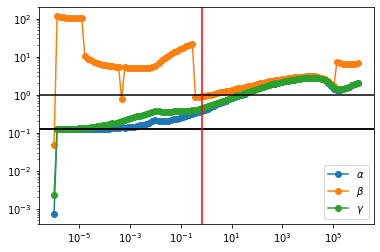

In [68]:
idx = 48
plt.plot(prange, [float(s['x'][-3]) for s in sols], 'o-', label=r'$\alpha$')
plt.plot(prange, [float(s['x'][-2]) for s in sols], 'o-', label=r'$\beta$')
plt.plot(prange, [float(s['x'][-1]) for s in sols], 'o-', label=r'$\gamma$')
for q in p0:
    plt.axhline(q, color='k')
plt.xscale('log')
plt.yscale('log')
plt.axvline(prange[idx], color='r')
plt.legend()

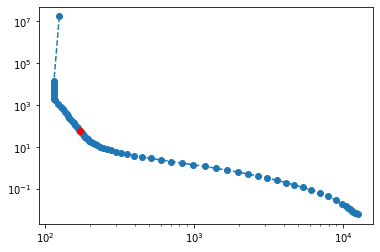

In [69]:
plt.loglog(*fsvals.T, 'o--',)
plt.loglog(*fsvals[idx], 'ro')

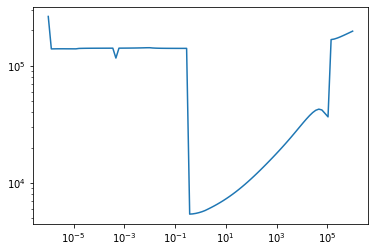

In [70]:
getN = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]).sum(axis=1))
plt.loglog(prange, [getN(i) for i,_ in enumerate(prange)])

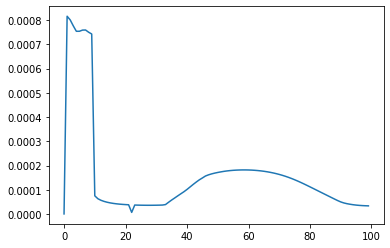

In [131]:
plt.plot([getp(sols[i]['x'])[1]/getN(i) for i,_ in enumerate(prange)])

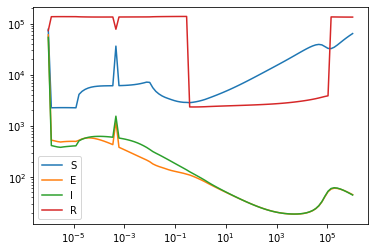

In [71]:
getM = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]), axis=0)
plt.semilogx(prange, [getM(i) for i,_ in enumerate(prange)])
plt.yscale('log')
plt.legend("SEIR")

In [72]:
# applying the final size relation
from scipy.optimize import brentq
def rinf(sol):
    pfin = np.array([float(p) for p in getp(sol['x'])])
    r0 = pfin[1]/pfin[0]
    S0, E0, I0, R0 = [float(x[0]) for x in getx(sol['x'])]
    N = sum((S0, E0, I0, R0))
    f = lambda y: y/S0 - np.exp(r0*(y-N)/N) 
    sinf = brentq(f, 0, S0) 
    return N-sinf

# def rinf(sol):
#     r0 = 8*getp(sol['x'])
#     S0, E0, I0, R0 = [float(x[0]) for x in getx(sol['x'])]
#     N = sum((S0, E0, I0, R0))
#     f = lambda y: y/S0 - np.exp(r0*(y-N)/N)
#     sinf = brentq(f, 0, S0)
#     return N-sinf

(0, 20000)

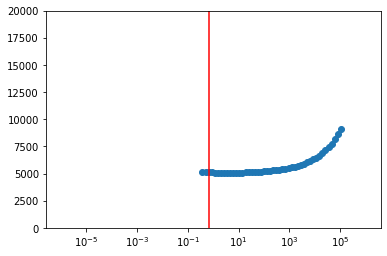

In [73]:
plt.semilogx(prange[:], [rinf(sol) for sol in sols][:], 'o')
plt.axvline(prange[idx], color='r')
plt.ylim([0,20000])

In [74]:
def rfin_data(sol):
    sofx = sol['x']
    return getp(sofx)[2]*trapz(getx(sofx)[1].toarray().flatten(), model.observation_times)

Text(0, 0.5, 'Number of Cases')

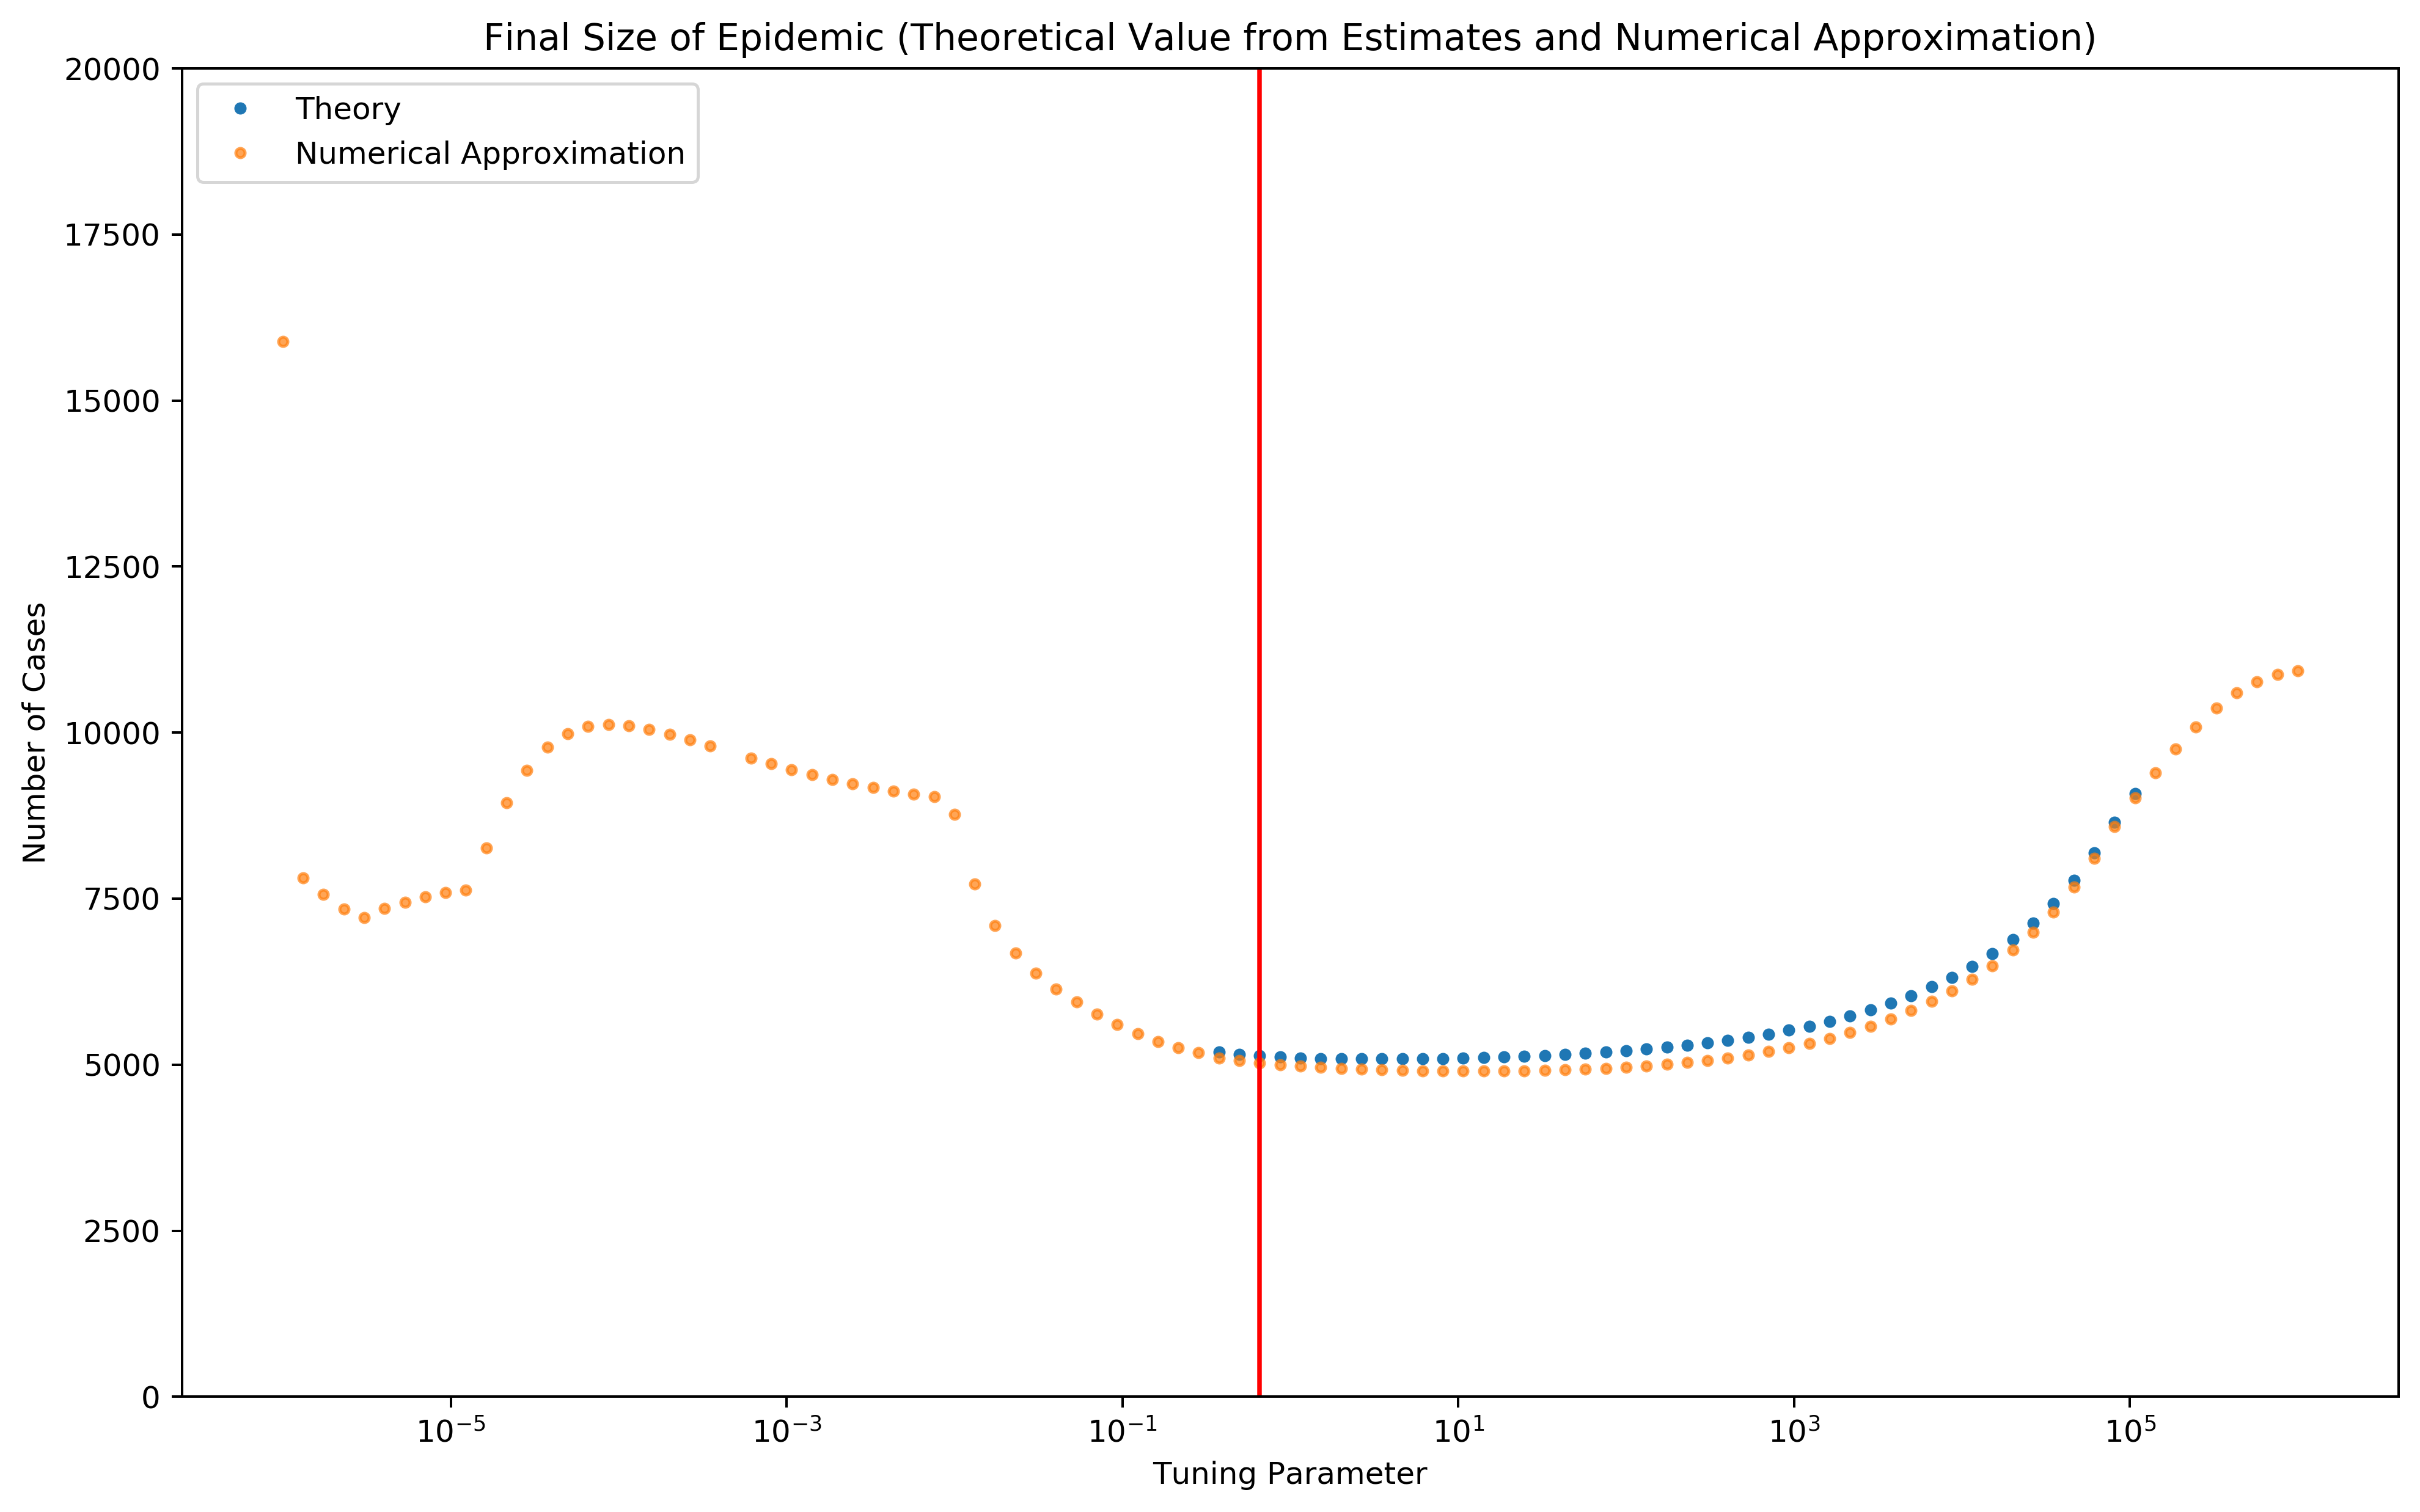

In [75]:
plt.figure(figsize=[13,8], dpi=360)
plt.semilogx(prange[:], [rinf(sol) for sol in sols][:], '.', label='Theory')
plt.semilogx(prange[:], [rfin_data(sol) for sol in sols][:], '.', label='Numerical Approximation', alpha=0.7)
plt.axvline(prange[idx], color='r')
plt.ylim([0,20000])
plt.legend()
plt.title("Final Size of Epidemic (Theoretical Value from Estimates and Numerical Approximation)")
plt.xlabel("Tuning Parameter")
plt.ylabel("Number of Cases")

In [76]:
rfin_data(sols[idx])

DM(5024.78)

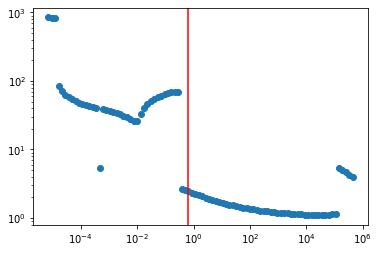

In [77]:
def r0(sol):
    pfin = np.array([float(p) for p in getp(sol['x'])])
    return pfin[1]/pfin[0]
# def r0(sol):
#     return 8*getp(sol['x'])
plt.plot(prange[7:-3], [r0(sol) for sol in sols][7:-3], 'o')
plt.xscale('log')
plt.yscale('log')
plt.axvline(prange[idx], color='r')

In [99]:
def r0theory(sol):
    S0, E0, I0, R0 = [float(xi[0]) for xi in getx(sol['x'])]
    Rinf = getx(sol['x'])[-1][-1]
    N = sum([S0, E0, I0, R0])
    return N/Rinf*np.log(S0/(N-Rinf))

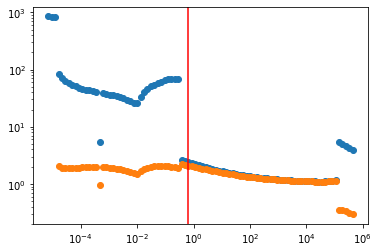

In [101]:
plt.plot(prange[7:-3], [r0(sol) for sol in sols][7:-3], 'o')
plt.plot(prange[7:-3], [r0theory(sol) for sol in sols][7:-3], 'o')
plt.xscale('log')
plt.yscale('log')
plt.axvline(prange[idx], color='r')

In [78]:
[getx(sols[idx]['x'])[i][50] for i in range(4)]

[DM(2223.9), DM(520.562), DM(576.679), DM(2090.43)]

In [79]:
getx(sols[idx]['x'])[0][0]

DM(5739.52)

In [80]:
getp(sols[idx]['x'])

(DM(0.371031), DM(0.90843), DM(0.435856))

In [81]:
r0(sols[idx])

2.4483961847131237

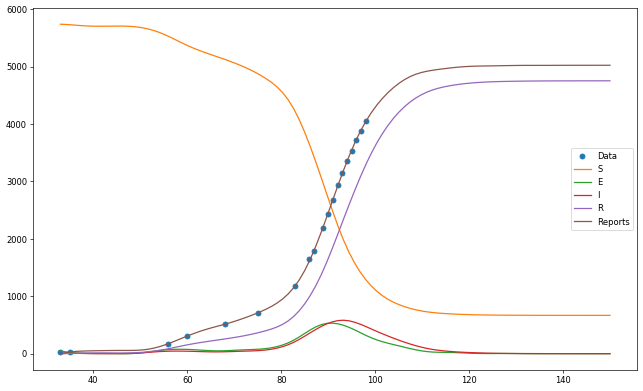

In [82]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)
ax.plot(times, cumdata, 'o', label='Data')
ax.plot(model.observation_times, getx(sols[idx]['x'])[0], label='S')
ax.plot(model.observation_times, getx(sols[idx]['x'])[1], label='E')
ax.plot(model.observation_times, getx(sols[idx]['x'])[2], label='I')
ax.plot(model.observation_times, getx(sols[idx]['x'])[3], label='R')
plt.plot(model.observation_times, 
         getp(sols[idx]['x'])[2]*cumtrapz(getx(sols[idx]['x'])[1].toarray().flatten(),
                                          model.observation_times, initial=0),
         label='Reports')
plt.legend()

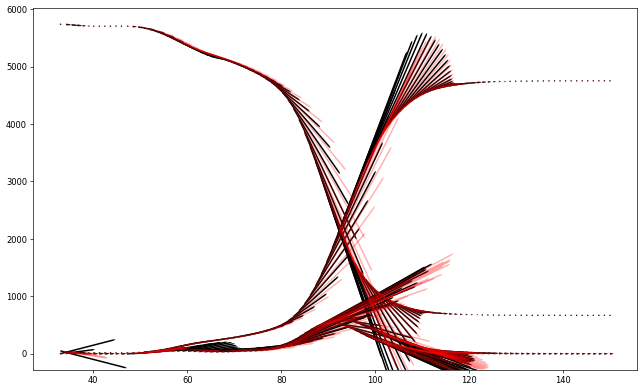

In [83]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)
xx = np.vstack([xix.toarray().flatten() for xix in getx(sols[idx]['x'])])
dxxdt = np.vstack([seir(0, xxj, [float(q) for q in getp(sols[idx]['x'])]) for xxj in xx.T])
for i, xxi in enumerate(xx):
    ax.quiver(model.observation_times, xxi, [1]*len(model.observation_times), dxxdt[:,i], 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025)
for i, xxi in enumerate(xx):
    ax.quiver(model.observation_times, xxi, np.gradient(model.observation_times), np.gradient(xxi, model.observation_times), color='r', 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025, alpha=0.3)

Text(0.5, 1.0, 'Number of Reported Cases (Fit and Prediction)')

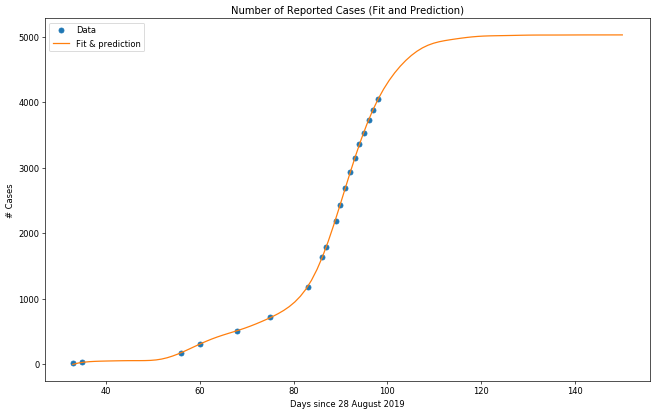

In [84]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)

ax.plot(times, cumdata, 'o', label='Data')
plt.plot(model.observation_times, 
         getp(sols[idx]['x'])[2]*cumtrapz(getx(sols[idx]['x'])[1].toarray().flatten(),
                                          model.observation_times, initial=0),
         label='Fit & prediction')
plt.legend()
plt.xlabel("Days since 28 August 2019")
plt.ylabel("# Cases")
plt.title("Number of Reported Cases (Fit and Prediction)")

In [85]:
def idx_to_reports(idx):
     return getp(sols[idx]['x'])[2]*cumtrapz(getx(sols[idx]['x'])[1].toarray().flatten(),
                                             model.observation_times, initial=0)

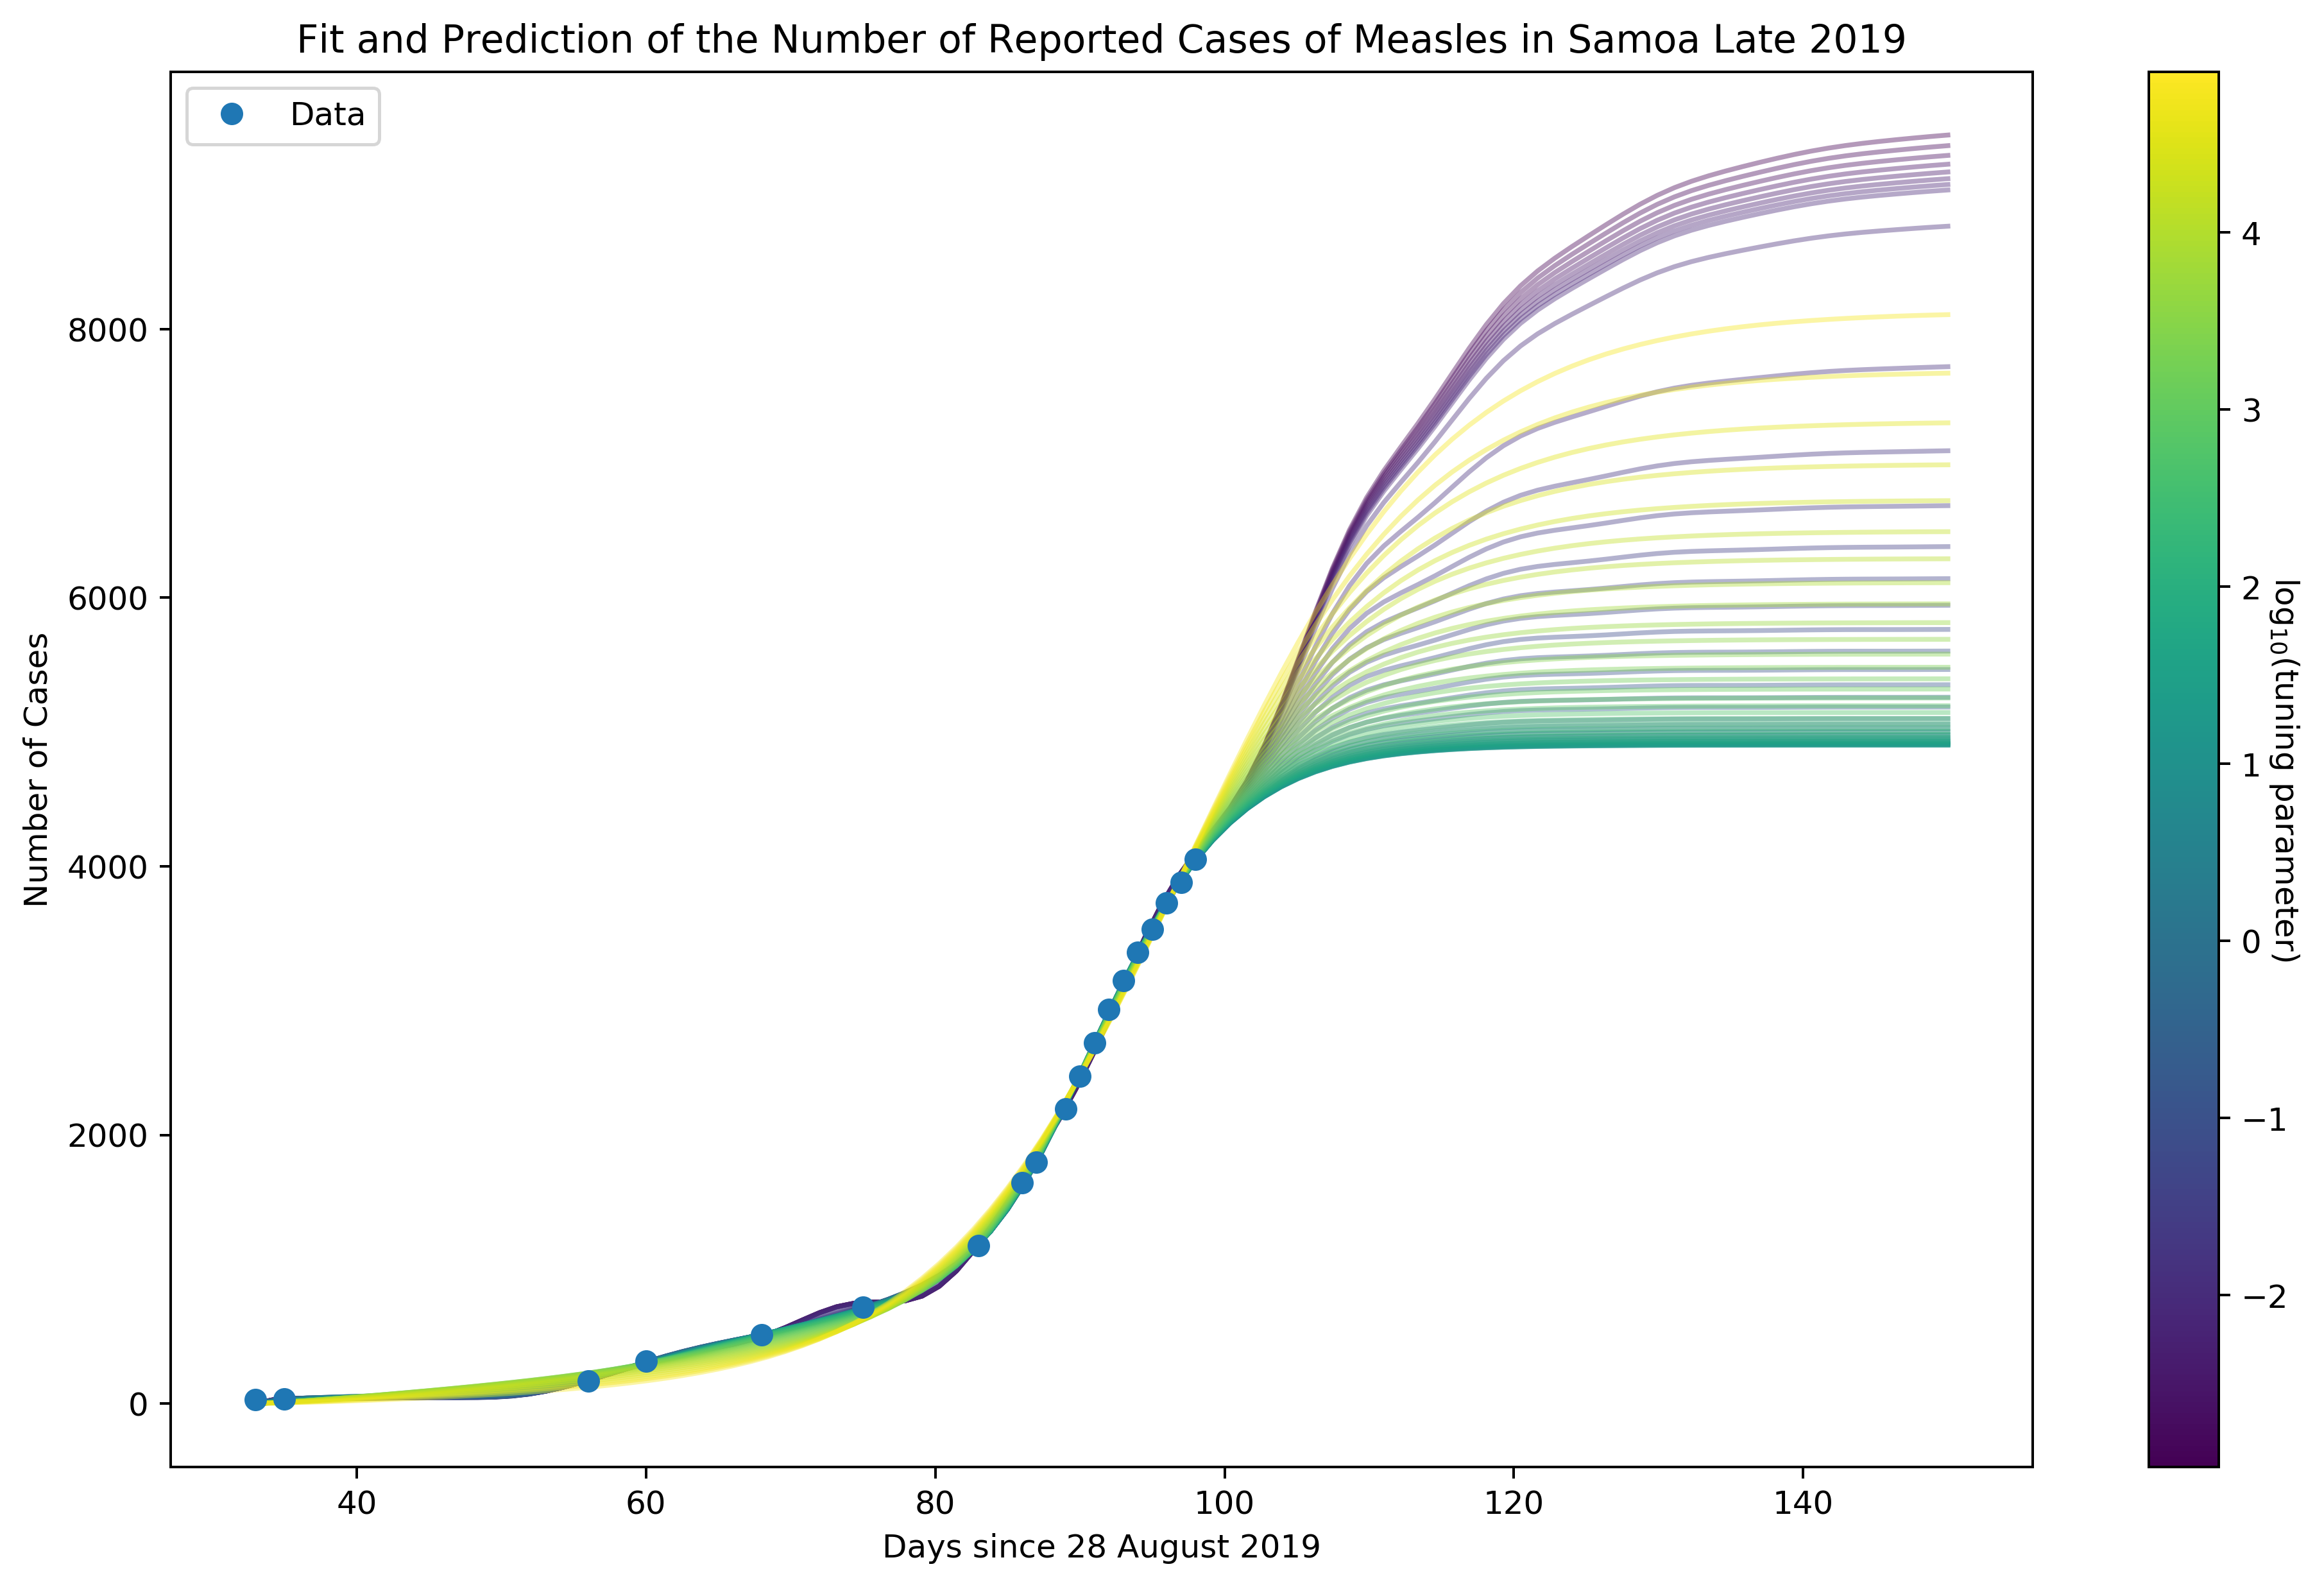

In [87]:
import matplotlib.cm as mplcm
import matplotlib.colors as colors

plt.figure(figsize=[13,8], dpi=360)

i0, i1 = (25, -10)

cNorm = colors.Normalize(vmin=np.log10(prange[i0]), vmax=np.log10(prange[i1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

for i,p in enumerate(prange[i0:i1]):
    plt.plot(model.observation_times, idx_to_reports(i+i0), color=scalarMap.to_rgba(np.log10(p)), alpha=0.4)
plt.plot(times, cumdata, 'o', label="Data")
plt.title("Fit and Prediction of the Number of Reported Cases of Measles in Samoa Late 2019")
plt.xlabel("Days since 28 August 2019")
plt.ylabel("Number of Cases")
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)
plt.legend()


(0, 10000)

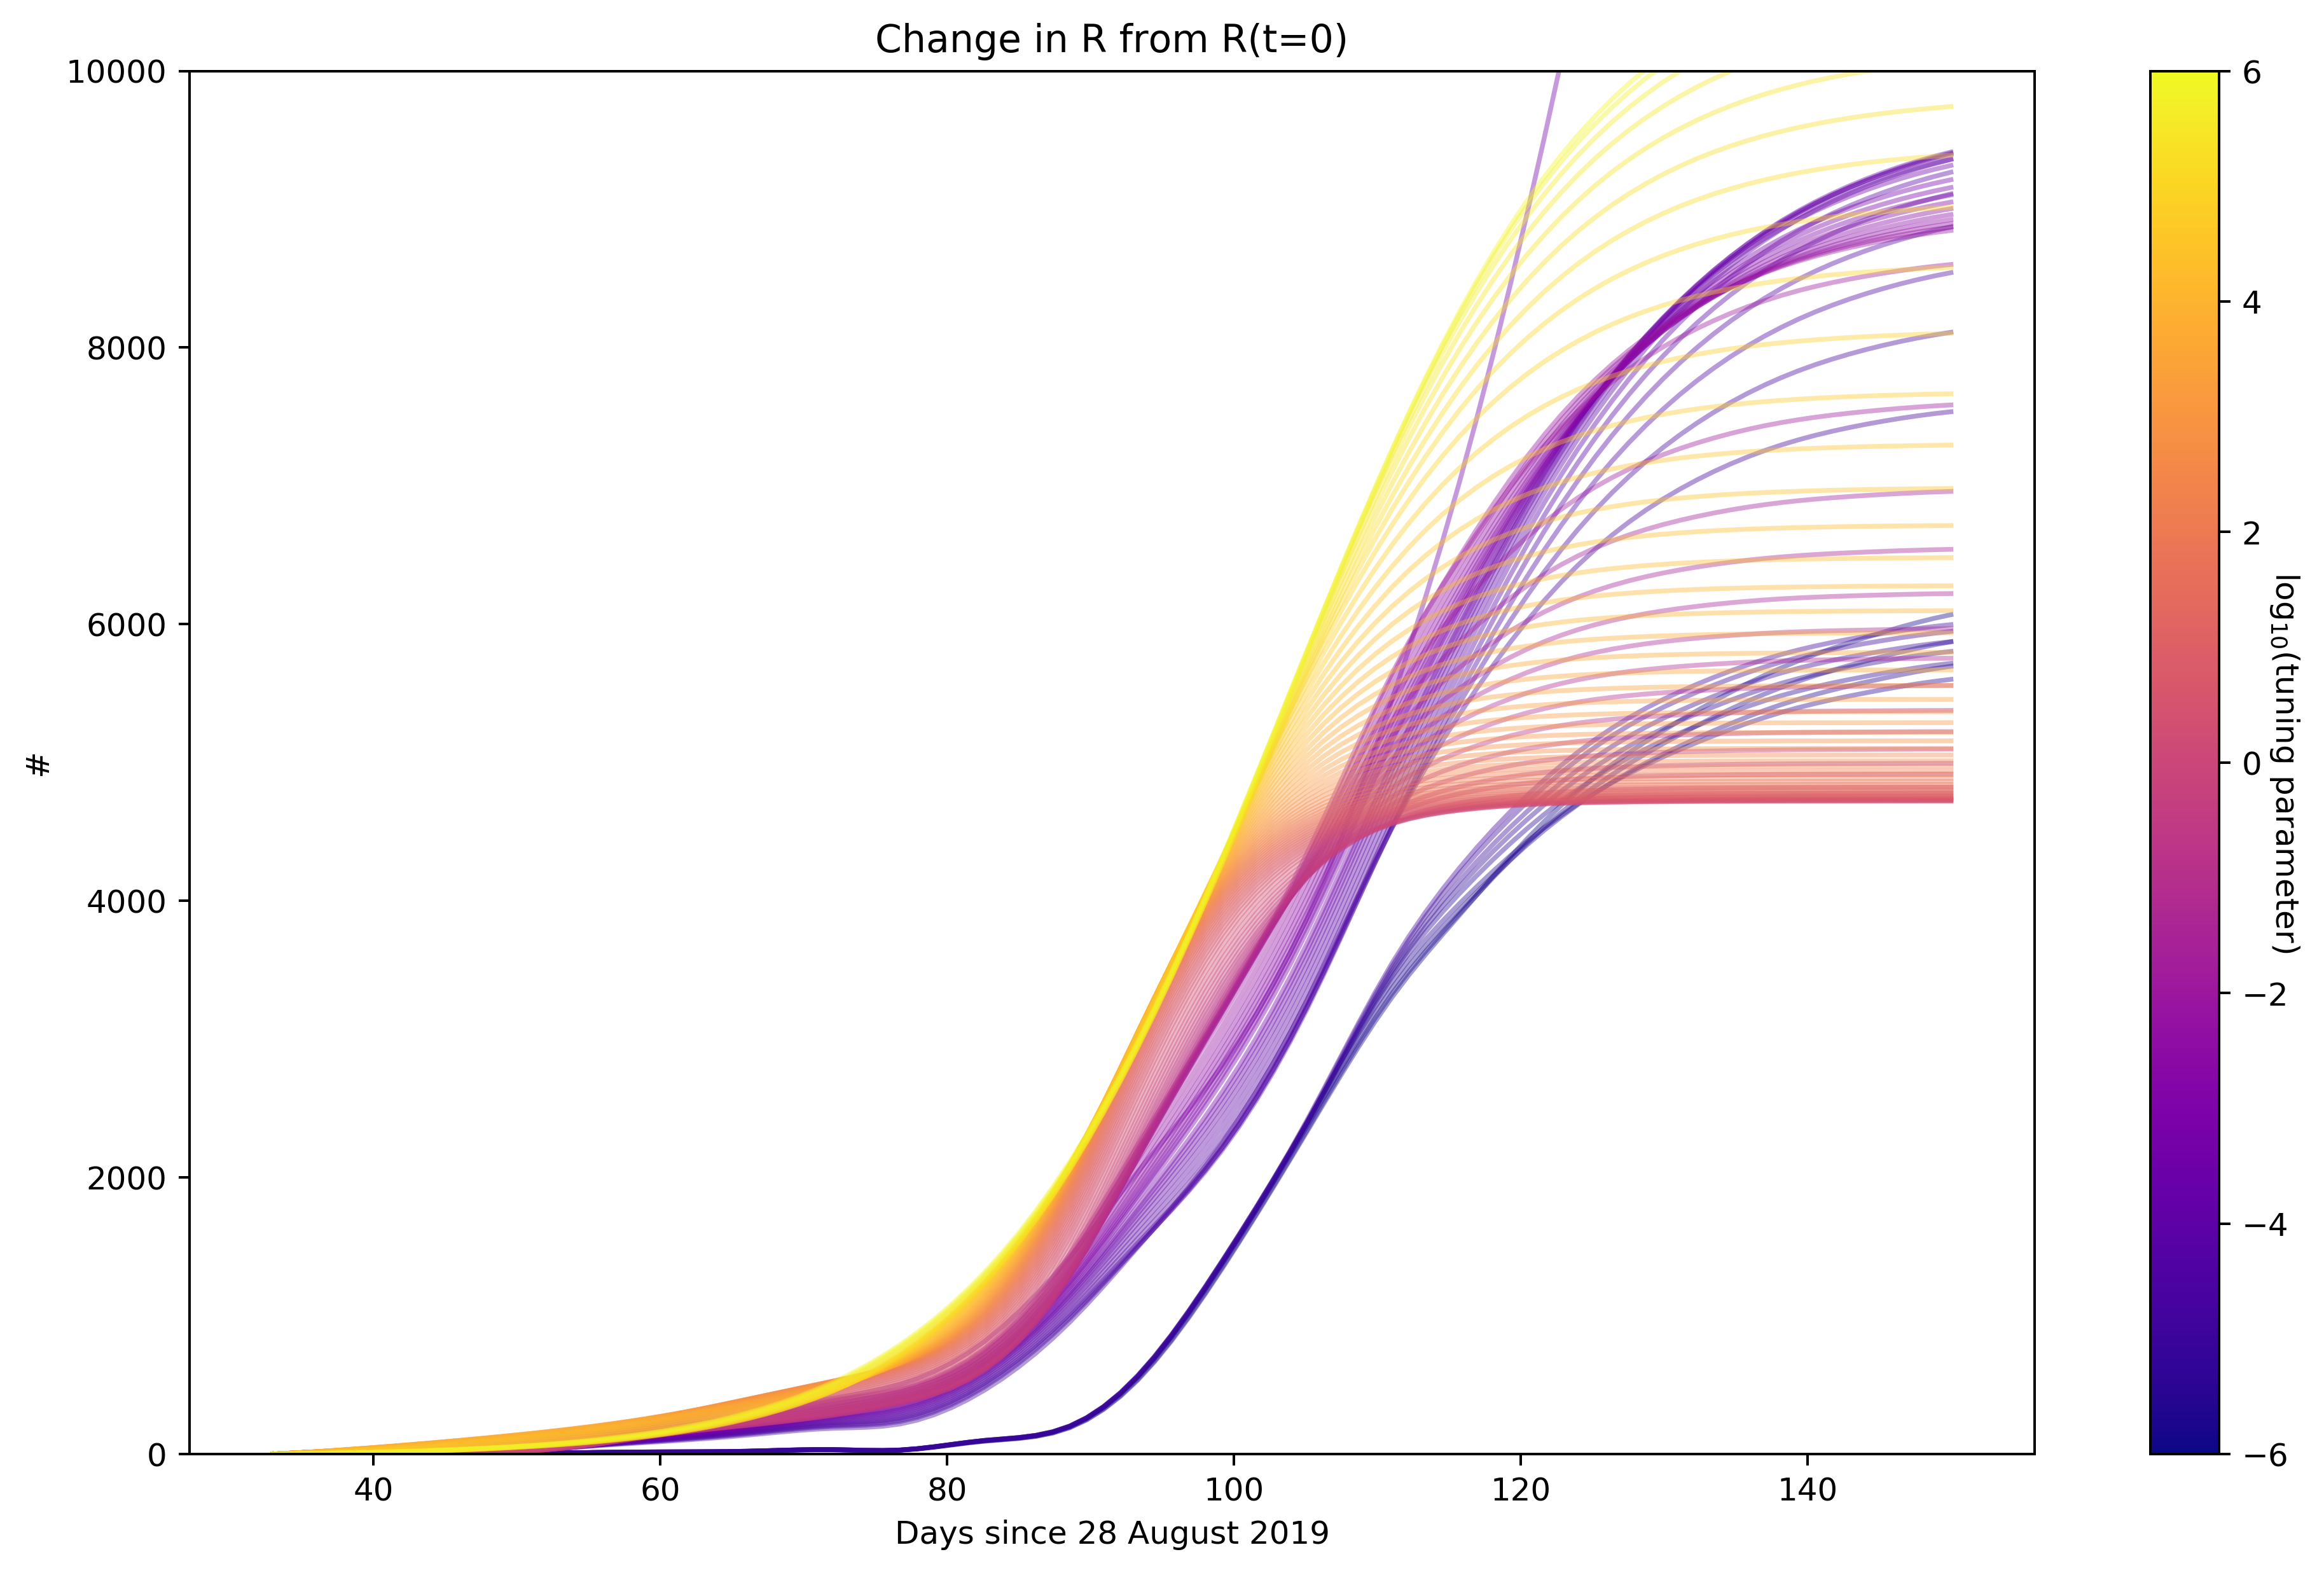

In [142]:
import matplotlib.cm as mplcm
import matplotlib.colors as colors

plt.figure(figsize=[13,8], dpi=360)

i0, i1 = (0, -1)

cNorm = colors.Normalize(vmin=np.log10(prange[i0]), vmax=np.log10(prange[i1]))
cm = plt.get_cmap('plasma')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

for i,p in enumerate(prange[i0:i1]):
    plt.plot(model.observation_times, getx(sols[i+i0]['x'])[-1] - getx(sols[i+i0]['x'])[-1][0], color=scalarMap.to_rgba(np.log10(p)), alpha=0.4)
# plt.plot(times, cumdata, 'o', label="Data")
plt.title("Change in R from R(t=0)")
plt.xlabel("Days since 28 August 2019")
plt.ylabel("#")
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)
plt.ylim(0, 10000)

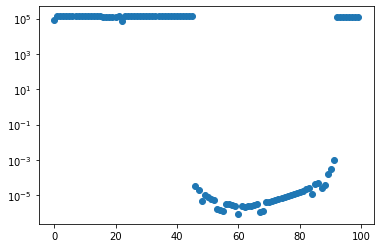

In [141]:
plt.semilogy([getx(sols[i]['x'])[-1][0] for i in range(len(prange))], 'o')

(-7032.853518381297, 0)

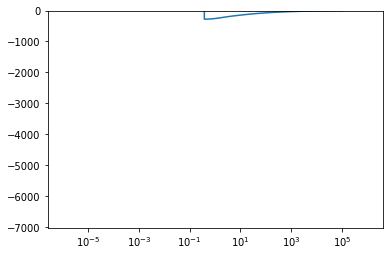

In [111]:
plt.semilogx(prange, [(getx(sols[i]['x'])[-1][-1] - idx_to_reports(i)[-1]) for i,p in enumerate(prange)])
plt.ylim([None, 0])

In [38]:
fsvals[idx]

array([163.63444196,  93.73459837])

In [39]:
getc = ca.Function('getx', [solver_setup['x']], model.cs)
np.sqrt(ca.sumsqr(cumdata - objective.collocation_matrices[0]@getc(sols[idx]['x'])[-1])/(len(times)-1))

DM(138131)

In [40]:
getp(sols[idx]['x'])

(DM(0.302335), DM(20.8816), DM(0.38759))

In [41]:
profiler_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
}
opts = {'ipopt': {'dual_inf_tol': 1e-1, 'print_frequency_iter': 10}}
profiler = ca.nlpsol('solver', 'ipopt', profiler_setup, opts)

In [42]:
rho = prange[idx]
pref = getp(sols[idx]['x'])
lbx = [-np.inf]*(config['basis_number']*config['model_form']['state']) + [0]*config['model_form']['parameters']
ubx = [np.inf]*(config['basis_number']*config['model_form']['state'] + config['model_form']['parameters'])

profiles = []
for pdx in range(config['model_form']['parameters']):
    pdx_mod = config['basis_number']*config['model_form']['state'] + pdx
    pvals = np.logspace(-1.5, 0.5, num=50)
    profiles.append([])
    for pval in pvals:
        lbx0 = np.array(lbx)
        ubx0 = np.array(ubx)
        lbx0[pdx_mod] = pval
        ubx0[pdx_mod] = pval
        profiles[pdx].append(profiler(x0=np.array(sols[idx]['x']).flatten(), p=[rho, alpha], lbx=lbx0, ubx=ubx0))

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1701

Total number of variables............................:       98
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  20  2.1441047e+02 0.00e+00 5.55e-01  -2.5 8.75e-01  -9.7 1.00e+00 1.00e+00f  1
  30  2.1430423e+02 0.00e+00 4.18e-01  -2.5 1.92e+01 -12.1 1.00e+00 1.00e+00f  1
  40  2.1427852e+02 0.00e+00 1.09e-03  -2.5 4.63e+02 -14.5 1.00e+00 1.00e+00f  1

Number of Iterations....: 46

                                   (scaled)                 (unscaled)
Objective...............:   3.1399773107741815e+00    2.1427832696662358e+02
Dual infeasibility......:   7.5571756715255821e-11    5.1571677092409094e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035598578783e-09    1.7100786700068902e-07
Overall NLP error.......:   2.5059035598578783e-09    1.7100786700068902e-07


Number of objective function evaluations             = 132
Number of objective gradient evaluations             = 47
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobia

  20  2.1018421e+02 0.00e+00 5.84e+00  -2.5 8.95e+05    -  9.69e-01 1.00e+00f  1
  30  2.0985458e+02 0.00e+00 9.27e-01  -2.5 2.29e+01 -12.2 1.00e+00 1.00e+00f  1
  40  2.0975258e+02 0.00e+00 1.52e+00  -2.5 1.59e+03 -14.5 1.00e+00 1.00e+00f  1
  50  2.0973170e+02 0.00e+00 3.75e-05  -3.8 2.59e+03 -16.9 1.00e+00 1.00e+00f  1

Number of Iterations....: 54

                                   (scaled)                 (unscaled)
Objective...............:   3.4946359751818861e+00    2.0973169593748668e+02
Dual infeasibility......:   3.0858498031245594e-12    1.8519826305627961e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035703571139e-09    1.5039260437975836e-07
Overall NLP error.......:   2.5059035703571139e-09    1.5039260437975836e-07


Number of objective function evaluations             = 171
Number of objective gradient evaluations             = 55
Number of equality constraint evaluations            = 0
Number of ine

  30  2.0453385e+02 0.00e+00 1.90e+01  -3.8 5.92e+00 -13.5 1.00e+00 1.00e+00f  1
  40  2.0450003e+02 0.00e+00 3.11e+00  -3.8 2.76e+07    -  1.00e+00 1.00e+00f  1
  50  2.0838227e+02 0.00e+00 5.27e+01  -3.8 8.98e+01  -5.0 1.00e+00 1.00e+00f  1
  60  2.0010372e+02 0.00e+00 1.35e+02  -3.8 3.62e+02  -7.1 1.00e+00 5.00e-01f  2
  70  1.7560205e+02 0.00e+00 1.96e+01  -3.8 2.51e+02  -6.4 1.00e+00 2.50e-01f  3
  80  1.6789183e+02 0.00e+00 1.17e-02  -3.8 4.35e-02  -1.2 1.00e+00 1.00e+00f  1
  90  1.6375632e+02 0.00e+00 2.55e+02  -3.8 9.81e+02    -  3.16e-01 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.6212711e+02 0.00e+00 3.23e-01  -3.8 1.16e+00  -3.9 1.00e+00 1.00e+00f  1
 110  1.6179703e+02 0.00e+00 2.87e+00  -5.7 1.89e+01  -5.0 1.00e+00 1.25e-01f  4
 120  1.6156325e+02 0.00e+00 9.48e-01  -5.7 8.37e-01  -3.5 1.00e+00 1.00e+00f  1
 130  1.6040428e+02 0.00e+00 8.85e+01  -5.7 1.53e+00  -1.9 1.00e+00 6.25e-02f  5
 140  1.5798126e+02 0.00e+00

  50  2.2362064e+03 0.00e+00 2.25e+03  -3.8 6.36e+02  -6.0 1.00e+00 1.00e+00f  1
  60  1.8395384e+03 0.00e+00 2.52e+02  -3.8 2.72e+02 -10.8 1.00e+00 1.00e+00f  1
  70  6.2522982e+02 0.00e+00 9.42e+02  -3.8 6.45e+02  -6.9 1.00e+00 2.50e-01f  3
  80  4.5570987e+02 0.00e+00 5.36e+01  -3.8 1.97e+04  -9.0 1.00e+00 1.25e-01f  4
  90  4.1036577e+02 0.00e+00 4.61e+01  -3.8 2.77e+01  -6.5 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.8925779e+02 0.00e+00 5.97e+00  -3.8 1.86e+03  -8.6 1.00e+00 1.00e+00f  1
 110  3.7237354e+02 0.00e+00 1.48e-01  -3.8 2.62e+02  -8.0 1.00e+00 1.00e+00f  1
 120  3.5896112e+02 0.00e+00 2.03e-01  -3.8 3.10e+02  -8.2 1.00e+00 1.00e+00f  1
 130  3.4809724e+02 0.00e+00 1.29e+01  -3.8 2.78e+03  -9.4 1.00e+00 1.00e+00f  1
 140  3.4126977e+02 0.00e+00 3.69e-01  -3.8 4.38e+02  -8.7 1.00e+00 1.00e+00f  1
 150  3.3439658e+02 0.00e+00 1.73e+01  -3.8 3.54e+03  -9.9 1.00e+00 1.00e+00f  1
 160  3.3064003e+02 0.00e+00

1140  3.1738413e+02 0.00e+00 4.23e-03  -8.6 6.97e+04 -18.2 1.00e+00 1.00e+00f  1
1150  3.1738402e+02 0.00e+00 1.27e-01  -8.6 1.91e+06 -19.7 1.00e+00 2.50e-01f  3
1160  3.1738390e+02 0.00e+00 1.68e-02  -8.6 2.38e+05 -18.8 1.00e+00 1.00e+00f  1
1170  3.1738380e+02 0.00e+00 4.46e-03  -8.6 1.33e+05 -18.6 1.00e+00 1.00e+00f  1
1180  3.1738370e+02 0.00e+00 1.90e-01  -8.6 1.95e+06 -19.6 1.00e+00 2.50e-01f  3
1190  3.1738362e+02 0.00e+00 5.94e-02  -8.6 4.44e+05 -19.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  3.1738350e+02 0.00e+00 2.80e-01  -8.6 1.50e+06 -19.6 1.00e+00 5.00e-01f  2
1210  3.1738333e+02 0.00e+00 3.02e-02  -8.6 4.10e+05 -19.2 1.00e+00 1.00e+00f  1
1220  3.1738324e+02 0.00e+00 5.97e-04  -8.6 4.05e+04 -18.2 1.00e+00 1.00e+00f  1
1230  3.1738311e+02 0.00e+00 9.28e-02  -8.6 8.94e+05 -19.6 1.00e+00 1.00e+00f  1
1240  3.1738302e+02 0.00e+00 4.91e-02  -8.6 8.99e+05 -19.6 1.00e+00 1.00e+00f  1
1250  3.1738293e+02 0.00e+00

  50  1.9985554e+02 0.00e+00 8.11e-04  -3.8 3.88e+00  -6.2 1.00e+00 1.00e+00f  1
  60  4.1397330e+02 0.00e+00 3.24e+01  -5.7 4.21e+01  -3.1 9.14e-01 1.00e+00f  1
  70  1.9995384e+02 0.00e+00 1.97e+01  -5.7 1.12e+01  -7.9 1.00e+00 5.00e-01f  2
  80  1.9955401e+02 0.00e+00 1.18e+02  -5.7 8.15e+02  -9.1 1.00e+00 1.00e+00f  1
  90  1.9296252e+02 0.00e+00 2.54e+02  -5.7 2.02e+02  -6.6 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.7449550e+02 0.00e+00 4.04e+00  -5.7 1.80e+01  -5.1 1.00e+00 1.00e+00f  1
 110  1.6558852e+02 0.00e+00 1.94e+00  -5.7 2.56e-01  -2.6 1.00e+00 1.00e+00f  1
 120  1.6396582e+02 0.00e+00 2.50e-01  -5.7 1.55e-01  -2.4 1.00e+00 1.00e+00f  1
 130  1.6078703e+02 0.00e+00 1.16e+01  -5.7 3.65e-01  -3.0 1.00e+00 1.00e+00f  1
 140  1.5909749e+02 0.00e+00 5.79e+01  -5.7 1.30e+00  -4.1 1.00e+00 1.00e+00f  1
 150  1.5900289e+02 0.00e+00 2.55e-02  -5.7 2.05e-03  -0.8 1.00e+00 1.00e+00f  1
 160  1.5817131e+02 0.00e+00

CasADi - 2019-12-04 15:55:59 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 15:55:59 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 15:55:59 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 15:55:59 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 15:55:59 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 15:55:59 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 15:55:59 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 500  1.5652036e+02 0.00e+00 6.64e+13  -5.7 1.56e-10  16.9 1.00e+00 3.91e-03f  9
 510  1.5647190e+02 0.00e+00 7.49e+13  -5.7 2.20e-09  16.7 1.00e+00 1.22e-04f 14
 520  1.5645825e+02 0.00e+00 1.22e+14  -5.7 1.70e-10  17.3 1.00e+00 3.55e-15f 49
 530  1.5666743e+02 0.00e+00 4.50e+11  -5.7 1.34e-11  16.2 1.00e+00 1.00e+00w  1
 540  1.5645825e+02 0.00e+00 1.22e+14  -5.7 3.65e-11  17.7 1.00e+00 2.84e-14f 46
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 543

                                   (scaled)                 (unscaled)
Objective...............:   2.0554193885415540e+01    5.3024102400115851e+02
Dual infeasibility......:   5.1790529892282940e+15    1.3360515988482675e+17
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.8449144625279508e-06    4.7593660897569693e-05
Overall NLP error.......:   5.1790529892282940e+15    1.3360515988482675e+17


Number of objective function 

CasADi - 2019-12-04 15:55:59 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


  40  1.9920821e+02 0.00e+00 3.65e-06  -8.6 1.11e-02 -13.1 1.00e+00 2.50e-01f  3

Number of Iterations....: 48

                                   (scaled)                 (unscaled)
Objective...............:   9.8310183520106040e+00    1.9920820878341371e+02
Dual infeasibility......:   4.7593404915987409e-11    9.6439622058873982e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    5.0777705994796715e-08
Overall NLP error.......:   2.5059035596800618e-09    5.0777705994796715e-08


Number of objective function evaluations             = 293
Number of objective gradient evaluations             = 49
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 48
Total CPU secs in IPOPT (w/

  30  1.9480133e+02 0.00e+00 8.74e+01  -3.8 7.04e+01  -5.4 1.00e+00 1.00e+00f  1
  40  1.7554284e+02 0.00e+00 2.01e+03  -3.8 2.73e+02  -3.8 1.00e+00 1.84e-01f  3
  50  1.6561404e+02 0.00e+00 2.63e+04  -3.8 4.54e+00  -2.3 1.00e+00 5.00e-01f  2
  60  1.6170282e+02 0.00e+00 1.66e+04  -3.8 6.97e+02    -  1.00e+00 6.25e-02f  5
  70  1.5926793e+02 0.00e+00 5.41e+04  -3.8 1.14e+00  -2.6 1.00e+00 1.00e+00f  1
  80  1.5856820e+02 0.00e+00 1.79e+04  -3.8 4.60e-01  -1.5 1.00e+00 5.00e-01f  2
  90  1.5846155e+02 0.00e+00 1.39e+05  -3.8 1.86e-01  -1.3 1.00e+00 2.47e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.5840270e+02 0.00e+00 2.37e+06  -3.8 3.03e+00  -3.3 1.00e+00 1.00e+00f  1
 110  1.5816364e+02 0.00e+00 3.89e+07  -3.8 4.26e+00  -3.6 1.00e+00 5.00e-01f  2
 120  1.5809026e+02 0.00e+00 1.96e+07  -3.8 5.12e-02  -0.2 1.00e+00 5.00e-01f  2
 130  1.5806371e+02 0.00e+00 8.74e+07  -3.8 1.59e-01  -0.5 1.00e+00 2.50e-01f  3
 140  1.5803199e+02 0.00e+00

Objective...............:   4.1675436597614350e+00    2.0375843034457657e+02
Dual infeasibility......:   6.5390387275676391e-10    3.1970493313748511e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    1.2251796684105400e-07
Overall NLP error.......:   2.5059035596800618e-09    1.2251796684105400e-07


Number of objective function evaluations             = 51
Number of objective gradient evaluations             = 36
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 35
Total CPU secs in IPOPT (w/o function evaluations)   =      0.013
Total CPU secs in NLP function evaluations           =      0.024

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall    

 670  1.7749011e+03 0.00e+00 2.88e+02  -8.6 1.85e+05    -  1.00e+00 5.00e-01f  2
 680  1.7749011e+03 0.00e+00 2.86e+02  -8.6 3.90e+05    -  1.00e+00 2.50e-01f  3
 690  1.7749011e+03 0.00e+00 1.50e+02  -8.6 8.15e+04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  1.7749010e+03 0.00e+00 2.78e+02  -8.6 2.14e+05    -  1.00e+00 5.00e-01f  2
 710  1.7749010e+03 0.00e+00 2.70e+02  -8.6 1.18e+05    -  1.00e+00 1.00e+00f  1
 720  1.8408165e+03 0.00e+00 8.12e+03  -8.6 1.44e+00  -3.2 1.00e+00 1.00e+00f  1
 730  1.9072394e+03 0.00e+00 3.69e+07  -8.6 2.87e-01  -1.2 5.17e-01 1.00e+00f  1
 740  1.8477673e+03 0.00e+00 4.09e+08  -8.6 2.37e+01  -4.1 1.00e+00 1.00e+00f  1
 750  1.8412202e+03 0.00e+00 2.81e+05  -8.6 6.33e-01  -2.6 1.00e+00 1.00e+00f  1
 760  1.7845668e+03 0.00e+00 7.66e+03  -8.6 3.30e+00  -5.9 1.00e+00 5.00e-01f  2
 770  1.7845562e+03 0.00e+00 1.02e+00  -8.6 4.51e-02  -9.7 1.00e+00 1.00e+00f  1
 780  1.7851694e+03 0.00e+00

1590  1.7749008e+03 0.00e+00 1.11e+00  -8.6 1.37e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  1.7749008e+03 0.00e+00 8.56e-01  -8.6 1.66e+03    -  1.00e+00 2.91e-11f 36
1610  1.7749008e+03 0.00e+00 4.65e-01  -8.6 2.37e+02 -19.6 1.00e+00 1.00e+00w  1
1620  1.7749008e+03 0.00e+00 1.23e+00  -8.6 3.66e+05    -  1.00e+00 1.14e-13f 44
1630  1.7749008e+03 0.00e+00 5.04e-01  -8.6 2.23e+03 -20.0 1.00e+00 1.00e+00h  1
reference_theta is slightly positive at feasible point.  Setting it to -2.220446e-16
1640  1.7749008e+03 0.00e+00 6.45e-01  -8.6 1.90e+02    -  1.00e+00 1.00e+00f  1
reference_theta is slightly positive at feasible point.  Setting it to -2.220446e-16
1650  1.7749008e+03 0.00e+00 9.14e-01  -8.6 1.85e+03 -20.0 1.00e+00 2.91e-11f 36
reference_theta is slightly positive at feasible point.  Setting it to -2.220446e-16
1660  1.7749008e+03 0.00e+00 1.61e+00  -8.6 1.48e+05    -  1.00e+00 5.00e-01f  2
reference_theta 

2410  1.7749008e+03 0.00e+00 6.56e-01  -8.6 5.02e+00 -19.1 1.00e+00 1.86e-09f 29
2420  1.7749008e+03 0.00e+00 2.56e+00  -8.6 4.32e+01    -  1.00e+00 1.00e+00w  1
2430  1.7749008e+03 0.00e+00 1.34e-01  -8.6 2.02e+01 -19.6 1.00e+00 1.86e-09f 30
reference_theta is slightly positive at feasible point.  Setting it to -2.220446e-16
2440  1.7749008e+03 0.00e+00 6.31e-01  -8.6 8.43e+00    -  1.00e+00 1.00e+00f  1
2450  1.7749008e+03 0.00e+00 2.99e-01  -8.6 4.59e+00 -19.1 1.00e+00 7.45e-09f 28
reference_theta is slightly positive at feasible point.  Setting it to -2.220446e-16
2460  1.7749008e+03 0.00e+00 2.49e-01  -8.6 3.33e+01 -20.0 1.00e+00 9.31e-10f 31
reference_theta is slightly positive at feasible point.  Setting it to -2.220446e-16
reference_theta is slightly positive at feasible point.  Setting it to -2.220446e-16
reference_theta is slightly positive at feasible point.  Setting it to -2.220446e-16
2470  1.7749008e+03 0.00e+00 7.85e-01  -8.6 2.13e+02 -20.0 1.00e+00 2.50e-01f  3
referenc


Number of Iterations....: 36

                                   (scaled)                 (unscaled)
Objective...............:   2.0345049232615291e+00    2.2095549466868064e+02
Dual infeasibility......:   4.3560316108321994e-09    4.7308271823735151e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5113411534896365e-09    2.7274184520603776e-07
Overall NLP error.......:   4.3560316108321994e-09    4.7308271823735151e-07


Number of objective function evaluations             = 100
Number of objective gradient evaluations             = 37
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 36
Total CPU secs in IPOPT (w/o function evaluations)   =      0.020
Total CPU secs in NLP function evaluations

  70  2.5013349e+02 0.00e+00 6.80e-04  -8.6 1.38e+06    -  1.00e+00 1.00e+00f  1
  80  2.5013335e+02 0.00e+00 2.30e-07  -8.6 3.03e-03 -12.8 1.00e+00 5.00e-01f  2

Number of Iterations....: 83

                                   (scaled)                 (unscaled)
Objective...............:   1.4655814134776504e+00    2.5013335074556710e+02
Dual infeasibility......:   1.7892120190071795e-11    3.0536795390065993e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    4.2768695635998298e-07
Overall NLP error.......:   2.5059035596800618e-09    4.2768695635998298e-07


Number of objective function evaluations             = 238
Number of objective gradient evaluations             = 84
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Numb

 140  3.7385361e+02 0.00e+00 2.40e+00  -3.8 2.64e+02  -8.4 1.00e+00 1.00e+00f  1
 150  3.5394538e+02 0.00e+00 5.58e+00  -3.8 1.11e+03  -9.1 1.00e+00 1.00e+00f  1
 160  3.4783595e+02 0.00e+00 5.62e+00  -3.8 1.25e+02  -8.9 1.00e+00 5.00e-01f  2
 170  3.4259801e+02 0.00e+00 4.22e+00  -5.7 2.86e+03 -10.5 1.00e+00 1.00e+00f  1
 180  3.3845709e+02 0.00e+00 7.79e+00  -5.7 4.53e+02  -9.8 1.00e+00 1.00e+00f  1
 190  3.3399470e+02 0.00e+00 2.74e+00  -5.7 6.77e+00  -6.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  3.3368381e+02 0.00e+00 2.27e-02  -5.7 8.21e+02 -10.3 1.00e+00 1.00e+00f  1
 210  3.3177801e+02 0.00e+00 7.11e-02  -5.7 2.34e+02  -9.6 1.00e+00 1.00e+00f  1
 220  3.3039284e+02 0.00e+00 1.41e+00  -5.7 3.46e+03 -11.2 1.00e+00 1.00e+00f  1
 230  3.2893960e+02 0.00e+00 3.51e-03  -5.7 3.88e+00  -7.4 1.00e+00 1.00e+00f  1
 240  3.2869982e+02 0.00e+00 1.68e-03  -8.6 2.94e+02 -10.3 1.00e+00 1.00e+00f  1
 250  3.2799082e+02 0.00e+00

1070  3.2263533e+02 0.00e+00 1.07e-04  -8.6 7.73e+03 -16.6 1.00e+00 1.00e+00f  1
1080  3.2263469e+02 0.00e+00 1.35e-02  -8.6 1.69e+05 -18.6 1.00e+00 1.00e+00f  1
1090  3.2263386e+02 0.00e+00 7.18e-03  -8.6 7.54e+04 -18.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  3.2263308e+02 0.00e+00 4.15e-03  -8.6 6.84e+04 -18.2 1.00e+00 1.00e+00f  1
1110  3.2263232e+02 0.00e+00 5.05e-05  -8.6 6.54e+03 -16.7 1.00e+00 1.00e+00f  1
1120  3.2263169e+02 0.00e+00 2.23e-03  -8.6 1.95e+05 -18.7 1.00e+00 1.00e+00f  1
1130  3.2263098e+02 0.00e+00 1.47e-02  -8.6 5.96e+05 -19.0 1.00e+00 1.00e+00f  1
1140  3.2263047e+02 0.00e+00 7.56e-03  -8.6 4.58e+05 -19.2 1.00e+00 2.50e-01f  3
1150  3.2262993e+02 0.00e+00 1.16e-02  -8.6 2.60e+05 -18.6 1.00e+00 5.00e-01f  2
1160  3.2262954e+02 0.00e+00 1.26e-02  -8.6 2.93e+05 -18.9 1.00e+00 5.00e-01f  2
1170  3.2262910e+02 0.00e+00 1.13e-02  -8.6 3.21e+05 -19.1 1.00e+00 5.00e-01f  2
1180  3.2262860e+02 0.00e+00

2160  3.2236048e+02 0.00e+00 9.13e-03  -8.6 4.59e+04 -16.2 1.00e+00 1.00e+00f  1
2170  3.2231516e+02 0.00e+00 4.04e-04  -8.6 5.64e+02 -12.8 1.00e+00 1.00e+00f  1
2180  3.2228099e+02 0.00e+00 1.02e-01  -8.6 7.19e+05 -16.7 1.00e+00 5.00e-01f  2
2190  3.2225122e+02 0.00e+00 5.45e-02  -8.6 1.42e+04 -15.1 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  3.2219209e+02 0.00e+00 6.49e-02  -8.6 2.54e+04 -14.5 1.00e+00 2.50e-01f  3
2210  3.2211341e+02 0.00e+00 5.39e-02  -8.6 6.21e+03 -14.7 1.00e+00 1.00e+00f  1
2220  3.2195944e+02 0.00e+00 4.57e-02  -8.6 4.82e+03 -13.2 1.00e+00 1.00e+00f  1
2230  3.2182755e+02 0.00e+00 9.06e-02  -8.6 2.33e+04 -15.3 1.00e+00 2.50e-01f  3
2240  3.2165627e+02 0.00e+00 6.12e-02  -8.6 6.62e+04 -15.5 1.00e+00 1.00e+00f  1
2250  3.2142896e+02 0.00e+00 2.31e-01  -8.6 1.82e+04 -14.9 1.00e+00 1.00e+00f  1
2260  3.2107755e+02 0.00e+00 3.52e-02  -8.6 5.02e+04 -15.1 1.00e+00 1.00e+00f  1
2270  3.2020369e+02 0.00e+00

 150  3.9110159e+02 0.00e+00 6.09e-02  -5.7 2.75e+03 -11.1 1.00e+00 1.00e+00f  1
 160  3.8807513e+02 0.00e+00 5.57e-02  -5.7 3.11e+02 -10.4 1.00e+00 1.00e+00f  1
 170  3.8638253e+02 0.00e+00 4.85e-02  -5.7 2.91e+03 -11.6 1.00e+00 1.00e+00f  1
 180  3.8503659e+02 0.00e+00 4.64e-02  -5.7 2.91e+03 -11.8 1.00e+00 1.00e+00f  1
 190  3.8427562e+02 0.00e+00 7.56e-02  -5.7 3.25e+03 -12.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  3.8375032e+02 0.00e+00 2.38e-04  -5.7 6.09e+01 -10.5 1.00e+00 1.00e+00f  1
 210  3.8341887e+02 0.00e+00 3.15e-03  -5.7 2.13e+01  -9.9 1.00e+00 1.00e+00f  1
 220  3.8321396e+02 0.00e+00 5.41e-01  -5.7 5.30e+03 -12.9 1.00e+00 1.00e+00f  1
 230  3.8296879e+02 0.00e+00 1.14e-01  -5.7 9.27e+02 -12.2 1.00e+00 1.00e+00f  1
 240  3.8283575e+02 0.00e+00 2.14e-02  -5.7 5.85e+03 -13.4 1.00e+00 1.00e+00f  1
 250  3.8273261e+02 0.00e+00 7.04e-02  -5.7 1.44e+04 -13.6 1.00e+00 5.00e-01f  2
 260  3.8269219e+02 0.00e+00

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1701

Total number of variables............................:       98
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.8029892e+04 0.00e+00 1.01e+02  -1.0 0.00e+00    -  0.00e+00 0.

  50  6.8968378e+02 0.00e+00 3.12e+00  -3.8 9.67e+01 -11.2 1.00e+00 5.00e-01f  2
  60  6.8960672e+02 0.00e+00 3.89e-01  -3.8 2.47e+07    -  7.83e-01 1.25e-01f  4
  70  6.8959997e+02 0.00e+00 3.89e-03  -5.7 1.77e+06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 74

                                   (scaled)                 (unscaled)
Objective...............:   1.2212714619935563e+00    6.8959997217656007e+02
Dual infeasibility......:   4.2122857368413490e-10    2.3784983251666625e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800601e-09    1.4149769963605603e-06
Overall NLP error.......:   2.5059035596800601e-09    1.4149769963605603e-06


Number of objective function evaluations             = 240
Number of objective gradient evaluations             = 75
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobia

  40  1.6578552e+03 0.00e+00 2.94e+01  -1.0 3.32e+02  -7.3 1.00e+00 1.00e+00f  1
  50  1.2351433e+03 0.00e+00 3.01e-01  -2.5 1.42e+02  -6.6 1.00e+00 1.00e+00f  1
  60  1.0251881e+03 0.00e+00 9.28e+01  -2.5 2.62e+01  -5.1 1.00e+00 1.00e+00f  1
  70  9.0968774e+02 0.00e+00 4.54e+00  -2.5 9.27e+03  -9.8 1.00e+00 1.00e+00f  1
  80  4.8624177e+02 0.00e+00 3.76e+01  -2.5 1.58e+03  -9.2 1.00e+00 1.00e+00f  1
  90  4.0935278e+02 0.00e+00 2.79e+01  -2.5 1.59e+03  -9.4 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.0570410e+02 0.00e+00 4.67e+00  -2.5 3.48e+02  -8.8 1.00e+00 1.00e+00f  1
 110  4.0286667e+02 0.00e+00 6.12e-01  -2.5 1.23e+02  -8.1 1.00e+00 1.00e+00f  1
 120  3.9782848e+02 0.00e+00 5.08e-01  -2.5 4.85e+00  -6.1 1.00e+00 1.00e+00f  1
 130  3.9333003e+02 0.00e+00 3.79e-01  -2.5 4.60e+00  -6.3 1.00e+00 1.00e+00f  1
 140  3.8803660e+02 0.00e+00 2.88e+00  -2.5 8.10e+01  -7.5 1.00e+00 1.00e+00f  1
 150  3.7620739e+02 0.00e+00

 350  1.7098360e+02 0.00e+00 2.26e-06  -8.6 3.44e-09    -  1.00e+00 1.53e-05f 17

Number of Iterations....: 355

                                   (scaled)                 (unscaled)
Objective...............:   1.9421577779545633e+00    1.7098359837775232e+02
Dual infeasibility......:   2.7137124836071957e-10    2.3890969656361297e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.2061462394315300e-07
Overall NLP error.......:   2.5059035596800622e-09    2.2061462394315300e-07


Number of objective function evaluations             = 1213
Number of objective gradient evaluations             = 356
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 355
Total CPU secs in IPOPT

 160  3.4416892e+02 0.00e+00 1.09e+01  -2.5 3.24e+02  -7.9 1.00e+00 1.00e+00f  1
 170  3.1642078e+02 0.00e+00 5.75e+01  -2.5 4.80e+02  -8.2 1.00e+00 2.50e-01f  3
 180  2.9770500e+02 0.00e+00 2.49e+00  -2.5 1.79e+02  -7.5 1.00e+00 1.00e+00f  1
 190  2.7577723e+02 0.00e+00 1.23e+01  -2.5 4.19e+02  -7.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.5613172e+02 0.00e+00 1.19e+01  -3.8 3.39e+02  -8.1 1.00e+00 1.00e+00f  1
 210  2.4263734e+02 0.00e+00 5.74e-01  -3.8 9.17e+01  -7.4 1.00e+00 1.00e+00f  1
 220  2.3910508e+02 0.00e+00 3.19e-01  -3.8 4.02e+02  -9.5 1.00e+00 1.00e+00f  1
 230  2.1821662e+02 0.00e+00 6.70e+00  -3.8 1.28e+02  -7.9 1.00e+00 1.00e+00f  1
 240  2.0215835e+02 0.00e+00 7.59e+00  -3.8 2.71e+03  -8.2 1.00e+00 6.25e-02f  5
 250  1.9027186e+02 0.00e+00 2.82e+01  -3.8 2.95e+02  -8.4 1.00e+00 1.00e+00f  1
 260  1.7979203e+02 0.00e+00 1.36e+01  -3.8 1.23e+03    -  1.00e+00 1.25e-01f  4
 270  1.7622241e+02 0.00e+00

  70  4.1798279e+02 0.00e+00 6.07e+01  -1.7 3.48e+01  -6.2 1.00e+00 5.00e-01f  2
  80  4.0998895e+02 0.00e+00 5.76e+01  -1.7 7.61e+03 -11.0 1.00e+00 1.00e+00f  1
  90  4.0445302e+02 0.00e+00 6.56e-01  -2.5 1.39e+02  -8.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.0127340e+02 0.00e+00 1.48e-01  -2.5 6.86e+01  -7.9 1.00e+00 1.00e+00f  1
 110  3.9679997e+02 0.00e+00 4.55e+01  -2.5 1.12e+03  -9.0 1.00e+00 1.00e+00f  1
 120  3.9003252e+02 0.00e+00 1.51e+02  -2.5 4.44e+02  -6.0 1.00e+00 3.12e-02f  6
 130  3.7810426e+02 0.00e+00 2.16e+01  -2.5 6.04e+02  -8.1 1.00e+00 1.00e+00f  1
 140  3.6509676e+02 0.00e+00 6.00e-01  -2.5 8.97e+01  -7.4 1.00e+00 1.00e+00f  1
 150  3.4610136e+02 0.00e+00 8.30e-02  -2.5 3.22e+01  -6.7 1.00e+00 1.00e+00f  1
 160  3.2917526e+02 0.00e+00 7.57e+00  -2.5 3.71e+02  -7.9 1.00e+00 1.00e+00f  1
 170  2.8935616e+02 0.00e+00 7.73e+00  -2.5 3.58e+02  -8.1 1.00e+00 1.00e+00f  1
 180  2.5624004e+02 0.00e+00

 110  3.9129268e+02 0.00e+00 1.48e+00  -3.8 1.77e+02  -8.0 1.00e+00 1.00e+00f  1
 120  3.8294944e+02 0.00e+00 1.33e+00  -3.8 1.51e+02  -7.8 1.00e+00 1.00e+00f  1
 130  3.7207667e+02 0.00e+00 2.85e+01  -3.8 6.53e+02  -8.5 1.00e+00 1.00e+00f  1
 140  3.5604796e+02 0.00e+00 4.43e+00  -3.8 2.73e+02  -7.9 1.00e+00 1.00e+00f  1
 150  3.3547761e+02 0.00e+00 1.36e+01  -3.8 5.46e+02  -8.1 1.00e+00 1.00e+00f  1
 160  3.1358645e+02 0.00e+00 1.04e+00  -3.8 1.59e+02  -7.5 1.00e+00 1.00e+00f  1
 170  2.8764637e+02 0.00e+00 8.22e-02  -3.8 4.95e+01  -6.8 1.00e+00 1.00e+00f  1
 180  2.5883919e+02 0.00e+00 7.04e-03  -3.8 1.13e+01  -6.2 1.00e+00 1.00e+00f  1
 190  2.4623130e+02 0.00e+00 4.50e-01  -3.8 1.20e+02  -7.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.3843358e+02 0.00e+00 1.01e+01  -3.8 9.60e+03 -10.3 1.00e+00 6.25e-02f  5
 210  2.2661421e+02 0.00e+00 1.67e+01  -3.8 2.03e+02  -8.7 1.00e+00 5.00e-01f  2
 220  2.0684859e+02 0.00e+00

 130  3.6684507e+02 0.00e+00 4.34e+01  -3.8 1.48e+03  -9.6 1.00e+00 1.25e-01f  4
 140  3.3656952e+02 0.00e+00 6.22e+00  -3.8 5.18e+02  -8.9 1.00e+00 1.00e+00f  1
 150  3.1321207e+02 0.00e+00 1.31e+01  -3.8 1.36e+03  -9.2 1.00e+00 1.00e+00f  1
 160  2.9607150e+02 0.00e+00 4.18e+01  -3.8 4.43e+02  -8.5 1.00e+00 2.50e-01f  3
 170  2.6505468e+02 0.00e+00 1.92e-01  -3.8 1.70e+02  -7.9 1.00e+00 1.00e+00f  1
 180  2.4675245e+02 0.00e+00 4.30e+01  -3.8 2.09e+03  -9.0 1.00e+00 5.00e-01f  2
 190  2.4199996e+02 0.00e+00 6.11e+00  -3.8 1.58e+03 -10.2 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.3875183e+02 0.00e+00 1.47e+01  -3.8 7.77e+03 -11.3 1.00e+00 1.00e+00f  1
 210  2.2561555e+02 0.00e+00 1.63e+01  -3.8 5.92e+02  -8.9 1.00e+00 5.00e-01f  2
 220  1.9757015e+02 0.00e+00 2.91e+01  -3.8 2.53e+01  -6.4 1.00e+00 1.00e+00f  1
 230  1.8906401e+02 0.00e+00 2.89e+01  -3.8 2.77e+02    -  1.00e+00 5.00e-01f  2
 240  1.8630516e+02 0.00e+00

  30  8.1313269e+02 0.00e+00 9.01e+01  -1.0 1.33e+04  -9.7 1.00e+00 1.00e+00f  1
  40  5.0807272e+02 0.00e+00 2.43e+01  -1.0 2.11e+03  -9.1 1.00e+00 1.00e+00f  1
  50  4.1344472e+02 0.00e+00 9.05e-01  -2.5 1.13e+01  -6.6 1.00e+00 1.00e+00f  1
  60  4.0645713e+02 0.00e+00 8.83e+00  -2.5 8.57e+01  -8.2 1.00e+00 1.00e+00f  1
  70  4.0517197e+02 0.00e+00 2.26e-01  -3.8 3.64e+01  -8.4 1.00e+00 1.00e+00f  1
  80  4.0215463e+02 0.00e+00 3.54e-02  -3.8 3.19e+00  -6.4 1.00e+00 1.00e+00f  1
  90  3.9909971e+02 0.00e+00 4.46e+01  -3.8 1.45e+03 -10.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.9474590e+02 0.00e+00 2.12e-01  -3.8 7.10e+01  -7.8 1.00e+00 1.00e+00f  1
 110  3.8361215e+02 0.00e+00 4.98e+01  -3.8 3.20e+03  -9.8 1.00e+00 2.50e-01f  3
 120  3.7044651e+02 0.00e+00 5.05e+01  -3.8 1.88e+03  -9.6 1.00e+00 5.00e-01f  2
 130  3.5401655e+02 0.00e+00 5.73e+00  -3.8 8.12e+00  -6.2 1.00e+00 1.00e+00f  1
 140  3.2714381e+02 0.00e+00

  80  3.9766928e+02 0.00e+00 5.83e-01  -3.8 1.27e+02  -8.2 1.00e+00 1.00e+00f  1
  90  3.9128198e+02 0.00e+00 9.39e+01  -3.8 1.66e+03  -9.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.8737706e+02 0.00e+00 1.12e+02  -3.8 6.33e+03 -10.5 1.00e+00 1.00e+00f  1
 110  3.7971166e+02 0.00e+00 2.63e-01  -3.8 9.29e+01  -8.0 1.00e+00 1.00e+00f  1
 120  3.6284862e+02 0.00e+00 4.06e+01  -3.8 1.26e+03  -9.2 1.00e+00 1.00e+00f  1
 130  3.5074834e+02 0.00e+00 7.45e+01  -3.8 7.87e+03 -10.4 1.00e+00 1.00e+00f  1
 140  3.3287247e+02 0.00e+00 5.95e-01  -3.8 2.22e+01  -7.0 1.00e+00 1.00e+00f  1
 150  3.0592681e+02 0.00e+00 5.52e+01  -3.8 1.86e+03  -9.1 1.00e+00 5.00e-01f  2
 160  2.8997614e+02 0.00e+00 5.78e+01  -3.8 2.62e+03  -9.3 1.00e+00 5.00e-01f  2
 170  2.7230344e+02 0.00e+00 1.28e-01  -3.8 1.56e+02  -7.8 1.00e+00 1.00e+00f  1
 180  2.5120234e+02 0.00e+00 6.89e+00  -3.8 1.26e+03  -8.9 1.00e+00 1.00e+00f  1
 190  2.4135684e+02 0.00e+00

 160  1.9708906e+02 0.00e+00 1.30e+01  -3.8 1.18e+01    -  1.00e+00 1.00e+00f  1
 170  1.9570207e+02 0.00e+00 3.81e+00  -3.8 6.06e+00    -  1.00e+00 1.00e+00f  1
 180  1.9487414e+02 0.00e+00 3.95e+01  -3.8 7.05e+01    -  1.00e+00 2.50e-01f  3
 190  1.9428622e+02 0.00e+00 5.07e+00  -3.8 6.25e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.9396453e+02 0.00e+00 1.37e+01  -3.8 9.82e+00    -  1.00e+00 1.00e+00f  1
 210  1.9377726e+02 0.00e+00 1.89e+01  -3.8 1.11e+01    -  1.00e+00 1.00e+00f  1
 220  1.9367836e+02 0.00e+00 1.44e+01  -3.8 9.40e+00    -  1.00e+00 1.00e+00f  1
 230  1.9363441e+02 0.00e+00 9.86e-01  -3.8 2.42e+00    -  1.00e+00 1.00e+00f  1
 240  1.9362277e+02 0.00e+00 7.12e-01  -3.8 2.02e+00    -  1.00e+00 1.00e+00f  1
 250  1.9362186e+02 0.00e+00 1.17e-01  -5.7 1.05e+00    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 253

                                   (scaled)                 (unscaled)
Object

 200  1.9613803e+02 0.00e+00 2.84e+01  -3.8 2.89e+01    -  1.00e+00 5.00e-01f  2
 210  1.9555292e+02 0.00e+00 2.10e+01  -3.8 1.28e+01    -  1.00e+00 1.00e+00f  1
 220  1.9520965e+02 0.00e+00 1.94e+01  -3.8 1.18e+01    -  1.00e+00 1.00e+00f  1
 230  1.9501965e+02 0.00e+00 1.05e+01  -3.8 3.06e+01    -  1.00e+00 2.50e-01f  3
 240  1.9492302e+02 0.00e+00 2.19e+00  -3.8 3.72e+00    -  1.00e+00 1.00e+00f  1
 250  1.9488759e+02 0.00e+00 8.43e+00  -3.8 7.08e+00    -  1.00e+00 1.00e+00f  1
 260  1.9487743e+02 0.00e+00 1.00e+00  -3.8 2.40e+00    -  1.00e+00 1.00e+00f  1
 270  1.9487708e+02 0.00e+00 1.62e-05  -8.6 1.26e-02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 271

                                   (scaled)                 (unscaled)
Objective...............:   2.2265376794190228e+00    1.9487707858353122e+02
Dual infeasibility......:   3.5884634480177528e-11    3.1407924501684510e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity...

 190  1.9613583e+02 0.00e+00 1.09e+01  -1.7 3.50e+01    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.9602619e+02 0.00e+00 1.05e+01  -1.7 8.70e+00    -  1.00e+00 1.00e+00f  1
 210  1.9597959e+02 0.00e+00 3.90e-01  -1.7 1.65e+00    -  1.00e+00 1.00e+00f  1
 220  1.9590751e+02 0.00e+00 3.59e+00  -2.5 4.74e+00    -  1.00e+00 1.00e+00f  1
 230  1.9589586e+02 0.00e+00 5.60e-01  -2.5 1.84e+00    -  1.00e+00 1.00e+00f  1
 240  1.9589358e+02 0.00e+00 4.44e-02  -3.8 5.12e-01    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 246

                                   (scaled)                 (unscaled)
Objective...............:   2.2416466292787312e+00    1.9589356427509884e+02
Dual infeasibility......:   2.3501541064795529e-10    2.0537584224957480e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596803451e-09    2.1898651358505548e-07
Overall NLP error.....

 180  1.9890449e+02 0.00e+00 1.84e+01  -3.8 1.42e+01    -  1.00e+00 1.00e+00f  1
 190  1.9793026e+02 0.00e+00 2.58e+01  -3.8 1.57e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.9730048e+02 0.00e+00 1.23e+01  -3.8 1.02e+01    -  1.00e+00 1.00e+00f  1
 210  1.9695249e+02 0.00e+00 1.78e+00  -3.8 3.74e+00    -  1.00e+00 1.00e+00f  1
 220  1.9677848e+02 0.00e+00 6.36e+00  -3.8 6.72e+00    -  1.00e+00 1.00e+00f  1
 230  1.9670136e+02 0.00e+00 8.22e+00  -3.8 1.36e+01    -  1.00e+00 5.00e-01f  2
 240  1.9667530e+02 0.00e+00 5.53e+00  -3.8 1.14e+01    -  1.00e+00 5.00e-01f  2
 250  1.9667175e+02 0.00e+00 4.08e-02  -3.8 5.00e-01    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 255

                                   (scaled)                 (unscaled)
Objective...............:   2.2548009456698459e+00    1.9667174743477145e+02
Dual infeasibility......:   5.8481935311482744e-11    5.1010021231207581e-09
Constraint vio

  60  3.8534655e+02 0.00e+00 6.27e-02  -3.8 2.06e+01  -7.3 1.00e+00 1.00e+00f  1
  70  3.7695439e+02 0.00e+00 4.27e+01  -3.8 1.81e+03  -9.8 1.00e+00 5.00e-01f  2
  80  3.6324107e+02 0.00e+00 4.51e+01  -3.8 1.12e+03  -9.6 1.00e+00 1.00e+00f  1
  90  3.4616289e+02 0.00e+00 2.13e-01  -3.8 9.96e+01  -7.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.1363623e+02 0.00e+00 1.14e+01  -3.8 7.09e+00  -5.1 1.00e+00 1.00e+00f  1
 110  3.0176015e+02 0.00e+00 6.19e+01  -3.8 4.35e+03  -9.8 1.00e+00 1.00e+00f  1
 120  2.8003869e+02 0.00e+00 1.45e-01  -3.8 2.71e+02  -8.3 1.00e+00 1.00e+00f  1
 130  2.4936644e+02 0.00e+00 3.13e+01  -3.8 2.44e+03  -9.5 1.00e+00 1.25e-01f  4
 140  2.3368058e+02 0.00e+00 5.47e+01  -3.8 6.65e+03 -10.6 1.00e+00 1.00e+00f  1
 150  2.0679103e+02 0.00e+00 3.60e+00  -3.8 4.64e+02    -  1.00e+00 1.00e+00f  1
 160  2.0146166e+02 0.00e+00 1.95e+01  -3.8 3.65e+01    -  1.00e+00 1.00e+00f  1
 170  1.9979515e+02 0.00e+00

  60  3.4012900e+02 0.00e+00 8.39e+01  -1.0 4.45e+03  -9.9 1.00e+00 5.00e-01f  2
  70  2.2730231e+02 0.00e+00 4.54e+01  -1.0 4.84e+02    -  1.00e+00 6.25e-02f  5
  80  2.1023626e+02 0.00e+00 4.19e+00  -1.0 1.98e+02    -  1.00e+00 1.00e+00f  1
  90  2.0554753e+02 0.00e+00 1.06e+01  -1.0 8.22e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.0312116e+02 0.00e+00 2.16e+01  -1.0 2.25e+01    -  1.00e+00 1.00e+00f  1
 110  2.0144058e+02 0.00e+00 1.63e+01  -1.0 3.02e+01    -  1.00e+00 5.00e-01f  2
 120  2.0037739e+02 0.00e+00 6.35e+00  -1.0 1.05e+01    -  1.00e+00 1.00e+00f  1
 130  1.9976854e+02 0.00e+00 7.86e+00  -1.0 1.99e+01    -  1.00e+00 5.00e-01f  2
 140  1.9870610e+02 0.00e+00 2.04e+01  -1.7 6.42e+01    -  1.00e+00 1.00e+00f  1
 150  1.9818456e+02 0.00e+00 1.55e+01  -1.7 2.23e+01    -  1.00e+00 5.00e-01f  2
 160  1.9798466e+02 0.00e+00 5.80e+00  -1.7 2.51e+01    -  1.00e+00 2.50e-01f  3
 170  1.9789039e+02 0.00e+00

  30  4.0120341e+02 0.00e+00 6.30e+00  -1.0 2.44e+03  -8.8 1.00e+00 1.00e+00f  1
  40  3.7302098e+02 0.00e+00 1.71e+00  -1.0 1.19e+01  -5.9 1.00e+00 1.00e+00f  1
  50  3.6775039e+02 0.00e+00 7.47e-03  -1.0 1.16e+01  -6.1 1.00e+00 1.00e+00f  1
  60  3.6049583e+02 0.00e+00 3.58e+00  -2.5 2.67e+02  -8.2 1.00e+00 1.00e+00f  1
  70  3.4779488e+02 0.00e+00 2.90e+00  -2.5 3.11e+02  -8.0 1.00e+00 1.00e+00f  1
  80  3.2471068e+02 0.00e+00 4.73e-01  -2.5 7.61e+00  -6.4 1.00e+00 1.00e+00f  1
  90  3.0288572e+02 0.00e+00 1.47e+02  -3.8 1.14e+03  -9.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.9291200e+02 0.00e+00 7.51e-01  -3.8 4.99e+02  -8.7 1.00e+00 1.00e+00f  1
 110  2.5957941e+02 0.00e+00 3.19e+01  -3.8 5.82e+02  -9.0 1.00e+00 1.25e-01f  4
 120  2.4322805e+02 0.00e+00 2.03e+01  -3.8 9.35e+03 -11.1 1.00e+00 5.00e-01f  2
 130  2.3719210e+02 0.00e+00 1.73e+00  -3.8 1.98e+04 -11.3 1.00e+00 1.00e+00f  1
 140  2.1599807e+02 0.00e+00

 130  1.9827590e+02 0.00e+00 3.46e+00  -1.7 2.01e+01    -  1.00e+00 2.50e-01f  3
 140  1.9823318e+02 0.00e+00 2.86e-01  -1.7 1.55e+00    -  1.00e+00 1.00e+00f  1
 150  1.9815944e+02 0.00e+00 2.40e+00  -2.5 7.47e+00    -  1.00e+00 5.00e-01f  2
 160  1.9815393e+02 0.00e+00 6.32e-01  -3.8 4.12e+00    -  1.00e+00 5.00e-01f  2
 170  1.9815385e+02 0.00e+00 5.41e-06  -8.6 3.43e-08    -  1.00e+00 6.10e-05f 15

Number of Iterations....: 178

                                   (scaled)                 (unscaled)
Objective...............:   2.3055803142668814e+00    1.9815384876974699e+02
Dual infeasibility......:   8.1864234768618051e-11    7.0358482398605645e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.1537069514505549e-07
Overall NLP error.......:   2.5059035596800622e-09    2.1537069514505549e-07


Number of objective function evaluations             = 748
Number of objective gradient evaluations      

  80  2.0009536e+02 0.00e+00 4.99e+00  -1.0 8.96e+00    -  1.00e+00 1.00e+00f  1
  90  1.9909502e+02 0.00e+00 1.06e+01  -1.7 8.86e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.9860443e+02 0.00e+00 1.97e+01  -1.7 1.74e+01    -  1.00e+00 1.00e+00f  1
 110  1.9843296e+02 0.00e+00 2.80e+00  -1.7 6.43e+00    -  1.00e+00 1.00e+00f  1
 120  1.9836688e+02 0.00e+00 3.99e-01  -1.7 2.39e+00    -  1.00e+00 1.00e+00f  1
 130  1.9828988e+02 0.00e+00 5.15e+00  -2.5 8.70e+00    -  1.00e+00 1.00e+00f  1
 140  1.9828220e+02 0.00e+00 6.67e-01  -3.8 6.00e+00    -  1.00e+00 5.00e-01f  2

Number of Iterations....: 148

                                   (scaled)                 (unscaled)
Objective...............:   2.3268193495391909e+00    1.9828211622720923e+02
Dual infeasibility......:   1.4382516190756189e-10    1.2256197489246486e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity...

  40  2.1334367e+02 0.00e+00 1.85e+01  -1.0 7.83e+02    -  1.00e+00 1.00e+00f  1
  50  2.0103437e+02 0.00e+00 4.21e+01  -1.0 1.78e+03    -  1.00e+00 2.50e-01f  3
  60  1.9938343e+02 0.00e+00 1.55e+01  -1.7 2.45e+01    -  1.00e+00 1.00e+00f  1
  70  1.9883689e+02 0.00e+00 1.76e+00  -1.7 7.86e+00    -  1.00e+00 1.00e+00f  1
  80  1.9857857e+02 0.00e+00 1.05e+01  -1.7 1.83e+01    -  1.00e+00 1.00e+00f  1
  90  1.9845671e+02 0.00e+00 4.89e+00  -1.7 2.24e+01    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.9840903e+02 0.00e+00 1.88e+01  -2.5 8.51e+01    -  1.00e+00 2.50e-01f  3
 110  1.9834924e+02 0.00e+00 2.04e+00  -2.5 7.82e+00    -  1.00e+00 1.00e+00f  1
 120  1.9834601e+02 0.00e+00 7.49e-02  -3.8 1.49e+00    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 126

                                   (scaled)                 (unscaled)
Objective...............:   2.3542830542205042e+00    1.9834600369706021e+02
Dual infea

 110  1.9859454e+02 0.00e+00 5.49e+00  -1.7 1.87e+01    -  1.00e+00 1.00e+00f  1
 120  1.9848092e+02 0.00e+00 3.71e+00  -1.7 2.60e+01    -  1.00e+00 5.00e-01f  2
 130  1.9839883e+02 0.00e+00 1.21e+01  -2.5 1.07e+02    -  1.00e+00 2.50e-01f  3
 140  1.9837761e+02 0.00e+00 4.80e-01  -2.5 5.29e+00    -  1.00e+00 1.00e+00f  1
 150  1.9837566e+02 0.00e+00 4.07e-02  -5.7 8.43e-01    -  1.00e+00 1.00e+00f  1
 160  1.9837566e+02 0.00e+00 6.18e-07  -8.6 5.12e-09    -  1.00e+00 1.95e-03f 10

Number of Iterations....: 163

                                   (scaled)                 (unscaled)
Objective...............:   2.3910154842213633e+00    1.9837566106009842e+02
Dual infeasibility......:   4.6884488302589909e-11    3.8898708192680406e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.0790759344089761e-07
Overall NLP error.......:   2.5059035596800622e-09    2.0790759344089761e-07


Number of objective func


Number of Iterations....: 147

                                   (scaled)                 (unscaled)
Objective...............:   2.4411621503753058e+00    1.9838764250498284e+02
Dual infeasibility......:   1.1898646024851542e-10    9.6697564047872482e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596801342e-09    2.0364902817838450e-07
Overall NLP error.......:   2.5059035596801342e-09    2.0364902817838450e-07


Number of objective function evaluations             = 440
Number of objective gradient evaluations             = 148
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 147
Total CPU secs in IPOPT (w/o function evaluations)   =      0.071
Total CPU secs in NLP function evaluati

Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 148
Total CPU secs in IPOPT (w/o function evaluations)   =      0.068
Total CPU secs in NLP function evaluations           =      0.141

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  15.89ms ( 35.70us)  15.98ms ( 35.92us)       445
    nlp_grad  |  75.00us ( 75.00us)  74.60us ( 74.60us)         1
  nlp_grad_f  |  11.46ms ( 76.41us)  11.47ms ( 76.45us)       150
  nlp_hess_l  | 119.97ms (810.62us) 120.30ms (812.82us)       148
       total  | 225.13ms (225.13ms) 228.69ms (228.69ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Numb

  70  1.9880323e+02 0.00e+00 3.23e+01  -1.7 1.06e+02    -  1.00e+00 1.00e+00f  1
  80  1.9856613e+02 0.00e+00 1.04e+01  -1.7 1.06e+02    -  1.00e+00 5.00e-01f  2
  90  1.9847197e+02 0.00e+00 6.00e+00  -1.7 4.28e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.9840128e+02 0.00e+00 6.71e+00  -2.5 8.36e+01    -  1.00e+00 5.00e-01f  2
 110  1.9839192e+02 0.00e+00 4.85e-02  -2.5 3.76e+00    -  1.00e+00 1.00e+00f  1
 120  1.9839057e+02 0.00e+00 5.60e-06  -8.6 9.84e-03    -  1.00e+00 1.00e+00f  1
 130  1.9839057e+02 0.00e+00 1.31e-06  -8.6 1.31e-08    -  1.00e+00 7.63e-06f 18

Number of Iterations....: 131

                                   (scaled)                 (unscaled)
Objective...............:   2.5725415669571507e+00    1.9839056570430625e+02
Dual infeasibility......:   2.5468368116105557e-11    1.9640825334053218e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity...

 120  3.8117532e+02 0.00e+00 1.29e-02  -5.7 6.24e+00  -5.6 1.00e+00 1.00e+00f  1
 130  3.8008715e+02 0.00e+00 3.58e+00  -5.7 1.93e+02    -  1.00e+00 1.00e+00f  1
 140  3.7913899e+02 0.00e+00 8.22e+00  -5.7 4.36e+02    -  1.00e+00 5.00e-01f  2
 150  3.7812333e+02 0.00e+00 2.91e+00  -5.7 1.68e+02    -  1.00e+00 5.00e-01f  2
 160  3.7740456e+02 0.00e+00 1.43e+00  -5.7 2.44e-01  -2.6 1.00e+00 2.50e-01f  3
 170  3.7702719e+02 0.00e+00 3.16e-02  -5.7 1.33e+00  -3.7 1.00e+00 5.00e-01f  2
 180  3.7594228e+02 0.00e+00 6.56e-02  -5.7 2.65e-02  -2.2 1.00e+00 1.00e+00f  1
 190  3.7465045e+02 0.00e+00 4.48e-02  -5.7 1.28e+01  -5.1 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  3.7371184e+02 0.00e+00 4.61e-03  -5.7 3.89e-01  -3.6 1.00e+00 1.00e+00f  1
 210  3.7116479e+02 0.00e+00 6.56e-02  -5.7 3.45e+01  -4.7 1.00e+00 6.25e-02f  5
 220  3.6263827e+02 0.00e+00 6.08e-01  -5.7 3.88e+01    -  1.00e+00 1.00e+00f  1
 230  3.5877452e+02 0.00e+00

1160  2.4913846e+02 0.00e+00 3.05e+04  -5.7 2.60e-03  -1.8 1.00e+00 1.00e+00f  1
1170  2.4913697e+02 0.00e+00 3.97e+03  -5.7 1.75e-03  -1.6 1.00e+00 1.00e+00F  1
1180  2.4913563e+02 0.00e+00 1.11e+04  -5.7 1.18e-03  -1.4 1.00e+00 2.50e-01f  3
1190  2.4913446e+02 0.00e+00 1.24e+04  -5.7 2.13e-03  -1.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  2.4913282e+02 0.00e+00 2.11e+04  -5.7 4.31e-03  -2.0 1.00e+00 1.00e+00f  1
1210  2.4913151e+02 0.00e+00 9.00e+03  -5.7 2.91e-03  -1.8 1.00e+00 1.00e+00f  1
1220  2.4912994e+02 0.00e+00 1.34e+04  -5.7 5.24e-03  -2.1 1.00e+00 1.00e+00f  1
1230  2.4912900e+02 0.00e+00 1.79e+03  -5.7 1.33e-03  -1.5 1.00e+00 5.82e-11f 35
1240  2.4912824e+02 0.00e+00 2.67e+04  -5.7 2.39e-03  -1.7 1.00e+00 1.00e+00f  1
1250  2.4912662e+02 0.00e+00 5.70e+03  -5.7 1.81e-03  -1.6 1.00e+00 1.00e+00f  1
1260  2.4912518e+02 0.00e+00 2.65e+04  -5.7 4.13e-03  -2.0 1.00e+00 1.00e+00f  1
1270  2.4912347e+02 0.00e+00

2170  2.4903660e+02 0.00e+00 1.03e+04  -5.7 9.30e-04  -1.4 1.00e+00 1.00e+00w  1
2180  2.4903599e+02 0.00e+00 1.23e+05  -5.7 1.68e-03  -1.6 1.00e+00 1.46e-11f 37
2190  2.4903599e+02 0.00e+00 1.23e+05  -5.7 3.02e-03  -1.9 1.00e+00 7.28e-12f 38
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  2.4903599e+02 0.00e+00 1.23e+05  -5.7 6.80e-04  -1.2 1.00e+00 1.46e-11f 37
2210  2.4903620e+02 0.00e+00 3.05e+04  -5.7 3.68e-03  -2.0 1.00e+00 1.00e+00w  1
2220  2.4903567e+02 0.00e+00 6.34e+04  -5.7 8.29e-04  -1.3 1.00e+00 7.28e-12f 38
2230  2.4903564e+02 0.00e+00 1.12e+05  -5.7 1.49e-03  -1.6 1.00e+00 2.98e-08f 26
2240  2.4903564e+02 0.00e+00 1.10e+05  -5.7 3.03e-03  -1.9 1.00e+00 7.28e-12f 37
2250  2.4903581e+02 0.00e+00 9.22e+03  -5.7 2.05e-03  -1.7 1.00e+00 1.00e+00w  1
2260  2.4903498e+02 0.00e+00 6.32e+04  -5.7 5.83e-04  -1.2 1.00e+00 1.16e-10f 34
2270  2.4903522e+02 0.00e+00 1.06e+04  -5.7 1.05e-03  -1.4 1.00e+00 1.00e+00w  1
2280  2.4903387e+02 0.00e+00

  50  3.6238508e+02 0.00e+00 8.38e-02  -5.7 4.06e+03 -12.5 1.00e+00 1.00e+00f  1
  60  3.6198560e+02 0.00e+00 1.07e-01  -5.7 2.02e+03 -10.9 1.00e+00 1.00e+00f  1
  70  3.6077300e+02 0.00e+00 2.23e-01  -5.7 5.09e+02  -9.4 1.00e+00 1.00e+00f  1
  80  3.5596935e+02 0.00e+00 3.37e-01  -5.7 1.30e+02  -7.8 1.00e+00 1.00e+00f  1
  90  3.4014963e+02 0.00e+00 4.73e-02  -5.7 1.07e+00  -3.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.3953493e+02 0.00e+00 9.99e+00  -5.7 3.10e+03    -  6.03e-01 1.25e-01f  4
 110  3.3743455e+02 0.00e+00 1.05e+01  -5.7 3.14e+02    -  1.00e+00 1.00e+00f  1
 120  3.3619647e+02 0.00e+00 1.51e+01  -5.7 1.14e+02    -  1.00e+00 1.25e-01f  4
 130  3.3352187e+02 0.00e+00 3.02e-02  -5.7 5.07e+00  -4.2 1.00e+00 1.00e+00f  1
 140  3.3232460e+02 0.00e+00 1.01e+01  -5.7 7.72e-01  -2.1 1.00e+00 2.50e-01f  3
 150  3.3103695e+02 0.00e+00 1.09e-03  -5.7 2.86e-02  -1.4 1.00e+00 1.00e+00f  1
 160  3.3056302e+02 0.00e+00

1070  2.2790677e+02 0.00e+00 1.40e+06  -5.7 4.84e-02  -1.7 1.00e+00 4.63e-01f  2
1080  2.2788982e+02 0.00e+00 1.94e+05  -5.7 1.48e-03   0.8 1.00e+00 1.00e+00f  1
1090  2.2782120e+02 0.00e+00 8.17e+03  -5.7 7.33e-04  -1.3 1.00e+00 9.31e-10f 31
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  2.2782084e+02 0.00e+00 3.49e+03  -5.7 1.32e-03  -1.5 1.00e+00 1.95e-03f 10
1110  2.2782007e+02 0.00e+00 3.72e+03  -5.7 2.37e-03  -1.8 1.00e+00 1.00e+00f  1
1120  2.2781943e+02 0.00e+00 9.92e+02  -5.7 4.87e-03  -2.0 1.00e+00 1.00e+00f  1
1130  2.2781900e+02 0.00e+00 2.51e+03  -5.7 2.89e-03  -1.9 1.00e+00 1.00e+00f  1
1140  2.2781845e+02 0.00e+00 1.83e+03  -5.7 6.49e-04  -1.2 1.00e+00 1.86e-09f 30
1150  2.2781795e+02 0.00e+00 6.07e+03  -5.7 1.17e-03  -1.5 1.00e+00 1.00e+00f  1
1160  2.2781728e+02 0.00e+00 8.23e+03  -5.7 2.18e-02  -2.2 1.00e+00 1.00e+00f  1
1170  2.2781681e+02 0.00e+00 8.40e+03  -5.7 5.33e-04  -1.1 1.00e+00 1.00e+00f  1
1180  2.2781623e+02 0.00e+00

2150  2.2776645e+02 0.00e+00 7.40e+03  -5.7 1.73e-03  -1.7 1.00e+00 5.00e-01f  2
2160  2.2776593e+02 0.00e+00 5.17e+03  -5.7 3.11e-03  -1.9 1.00e+00 1.00e+00f  1
2170  2.2776525e+02 0.00e+00 4.48e+02  -5.7 6.99e-04  -1.3 1.00e+00 6.25e-02f  5
2180  2.2776485e+02 0.00e+00 5.55e+03  -5.7 1.42e-03  -1.6 1.00e+00 1.00e+00f  1
2190  2.2776435e+02 0.00e+00 1.05e+04  -5.7 9.56e-04  -1.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  2.2776384e+02 0.00e+00 1.25e+03  -5.7 6.46e-04  -1.3 1.00e+00 1.00e+00f  1
2210  2.2776329e+02 0.00e+00 4.63e+03  -5.7 1.16e-03  -1.5 1.00e+00 1.00e+00F  1
2220  2.2776291e+02 0.00e+00 6.05e+03  -5.7 7.85e-04  -1.3 1.00e+00 1.49e-08f 27
2230  2.2776239e+02 0.00e+00 2.14e+03  -5.7 1.59e-03  -1.6 1.00e+00 1.00e+00f  1
2240  2.2776173e+02 0.00e+00 1.30e+04  -5.7 1.07e-03  -1.5 1.00e+00 1.00e+00f  1
2250  2.2776129e+02 0.00e+00 1.20e+04  -5.7 7.25e-04  -1.3 1.00e+00 2.98e-08f 26
2260  2.2776116e+02 0.00e+00

  10  1.1947232e+03 0.00e+00 4.80e-01  -1.0 5.77e+02  -4.7 9.19e-01 5.00e-01f  2
  20  3.2922029e+02 0.00e+00 4.18e-01  -3.8 3.87e+01  -7.2 1.00e+00 1.00e+00f  1
  30  3.2604078e+02 0.00e+00 6.30e+00  -3.8 2.31e+02 -11.9 1.00e+00 1.00e+00f  1
  40  3.2456542e+02 0.00e+00 1.69e+01  -3.8 9.45e+02 -13.1 1.00e+00 5.00e-01f  2
  50  3.2401656e+02 0.00e+00 1.71e-01  -5.7 5.79e+03 -13.4 1.00e+00 1.00e+00f  1
  60  3.2396809e+02 0.00e+00 1.04e-02  -5.7 1.60e+03 -11.8 1.00e+00 1.00e+00f  1
  70  3.2378726e+02 0.00e+00 7.78e-02  -5.7 3.68e+03 -11.2 1.00e+00 5.00e-01f  2
  80  3.2303734e+02 0.00e+00 6.92e-01  -5.7 8.83e+02  -9.6 1.00e+00 1.00e+00f  1
  90  3.1785172e+02 0.00e+00 6.27e+00  -5.7 4.47e+02  -8.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.0801566e+02 0.00e+00 3.94e+00  -5.7 2.04e+02    -  1.00e+00 1.00e+00f  1
 110  3.0569854e+02 0.00e+00 1.14e+01  -5.7 1.02e+03    -  1.00e+00 2.50e-01f  3
 120  3.0265039e+02 0.00e+00

1000  2.2362888e+02 0.00e+00 1.81e-01  -5.7 1.22e-03  -1.0 1.00e+00 1.00e+00f  1
1010  2.2360922e+02 0.00e+00 1.21e+00  -5.7 2.25e-03  -1.2 1.00e+00 1.00e+00f  1
1020  2.2357159e+02 0.00e+00 5.02e+02  -5.7 2.88e-01  -3.3 1.00e+00 5.00e-01f  2
1030  2.2349239e+02 0.00e+00 2.09e+01  -5.7 5.65e-02  -2.6 1.00e+00 1.00e+00f  1
1040  2.2329345e+02 0.00e+00 4.92e+02  -5.7 9.35e-03  -1.1 1.00e+00 1.00e+00f  1
1050  2.2123086e+02 0.00e+00 5.02e+01  -5.7 1.50e-01  -3.1 1.00e+00 1.00e+00f  1
1060  2.2105593e+02 0.00e+00 6.56e+00  -5.7 5.41e-03  -1.1 1.00e+00 1.00e+00f  1
1070  2.2015967e+02 0.00e+00 2.30e-01  -5.7 6.17e-03  -1.8 1.00e+00 1.00e+00f  1
1080  2.1972103e+02 0.00e+00 1.08e-02  -5.7 8.50e-02  -2.9 1.00e+00 1.00e+00f  1
1090  2.1918306e+02 0.00e+00 7.84e+02  -5.7 1.07e+00  -4.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  2.1747431e+02 0.00e+00 2.91e+04  -5.7 8.63e+02    -  1.67e-01 3.12e-02f  6
1110  2.1339553e+02 0.00e+00

  50  2.9379145e+02 0.00e+00 1.34e-02  -3.8 1.85e+05 -16.3 1.00e+00 5.00e-01f  2
  60  2.9379042e+02 0.00e+00 4.60e-02  -3.8 1.74e+07    -  3.16e-01 6.25e-02f  5

Number of Iterations....: 68

                                   (scaled)                 (unscaled)
Objective...............:   3.1351833515806895e+00    2.9377559175228663e+02
Dual infeasibility......:   1.1012505907181946e-09    1.0319031063771150e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5062954366711302e-09    2.3484700652129219e-07
Overall NLP error.......:   2.5062954366711302e-09    2.3484700652129219e-07


Number of objective function evaluations             = 220
Number of objective gradient evaluations             = 69
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Numb

  90  9.0971378e+03 0.00e+00 7.47e+05  -8.6 9.11e-01  -1.4 1.00e+00 5.67e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  7.9893714e+03 0.00e+00 2.27e+03  -8.6 4.71e-02   0.1 1.00e+00 1.00e+00f  1
 110  7.9851705e+03 0.00e+00 1.62e+02  -8.6 9.40e-04   0.8 1.00e+00 1.00e+00f  1
 120  6.9289208e+03 0.00e+00 2.00e+07  -8.6 1.09e+03  -5.9 1.00e+00 8.10e-03f  1
 130  5.8752956e+03 0.00e+00 1.19e+02  -8.6 7.25e-05   5.7 1.00e+00 1.00e+00f  1
 140  5.8514068e+03 0.00e+00 1.43e+01  -8.6 2.93e-04   0.9 1.00e+00 1.00e+00f  1
 150  5.8168896e+03 0.00e+00 1.44e+06  -8.6 5.41e+01  -5.3 1.00e+00 8.57e-02f  1
 160  5.7582166e+03 0.00e+00 3.70e+03  -8.6 4.99e-03   0.7 1.00e+00 1.00e+00f  1
 170  5.7513776e+03 0.00e+00 5.95e+00  -8.6 3.28e+00  -4.1 1.00e+00 1.00e+00f  1
 180  5.4959500e+03 0.00e+00 1.40e+01  -8.6 1.90e+00  -1.6 1.00e+00 1.00e+00f  1
 190  4.2971760e+03 0.00e+00 2.91e+00  -8.6 6.58e+00  -1.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

1160  1.5631414e+03 0.00e+00 1.35e+03  -8.6 1.11e-01  -0.9 1.00e+00 1.00e+00f  1
1170  1.5548132e+03 0.00e+00 3.80e+05  -8.6 4.85e-02  -0.3 1.00e+00 1.00e+00f  1
1180  1.5436060e+03 0.00e+00 4.24e+04  -8.6 3.41e-01  -1.4 1.00e+00 1.00e+00f  1
1190  1.5310070e+03 0.00e+00 7.76e+03  -8.6 7.10e-02  -0.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  1.5223948e+03 0.00e+00 5.36e+03  -8.6 1.63e-02  -0.1 1.00e+00 1.00e+00f  1
1210  1.5168307e+03 0.00e+00 4.54e+03  -8.6 2.26e-01  -1.3 1.00e+00 1.00e+00f  1
1220  1.5096777e+03 0.00e+00 1.14e+04  -8.6 3.96e-01  -1.5 1.00e+00 1.00e+00f  1
1230  1.5052295e+03 0.00e+00 1.40e+03  -8.6 8.75e-02  -0.9 1.00e+00 1.00e+00f  1
1240  1.4999673e+03 0.00e+00 7.45e+04  -8.6 1.59e-01  -1.1 1.00e+00 1.00e+00f  1
1250  1.4961711e+03 0.00e+00 6.31e+02  -8.6 3.46e-02  -0.5 1.00e+00 1.00e+00f  1
1260  1.4925005e+03 0.00e+00 1.98e+02  -8.6 7.71e-03   0.1 1.00e+00 1.00e+00f  1
1270  1.4894176e+03 0.00e+00

2130  1.4744064e+03 0.00e+00 4.08e+05  -8.6 2.55e-06   3.5 1.00e+00 6.10e-05f 15
2140  1.4744064e+03 0.00e+00 9.45e+03  -8.6 6.88e-07   4.1 1.00e+00 1.00e+00f  1
2150  1.4744063e+03 0.00e+00 2.74e+05  -8.6 1.03e-06   3.9 1.00e+00 1.00e+00f  1
2160  1.4744063e+03 0.00e+00 1.71e+06  -8.6 2.52e-06   3.6 1.00e+00 1.00e+00F  1
2170  1.4744063e+03 0.00e+00 6.41e+05  -8.6 4.80e-07   4.3 1.00e+00 3.05e-05f 16
2180  1.4744063e+03 0.00e+00 2.66e+05  -8.6 9.12e-07   4.0 1.00e+00 1.56e-02f  7
2190  1.4744063e+03 0.00e+00 1.77e+06  -8.6 2.60e-06   4.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  1.4744063e+03 0.00e+00 7.96e+05  -8.6 3.57e-06   3.5 1.00e+00 6.10e-05f 15
2210  1.4744062e+03 0.00e+00 6.52e+05  -8.6 5.93e-07   4.2 1.00e+00 6.10e-05f 15
2220  1.4744063e+03 0.00e+00 2.04e+06  -8.6 4.21e-05   3.0 1.00e+00 6.25e-02f  5
2230  1.4744051e+03 0.00e+00 5.41e+05  -8.6 1.75e-05   2.7 1.00e+00 1.00e+00f  1
2240  1.4744045e+03 0.00e+00

  40  2.2540519e+02 0.00e+00 6.41e-06  -8.6 9.06e+05    -  1.00e+00 1.00e+00f  1
  50  2.2540491e+02 0.00e+00 2.85e-11  -8.6 4.78e+02 -17.6 1.00e+00 1.00e+00f  1

Number of Iterations....: 50

                                   (scaled)                 (unscaled)
Objective...............:   2.5942644623791211e+00    2.2540491106751060e+02
Dual infeasibility......:   2.8505649786764622e-11    2.4767380304839168e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596797338e-09    2.1772759763103269e-07
Overall NLP error.......:   2.5059035596797338e-09    2.1772759763103269e-07


Number of objective function evaluations             = 134
Number of objective gradient evaluations             = 51
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Numb


Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............:   2.7852737778618315e+00    2.1162416396218498e+02
Dual infeasibility......:   7.8503866699568018e-09    5.9646973630177300e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.1483481179645365e-10    6.9508841015459883e-08
Overall NLP error.......:   7.8503866699568018e-09    5.9646973630177300e-07


Number of objective function evaluations             = 20
Number of objective gradient evaluations             = 20
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 19
Total CPU secs in IPOPT (w/o function evaluations)   =      0.006
Total CPU secs in NLP function evaluations 

  10  2.0193122e+02 0.00e+00 8.91e-01  -1.7 6.20e+01  -8.3 1.00e+00 1.00e+00f  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............:   4.6527092827010161e+00    2.0180671261582478e+02
Dual infeasibility......:   6.7669123254275995e-09    2.9350820091670974e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.6135796797925015e-09    1.1336146131018390e-07
Overall NLP error.......:   6.7669123254275995e-09    2.9350820091670974e-07


Number of objective function evaluations             = 26
Number of objective gradient evaluations             = 20
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 19
Total CPU secs in IPOPT (w/o

  50  1.8933351e+03 0.00e+00 2.25e+01  -8.6 1.76e+02  -7.8 1.00e+00 5.00e-01f  2
  60  1.8933282e+03 0.00e+00 9.52e-03  -8.6 2.22e+01  -9.0 1.00e+00 1.00e+00f  1
  70  1.8933273e+03 0.00e+00 2.37e+02  -8.6 2.51e+01  -9.2 1.00e+00 1.00e+00f  1
  80  1.8931540e+03 0.00e+00 2.27e+05  -8.6 2.18e-02   0.5 1.00e+00 1.00e+00f  1
In iteration 85, 1 Slack too small, adjusting variable bound
  90  1.8823518e+03 0.00e+00 9.08e+05  -8.6 6.22e-04   4.7 5.35e-07 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.8823476e+03 0.00e+00 3.51e-01  -8.6 1.17e-02  -0.1 1.00e+00 1.00e+00f  1
 110  1.8805322e+03 0.00e+00 8.18e+01  -8.6 1.66e-02  -0.7 1.00e+00 1.00e+00f  1
 120  1.8802167e+03 0.00e+00 1.14e+01  -8.6 1.27e+00  -5.5 1.00e+00 1.00e+00f  1
 130  1.8802149e+03 0.00e+00 1.50e+02  -8.6 7.99e+01  -9.3 1.00e+00 1.00e+00f  1
 140  1.8802146e+03 0.00e+00 2.34e+02  -8.6 6.93e+01 -11.4 1.00e+00 1.00e+00f  1
 150  3.3600388e+03 0.00e+00 1.24e+06  -8.6 1.14

1040  1.8723412e+03 0.00e+00 6.69e-03  -8.6 9.75e+02 -18.6 1.00e+00 1.46e-11f 37
1050  1.8723412e+03 0.00e+00 1.01e+01  -8.6 2.39e+04    -  1.00e+00 1.00e+00f  1
1060  1.8723412e+03 0.00e+00 1.92e+00  -8.6 2.73e+02 -18.8 1.00e+00 2.91e-11f 36
1070  1.8723412e+03 0.00e+00 7.96e-01  -8.6 2.27e+02 -18.6 1.00e+00 2.44e-04f 13
1080  1.8723412e+03 0.00e+00 1.05e+01  -8.6 2.60e+04    -  1.00e+00 1.00e+00h  1
1090  1.8723412e+03 0.00e+00 3.70e+04  -8.6 1.52e+06 -19.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  1.8723412e+03 0.00e+00 1.16e+00  -8.6 7.31e+02    -  1.00e+00 1.00e+00F  1
1110  1.8723412e+03 0.00e+00 1.07e+00  -8.6 4.92e+02    -  1.00e+00 2.91e-11f 36
1120  1.8723412e+03 0.00e+00 4.78e-01  -8.6 5.41e+02    -  1.00e+00 1.00e+00f  1
1130  1.8723412e+03 0.00e+00 1.38e+00  -8.6 5.83e+01 -18.1 1.00e+00 2.33e-10f 33
1140  1.8723412e+03 0.00e+00 2.28e+00  -8.6 9.83e+04    -  1.00e+00 1.14e-13f 44
1150  1.8723412e+03 0.00e+00

reference_theta is slightly positive at feasible point.  Setting it to -2.220446e-16
1850  1.8723412e+03 0.00e+00 2.95e+01  -8.6 3.77e+01    -  1.00e+00 1.25e-01f  4
reference_theta is slightly positive at feasible point.  Setting it to -2.220446e-16
1860  1.8723412e+03 0.00e+00 7.30e+01  -8.6 5.75e+01    -  1.00e+00 1.56e-02f  7
1870  1.8723412e+03 0.00e+00 1.40e+02  -8.6 2.79e+00 -18.4 1.00e+00 1.00e+00w  1
1880  1.8723412e+03 0.00e+00 5.48e+03  -8.6 3.25e+00 -19.0 1.00e+00 2.98e-08f 26
1890  1.8723412e+03 0.00e+00 5.97e+00  -8.6 1.66e+04 -19.6 1.00e+00 2.91e-11f 36
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1900  1.8723412e+03 0.00e+00 2.01e+01  -8.6 1.52e+02    -  1.00e+00 4.66e-10f 32
reference_theta is slightly positive at feasible point.  Setting it to -2.220446e-16
reference_theta is slightly positive at feasible point.  Setting it to -2.220446e-16
1910  1.8723412e+03 0.00e+00 2.40e+01  -8.6 9.06e+00    -  1.00e+00 7.45e-09f 28
reference_th

2510  1.8723412e+03 0.00e+00 2.01e+02  -8.6 4.18e-01 -18.1 1.00e+00 4.77e-07f 22
2520  1.8723412e+03 0.00e+00 3.38e+02  -8.6 2.26e+00 -18.8 1.00e+00 1.00e+00w  1
2530  1.8723412e+03 0.00e+00 2.04e+02  -8.6 8.97e+00    -  1.00e+00 1.49e-08f 27
2540  1.8723412e+03 0.00e+00 1.83e+01  -8.6 1.32e+01 -19.1 1.00e+00 1.49e-08f 27
reference_theta is slightly positive at feasible point.  Setting it to -2.220446e-16
2550  1.8723412e+03 0.00e+00 2.29e+02  -8.6 1.53e+04 -19.6 1.00e+00 1.86e-09f 30
2560  1.8723412e+03 0.00e+00 2.40e+02  -8.6 1.80e+00 -19.1 1.00e+00 2.98e-08f 25
2570  1.8723412e+03 0.00e+00 7.88e+01  -8.6 3.74e+00    -  1.00e+00 5.96e-08f 25
2580  1.8723412e+03 0.00e+00 7.56e+03  -8.6 2.63e+06    -  1.00e+00 1.00e+00h  1
2590  1.8723412e+03 0.00e+00 2.74e+02  -8.6 4.38e+00    -  1.00e+00 2.98e-08f 26
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  1.8723412e+03 0.00e+00 7.20e+02  -8.6 2.94e+00    -  1.00e+00 5.96e-08f 25
2610  1.8723412e+03 0.00

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1676

Total number of variables............................:       98
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.2588173e+05 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.

  30  2.1497855e+02 0.00e+00 4.39e-08  -9.0 3.95e+06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 34

                                   (scaled)                 (unscaled)
Objective...............:   1.4450886712948481e+00    2.1497846794062752e+02
Dual infeasibility......:   1.2991366391566590e-09    1.9326592885209210e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090907882265e-10    1.3524081582993885e-07
Overall NLP error.......:   1.2991366391566590e-09    1.9326592885209210e-07


Number of objective function evaluations             = 74
Number of objective gradient evaluations             = 35
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 34
Total CPU secs in IPOPT (w/o

  20  2.7598283e+02 0.00e+00 1.88e-02  -5.7 1.10e+02 -11.6 1.00e+00 1.00e+00f  1
  30  2.7585026e+02 0.00e+00 2.41e-07  -8.6 7.43e+02 -14.5 1.00e+00 1.00e+00f  1
  40  2.7584134e+02 0.00e+00 9.49e-06  -8.6 1.95e+06    -  1.00e+00 2.50e-01f  3
  50  2.7584022e+02 0.00e+00 4.37e-07  -8.6 3.58e+06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 52

                                   (scaled)                 (unscaled)
Objective...............:   4.9591511577683778e-01    2.7584018298024284e+02
Dual infeasibility......:   9.1572755413457369e-09    5.0935018525670174e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0908927987670646e-10    5.0565781386549154e-07
Overall NLP error.......:   9.1572755413457369e-09    5.0935018525670174e-06


Number of objective function evaluations             = 116
Number of objective gradient evaluations             = 53
Number of equality constraint evaluations            = 0
Number of ine

  40  3.6005115e+02 0.00e+00 1.81e-06  -8.6 5.52e+05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 47

                                   (scaled)                 (unscaled)
Objective...............:   3.2617080926684833e-01    3.6004969248399618e+02
Dual infeasibility......:   2.4288692532318611e-10    2.6811523375609741e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5062684677645980e-09    2.7665908949035340e-06
Overall NLP error.......:   2.5062684677645980e-09    2.7665908949035340e-06


Number of objective function evaluations             = 99
Number of objective gradient evaluations             = 48
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 47
Total CPU secs in IPOPT (w/o

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1676

Total number of variables............................:       98
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.4899954e+08 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.

  30  9.2806218e+02 0.00e+00 7.81e-04  -5.7 3.95e+03 -14.5 1.00e+00 5.00e-01f  2
  40  9.2805003e+02 0.00e+00 4.41e-06  -8.6 1.18e+04 -17.0 1.00e+00 1.00e+00f  1
  50  9.2804538e+02 0.00e+00 2.92e-06  -8.6 8.79e+05    -  1.00e+00 1.25e-01f  4
  60  9.2804348e+02 0.00e+00 1.82e-07  -8.6 3.03e+04 -18.2 1.00e+00 1.00e+00f  1

Number of Iterations....: 66

                                   (scaled)                 (unscaled)
Objective...............:   1.9287854135780469e-01    9.2804260800902421e+02
Dual infeasibility......:   2.4753741485044947e-09    1.1910359049815949e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5077995362420312e-09    1.2066375064815896e-05
Overall NLP error.......:   2.5077995362420312e-09    1.2066375064815896e-05


Number of objective function evaluations             = 225
Number of objective gradient evaluations             = 67
Number of equality constraint evaluations            = 0
Number of ine

In [43]:
def linterp(x1, x2, y1, y2, t):
    return (x2-x1)/(y2-y1)*(t-y1)+x1

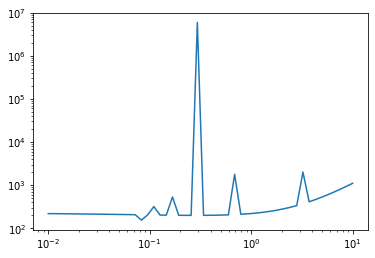

In [44]:
f0 = [(x['f']) for x in profiles[0]]
f0r = [np.exp(-(f0i-min(f0))) for f0i in f0]
plt.loglog(np.logspace(-2, 1, num=50).flatten(), f0)

In [45]:
list(zip(range(50), np.logspace(-2, 1, num=50),f0r))

[(0, 0.01, DM(1.88501e-28)),
 (1, 0.011513953993264475, DM(3.45313e-28)),
 (2, 0.013257113655901088, DM(6.60159e-28)),
 (3, 0.015264179671752334, DM(1.31867e-27)),
 (4, 0.017575106248547922, DM(2.75437e-27)),
 (5, 0.020235896477251575, DM(6.01749e-27)),
 (6, 0.023299518105153717, DM(1.37496e-26)),
 (7, 0.02682695795279726, DM(3.28221e-26)),
 (8, 0.030888435964774818, DM(8.16984e-26)),
 (9, 0.03556480306223128, DM(2.11563e-25)),
 (10, 0.040949150623804255, DM(5.67534e-25)),
 (11, 0.04714866363457394, DM(1.56941e-24)),
 (12, 0.054286754393238594, DM(4.44457e-24)),
 (13, 0.06250551925273973, DM(1.27887e-23)),
 (14, 0.07196856730011521, DM(3.70232e-23)),
 (15, 0.08286427728546843, DM(1)),
 (16, 0.09540954763499938, DM(3.01066e-22)),
 (17, 0.10985411419875583, DM(1.0042e-71)),
 (18, 0.12648552168552957, DM(2.12235e-21)),
 (19, 0.14563484775012436, DM(5.0895e-21)),
 (20, 0.16768329368110083, DM(3.61876e-164)),
 (21, 0.19306977288832497, DM(2.11001e-20)),
 (22, 0.22229964825261944, DM(3.43254

In [46]:
a0 = linterp(0.011513953993264475, 0.013257113655901088, 0.145754, 0.152931, 0.15)
a1 = linterp( 0.2559547922699536, 0.29470517025518095, 0.314558, 0.115928,  0.15)
a0idx = [1, 2]
a1idx = [23, 24]

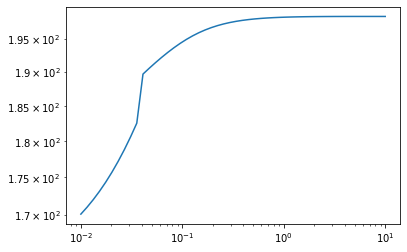

In [47]:
f1 = [(x['f']) for x in profiles[1]]
f1r = [np.exp(-(f1i-min(f1))) for f1i in f1]
plt.loglog(np.logspace(-2, 1, num=50).flatten(), f1)

In [48]:
list(zip(range(50), np.logspace(-2, 1, num=50),f1r))

[(0, 0.01, DM(1)),
 (1, 0.011513953993264475, DM(0.397917)),
 (2, 0.013257113655901088, DM(0.144188)),
 (3, 0.015264179671752334, DM(0.0470805)),
 (4, 0.017575106248547922, DM(0.0137151)),
 (5, 0.020235896477251575, DM(0.00353085)),
 (6, 0.023299518105153717, DM(0.000795989)),
 (7, 0.02682695795279726, DM(0.00015574)),
 (8, 0.030888435964774818, DM(2.60738e-05)),
 (9, 0.03556480306223128, DM(3.76127e-06)),
 (10, 0.040949150623804255, DM(3.03024e-09)),
 (11, 0.04714866363457394, DM(1.28472e-09)),
 (12, 0.054286754393238594, DM(5.61025e-10)),
 (13, 0.06250551925273973, DM(2.5339e-10)),
 (14, 0.07196856730011521, DM(1.19093e-10)),
 (15, 0.08286427728546843, DM(5.86302e-11)),
 (16, 0.09540954763499938, DM(3.04179e-11)),
 (17, 0.10985411419875583, DM(1.67103e-11)),
 (18, 0.12648552168552957, DM(9.74957e-12)),
 (19, 0.14563484775012436, DM(6.04688e-12)),
 (20, 0.16768329368110083, DM(3.98238e-12)),
 (21, 0.19306977288832497, DM(2.77697e-12)),
 (22, 0.22229964825261944, DM(2.04166e-12)),
 (23

In [49]:
b0 = linterp(0.6866488450043002, 0.7906043210907697,0.105638 , 0.158776, 0.15)
b1 = linterp(2.8117686979742306,2.8117686979742308, 0.149, 0.151, 0.15)
b0idx = [30, 31]
b1idx = [40, 40]

In [50]:
r0int = [b0/a0, b0/a1, b1/a0, b1/a1]
r0int

[61.651772808241006, 2.6849982819238467, 224.13053183340259, 9.761115787718639]

In [51]:
def gets0(pdx, idx):
    return float(getx(profiles[pdx][idx]['x'])[0][0])
def means0(pdx, idxs):
    return np.mean([gets0(pdx, idx) for idx in idxs])
s0 = [means0(0, a0idx), means0(0, a1idx), means0(1,b0idx), means0(1,b1idx)]
def crossmean(axs, bxs):
    s = []
    for a in axs:
        for b in bxs:
            s.append(np.mean([a, b]))
    return s
s0mean = crossmean(s0[2:], s0[:2])

In [52]:
def rinft(r0,s0):
    f = lambda y: y/s0 - np.exp(r0*(y-s0)/s0) 
    sinf = brentq(f, 0, s0-1) 
    return s0-sinf
[rinft(r0x, s0x) for r0x, s0x in zip(r0int, s0mean)]

[5174.4521589652895, 5137.104508065247, 5192.382786848921, 5637.602288002442]

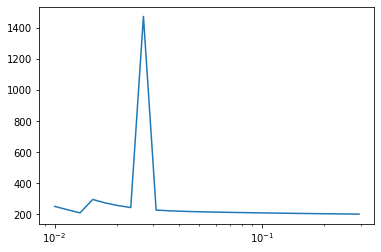

In [53]:
f2 = [(x['f']) for x in profiles[2]]
plt.semilogx(np.logspace(-2, 1, num=50).flatten()[:25], f2[:25])

In [54]:
def mod_seir(t, y, p):
    for i, yi in enumerate(y):
        if yi < 0:
            y[i] = 0 
    return seir(t, y, p)

In [117]:
from scipy.integrate import solve_ivp
tidx = 45
print(model.observation_times[tidx])
sol = solve_ivp(lambda t,y: mod_seir(t, y, getp(sols[idx]['x'])), [0, 150], [getx(sols[idx]['x'])[i][tidx] for i in range(4)], dense_output=True)
# solb = solve_ivp(lambda t,y: np.array(mod_seir(t, y, getp(sols[idx]['x']))), [0, -20], [getx(sols[idx]['x'])[i][tidx] for i in range(5)], method='BDF', dense_output=True)

86.18181818181819


In [118]:
[getx(sols[idx]['x'])[i][tidx] for i in range(4)]

[DM(3609.89), DM(413.357), DM(363.9), DM(1013.12)]

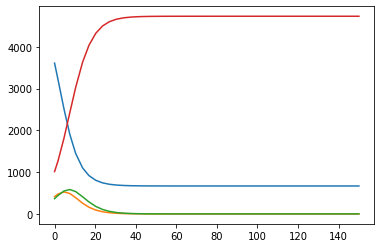

In [119]:
plt.plot(sol.t, sol.y[:,:].T)

In [120]:
model.observation_times[-1]

150.0

Text(0.5, 1.0, 'Number of Reported Cases (Prediction)')

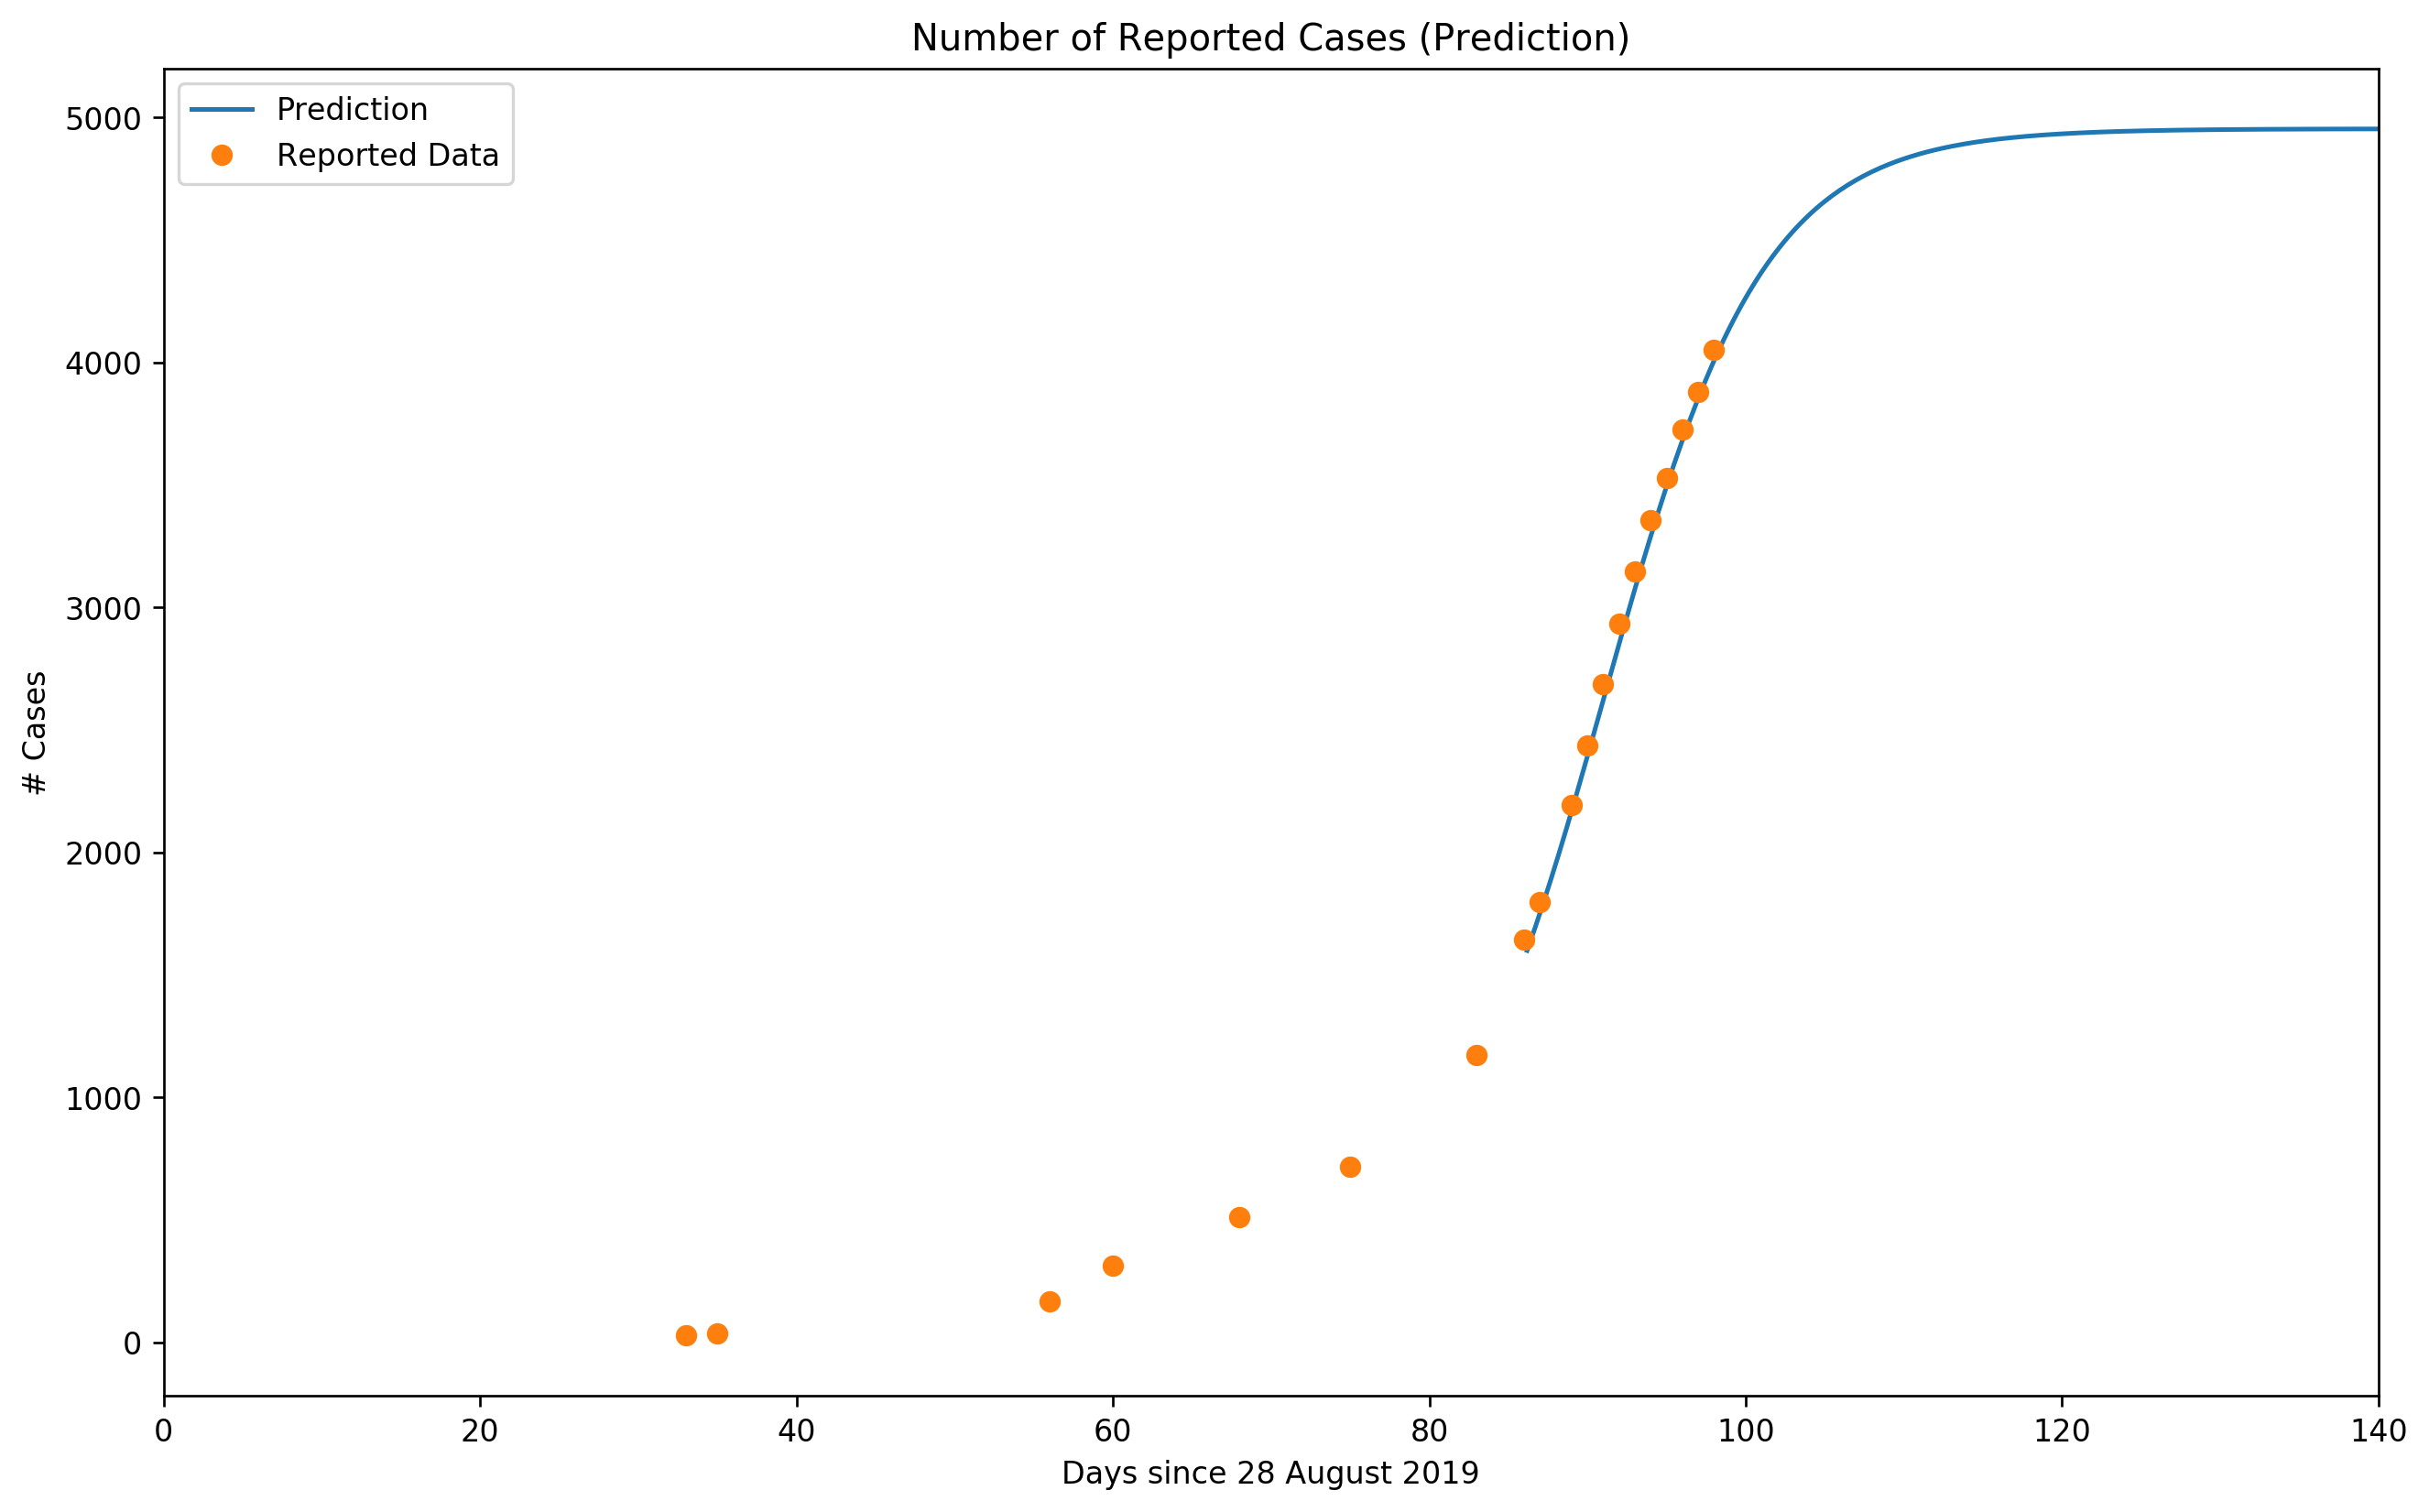

In [121]:
tfine = np.linspace(0, 150, 600)
# tbfine = np.linspace(0, -20, 20)
plt.figure(figsize=[13, 8], dpi=240)
# plt.plot(tbfine+model.observation_times[tidx], solb.sol(tbfine)[-1,:].T)
plt.plot(tfine+model.observation_times[tidx],  1600+getp(sols[idx]['x'])[2]*cumtrapz(sol.sol(tfine)[1,:], tfine, initial=0),)
plt.plot(additional_times, additional_cumdata, 'o')
plt.xlim(0, 140)
plt.legend(["Prediction", "Reported Data"])
plt.xlabel("Days since 28 August 2019")
plt.ylabel("# Cases")
plt.title("Number of Reported Cases (Prediction)")


In [122]:
rfin = sol.sol(tfine)[-1,-1]
rfin

4731.380671103677

In [123]:
ridx = np.argmin(np.abs(((1-(sol.sol(tfine)[-1,:])/rfin)*100) - 5))

In [124]:
tfine[ridx]

23.53923205342237

In [125]:
tfine[ridx]-(model.observation_times[-1]-model.observation_times[tidx])

-40.278949764759446

In [126]:
model.observation_times[-1]-model.observation_times[tidx]

63.81818181818181

In [127]:
historical_mortality = 0.02
current_mortality = 60/4052
print(historical_mortality, current_mortality)

0.02 0.014807502467917079


In [128]:
rfin*historical_mortality

94.62761342207354

In [129]:
rfin*current_mortality

70.05993096402285

In [90]:
prangeb = np.logspace(-6, 6, num=100)[idx:0:-1]
solsb = []
xguessb = sols[idx]['x'].toarray().flatten()
for p in prangeb:
    solve_opts = {
        'x0': xguessb,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': lbg,
        'ubg': ubg
    }
    print(f"Solving for p={p}")
    solsb.append(solver(**solve_opts))
    xguessb = np.array(solsb[-1]['x']).flatten()

Solving for p=0.6579332246575682
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1496
Number of nonzeros in Lagrangian Hessian.............:     1775

Total number of variables............................:       99
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      400
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      400
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg

  50  2.0052387e+02 0.00e+00 4.01e+01  -2.5 1.99e+00  -5.5 1.00e+00 1.00e+00f  1
  60  2.0045182e+02 0.00e+00 7.13e+01  -2.5 9.42e+00    -  1.00e+00 1.00e+00f  1
  70  2.0043894e+02 0.00e+00 1.29e+01  -2.5 3.90e+00    -  1.00e+00 1.00e+00f  1
  80  2.0037322e+02 0.00e+00 1.45e-01  -5.7 1.03e+04    -  8.99e-01 9.19e-01f  1
  90  2.0037054e+02 0.00e+00 1.01e-05  -8.6 3.08e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 92

                                   (scaled)                 (unscaled)
Objective...............:   2.0037054180123215e+02    2.0037054180123215e+02
Dual infeasibility......:   3.7789575341460901e-10    3.7789575341460901e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.3764093770031684e-09    1.3764093770031684e-09
Overall NLP error.......:   1.3764093770031684e-09    1.3764093770031684e-09


Number of objective funct

  30  1.9760709e+02 0.00e+00 1.16e+03  -1.0 1.12e+04    -  6.53e-01 1.25e-01f  4
  40  2.0228556e+02 0.00e+00 5.24e+03  -1.0 2.23e+04    -  1.00e+00 5.00e-01f  2
  50  2.0492285e+02 0.00e+00 1.17e+03  -1.0 5.41e+04    -  1.00e+00 2.32e-01f  3
  60  2.0579821e+02 0.00e+00 2.13e+03  -1.0 1.75e+04    -  1.00e+00 2.50e-01f  3
  70  2.0495420e+02 0.00e+00 1.16e+03  -1.0 2.09e+02    -  1.00e+00 5.00e-01f  2
  80  2.0230921e+02 0.00e+00 1.06e+03  -2.5 2.42e+01  -4.8 1.00e+00 1.00e+00f  1
  90  2.0179775e+02 0.00e+00 3.78e+01  -2.5 8.37e+02  -9.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.0066961e+02 0.00e+00 1.26e+02  -2.5 4.08e+03  -9.9 1.00e+00 1.00e+00f  1
 110  1.9988072e+02 0.00e+00 2.09e+00  -2.5 1.81e+02  -8.3 1.00e+00 1.00e+00f  1
 120  1.9551003e+02 0.00e+00 6.40e+01  -2.5 3.47e+03  -9.5 1.00e+00 1.00e+00f  1
 130  1.8540861e+02 0.00e+00 5.34e+02  -2.5 7.39e+02  -8.8 1.00e+00 1.00e+00f  1
 140  1.8241387e+02 0.00e+00

  90  1.8032784e+02 0.00e+00 4.82e+01  -2.5 2.81e+01  -5.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.7871465e+02 0.00e+00 1.49e+03  -2.5 7.04e+02  -8.4 1.00e+00 1.00e+00f  1
 110  1.7213861e+02 0.00e+00 2.76e+03  -2.5 5.55e+02  -9.6 1.00e+00 1.00e+00f  1
 120  1.7118043e+02 0.00e+00 3.93e+02  -2.5 2.13e+04    -  1.00e+00 1.00e+00f  1
 130  1.7099139e+02 0.00e+00 7.43e+02  -2.5 5.46e+02    -  1.00e+00 2.50e-01f  3
 140  1.7092604e+02 0.00e+00 6.13e+02  -2.5 2.49e+01    -  1.00e+00 5.00e-01f  2
 150  1.7091696e+02 0.00e+00 3.08e-01  -2.5 2.84e-01    -  1.00e+00 1.00e+00h  1
 160  1.7082735e+02 0.00e+00 7.13e+00  -5.7 1.10e+03    -  1.00e+00 8.04e-01f  1

Number of Iterations....: 166

                                   (scaled)                 (unscaled)
Objective...............:   1.7082733601264596e+02    1.7082733601264596e+02
Dual infeasibility......:   4.3939331979350748e-09    4.3939331979350748e-09
Constraint vio

  20  1.6989572e+02 0.00e+00 1.10e+03  -1.0 8.80e+03    -  7.45e-01 2.50e-01f  3
  30  1.6983809e+02 0.00e+00 6.16e+01  -1.0 3.11e+01  -6.0 1.00e+00 1.00e+00f  1
  40  1.6743591e+02 0.00e+00 1.17e+02  -1.0 1.02e+03  -8.4 1.00e+00 1.00e+00f  1
  50  1.6724930e+02 0.00e+00 3.63e+01  -1.0 5.27e+03    -  1.00e+00 5.00e-01f  2
  60  1.6423354e+02 0.00e+00 1.45e+03  -1.7 4.49e+03  -9.1 1.00e+00 5.00e-01f  2
  70  1.6274241e+02 0.00e+00 9.69e+02  -1.7 1.18e+03    -  1.00e+00 1.00e+00f  1
  80  1.6270493e+02 0.00e+00 8.31e+00  -1.7 4.89e+00    -  1.00e+00 1.00e+00h  1
  90  1.6231066e+02 0.00e+00 2.00e+00  -3.8 1.44e+03 -10.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.6177635e+02 0.00e+00 8.41e+00  -3.8 4.63e+03 -10.5 1.00e+00 1.00e+00f  1
 110  1.5936249e+02 0.00e+00 2.87e+02  -3.8 3.94e+03  -9.9 1.00e+00 1.00e+00f  1
 120  1.5768278e+02 0.00e+00 8.35e+02  -3.8 9.99e+01 -10.1 4.97e-01 1.25e-01f  4
 130  1.5751309e+02 0.00e+00

  30  1.5130089e+02 0.00e+00 1.69e+03  -1.7 2.21e+02  -8.3 1.00e+00 1.00e+00f  1
  40  1.5190497e+02 0.00e+00 5.39e+02  -1.7 8.74e+03    -  1.00e+00 5.00e-01f  2
  50  1.5204229e+02 0.00e+00 4.71e+02  -1.7 9.69e+03    -  1.00e+00 5.00e-01f  2
  60  1.5198099e+02 0.00e+00 1.93e+02  -1.7 4.36e+03    -  1.00e+00 5.00e-01f  2
  70  1.5156835e+02 0.00e+00 4.40e+02  -3.8 2.16e+03 -10.0 1.00e+00 2.50e-01f  3
  80  1.5134402e+02 0.00e+00 1.26e+01  -3.8 7.57e+03 -11.1 1.00e+00 5.00e-01f  2
  90  1.5111764e+02 0.00e+00 8.17e-02  -3.8 9.90e+01  -8.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.5042849e+02 0.00e+00 6.83e+01  -3.8 1.09e+03  -9.8 1.00e+00 1.00e+00f  1
 110  1.4959201e+02 0.00e+00 8.02e+02  -3.8 1.11e+04    -  1.00e+00 1.00e+00f  1
 120  1.4937819e+02 0.00e+00 8.41e+02  -3.8 2.43e+04    -  1.00e+00 5.00e-01f  2
 130  1.4936232e+02 0.00e+00 7.18e+00  -5.7 1.47e+04    -  8.89e-01 1.00e+00f  1

Number of Iterations....: 1

 140  1.4508161e+02 0.00e+00 8.07e+00  -2.5 1.10e+02  -6.9 1.00e+00 1.00e+00f  1
 150  1.4320694e+02 0.00e+00 1.91e+03  -2.5 3.04e+03  -9.0 1.00e+00 2.50e-01f  3
 160  1.4173562e+02 0.00e+00 8.04e+02  -2.5 7.18e+02  -9.2 1.00e+00 2.50e-01f  3
 170  1.4142539e+02 0.00e+00 1.24e+01  -2.5 1.26e+02 -10.4 1.00e+00 1.00e+00f  1
 180  1.4140310e+02 0.00e+00 3.44e-02  -2.5 1.75e+02    -  1.00e+00 1.00e+00h  1
 190  1.4131567e+02 0.00e+00 3.47e+00  -3.8 7.29e+03 -11.5 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.4114597e+02 0.00e+00 1.53e+02  -3.8 1.99e+03 -10.8 1.00e+00 1.00e+00f  1
 210  1.4086783e+02 0.00e+00 6.97e+01  -3.8 3.69e+03 -11.1 1.00e+00 1.00e+00f  1
 220  1.4073277e+02 0.00e+00 3.80e+01  -3.8 3.11e+02  -9.0 1.00e+00 1.00e+00f  1
 230  1.4071139e+02 0.00e+00 3.11e-06  -3.8 1.13e+00    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 239

                                   (scaled)                 (unscaled)
Object

 100  1.3634358e+02 0.00e+00 8.18e+01  -2.5 6.13e+02 -10.3 1.00e+00 1.00e+00f  1
 110  1.3553520e+02 0.00e+00 2.19e+03  -2.5 2.67e+03  -9.2 1.00e+00 1.25e-01f  4
 120  1.3420188e+02 0.00e+00 1.43e+02  -2.5 1.10e+03  -9.4 1.00e+00 5.00e-01f  2
 130  1.3315647e+02 0.00e+00 1.17e+03  -2.5 1.31e+03  -9.7 1.00e+00 1.00e+00f  1
 140  1.3302789e+02 0.00e+00 1.36e+00  -2.5 1.31e+03    -  1.00e+00 1.00e+00f  1
 150  1.3297251e+02 0.00e+00 3.87e+01  -3.8 4.00e+03 -10.9 1.00e+00 5.00e-01f  2
 160  1.3286746e+02 0.00e+00 7.35e-01  -3.8 9.91e+02 -10.2 1.00e+00 1.00e+00f  1
 170  1.3270801e+02 0.00e+00 8.54e-01  -3.8 6.71e+02 -10.5 1.00e+00 1.00e+00f  1
 180  1.3257149e+02 0.00e+00 7.10e+01  -3.8 1.13e+03  -9.4 1.00e+00 5.00e-01f  2
 190  1.3252273e+02 0.00e+00 1.93e-01  -3.8 1.32e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.3251393e+02 0.00e+00 9.75e-06  -8.6 2.13e+00    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 2

  40  1.3337658e+02 0.00e+00 4.97e+03  -1.0 7.43e+03    -  1.00e+00 2.50e-01f  3
  50  1.3344154e+02 0.00e+00 6.25e-01  -1.0 3.52e-01    -  1.00e+00 1.00e+00h  1
  60  1.3080783e+02 0.00e+00 8.13e+02  -1.7 1.52e+01    -  1.00e+00 1.00e+00f  1
  70  1.3054857e+02 0.00e+00 8.77e+02  -1.7 1.56e+01    -  1.00e+00 1.00e+00f  1
  80  1.3041871e+02 0.00e+00 3.33e+02  -1.7 9.45e+00    -  1.00e+00 1.00e+00f  1
  90  1.3037773e+02 0.00e+00 1.58e+01  -1.7 2.05e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.2986060e+02 0.00e+00 8.10e+02  -2.5 2.64e+04    -  8.20e-01 2.50e-01f  3
 110  1.2928781e+02 0.00e+00 1.05e+02  -2.5 1.19e+03 -10.1 1.00e+00 1.00e+00f  1
 120  1.2825864e+02 0.00e+00 4.33e+02  -2.5 5.88e+02  -9.0 1.00e+00 1.00e+00f  1
 130  1.2736434e+02 0.00e+00 3.24e+02  -2.5 2.25e+03 -10.1 1.00e+00 5.00e-01f  2
 140  1.2723247e+02 0.00e+00 1.35e+01  -2.5 9.67e+01  -9.8 1.00e+00 1.00e+00f  1
 150  1.2718611e+02 0.00e+00

  90  1.2314448e+02 0.00e+00 7.96e+00  -3.8 4.99e+03 -12.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.2307057e+02 0.00e+00 8.66e+01  -3.8 3.63e+02  -9.6 1.00e+00 1.00e+00f  1
 110  1.2301192e+02 0.00e+00 1.29e+01  -3.8 2.44e+04    -  1.00e+00 5.00e-01f  2
 120  1.2299068e+02 0.00e+00 2.41e+00  -5.7 5.06e+04    -  1.00e+00 6.42e-01f  1

Number of Iterations....: 129

                                   (scaled)                 (unscaled)
Objective...............:   1.2299044410730733e+02    1.2299044410730733e+02
Dual infeasibility......:   8.4504153768312497e-09    8.4504153768312497e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059036187533609e-09    2.5059036187533609e-09
Overall NLP error.......:   8.4504153768312497e-09    8.4504153768312497e-09


Number of objective function evaluations             = 267
Number of objective gradient evaluations      

  70  1.3003768e+02 0.00e+00 7.79e+02  -1.0 7.05e+00    -  1.00e+00 1.00e+00f  1
  80  1.3027832e+02 0.00e+00 4.02e+02  -1.0 9.48e+00    -  1.00e+00 5.00e-01f  2
  90  1.3031276e+02 0.00e+00 1.10e+04  -2.5 1.55e+03    -  7.62e-01 3.50e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.2702197e+02 0.00e+00 1.58e+03  -2.5 3.82e+04    -  1.00e+00 1.00e+00f  1
 110  1.2265139e+02 0.00e+00 1.64e+03  -2.5 1.52e+03  -9.5 1.00e+00 1.00e+00f  1
 120  1.2180396e+02 0.00e+00 2.02e+03  -2.5 2.55e+04    -  8.25e-01 5.00e-01f  2
 130  1.2080379e+02 0.00e+00 1.75e+03  -2.5 1.98e+03 -10.4 1.00e+00 2.50e-01f  3
 140  1.2064331e+02 0.00e+00 1.14e+03  -2.5 4.68e+01  -9.6 1.00e+00 1.00e+00f  1
 150  1.2058052e+02 0.00e+00 1.07e+03  -2.5 8.14e+01    -  1.00e+00 1.00e+00f  1
 160  1.2055460e+02 0.00e+00 3.31e+02  -2.5 7.09e+01    -  1.00e+00 5.00e-01f  2
 170  1.2054741e+02 0.00e+00 5.19e+00  -2.5 5.01e+00    -  1.00e+00 1.00e+00h  1
 180  1.2049855e+02 0.00e+00

  90  1.2670836e+02 0.00e+00 1.72e+03  -1.0 1.20e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.2695430e+02 0.00e+00 1.26e+03  -1.0 2.00e+01    -  1.00e+00 5.00e-01f  2
 110  1.2710645e+02 0.00e+00 1.01e+02  -1.0 2.96e+00    -  1.00e+00 1.00e+00f  1
 120  1.2519217e+02 0.00e+00 2.38e+03  -2.5 1.52e+03    -  1.00e+00 1.00e+00f  1
 130  1.2456257e+02 0.00e+00 6.85e+03  -2.5 3.62e+03 -10.8 1.00e+00 5.00e-01f  2
 140  1.2139982e+02 0.00e+00 1.76e+03  -2.5 2.97e+03  -9.6 2.47e-01 1.00e+00f  1
 150  1.2049156e+02 0.00e+00 1.37e+03  -2.5 4.95e+04 -11.1 1.00e+00 6.46e-02f  4
 160  1.1937526e+02 0.00e+00 2.58e+02  -2.5 5.60e+03 -10.4 1.00e+00 1.00e+00f  1
 170  1.1898817e+02 0.00e+00 1.24e+03  -2.5 1.50e+04    -  1.00e+00 5.00e-01f  2
 180  1.1887250e+02 0.00e+00 1.44e+03  -2.5 2.67e+02    -  1.00e+00 5.00e-01f  2
 190  1.1879604e+02 0.00e+00 1.19e+03  -2.5 1.23e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

  90  1.2430011e+02 0.00e+00 3.35e+03  -1.0 7.09e+01    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.2458517e+02 0.00e+00 2.48e+02  -1.0 5.27e+00    -  1.00e+00 1.00e+00f  1
 110  1.2487841e+02 0.00e+00 1.78e+03  -1.0 5.30e+01    -  1.00e+00 2.50e-01f  3
 120  1.2512089e+02 0.00e+00 6.19e+02  -1.0 8.35e+00    -  1.00e+00 1.00e+00f  1
 130  1.2530944e+02 0.00e+00 3.53e+02  -1.0 6.35e+00    -  1.00e+00 1.00e+00f  1
 140  1.2363673e+02 0.00e+00 1.02e+04  -2.5 5.56e+03    -  1.00e+00 7.81e-01f  1
 150  1.2298674e+02 0.00e+00 3.46e+03  -2.5 1.15e+02    -  1.00e+00 1.00e+00f  1
 160  1.2250606e+02 0.00e+00 1.89e+03  -2.5 6.80e+01    -  1.00e+00 1.00e+00f  1
 170  1.2212743e+02 0.00e+00 4.08e+03  -2.5 1.53e+02    -  1.00e+00 5.00e-01f  2
 180  1.2178110e+02 0.00e+00 2.43e+03  -2.5 5.97e+01    -  1.00e+00 1.00e+00f  1
 190  1.2150972e+02 0.00e+00 3.36e+03  -2.5 6.37e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 400  1.1695659e+02 0.00e+00 4.21e+00  -5.7 2.64e+03 -12.1 1.00e+00 1.00e+00f  1
 410  1.1694225e+02 0.00e+00 3.70e-02  -5.7 1.45e+02 -11.4 1.00e+00 1.00e+00f  1
 420  1.1693839e+02 0.00e+00 1.16e-09  -5.7 3.76e-01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 425

                                   (scaled)                 (unscaled)
Objective...............:   1.1693830344100463e+02    1.1693830344100463e+02
Dual infeasibility......:   5.2541600953462736e-09    5.2541600953462736e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5073423825362454e-09    2.5073423825362454e-09
Overall NLP error.......:   5.2541600953462736e-09    5.2541600953462736e-09


Number of objective function evaluations             = 765
Number of objective gradient evaluations             = 426
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 765
Number of equality constraint Jac

 100  1.2210364e+02 0.00e+00 4.07e+03  -1.0 2.37e+01    -  1.00e+00 1.00e+00f  1
 110  1.2240282e+02 0.00e+00 5.98e+03  -1.0 2.92e+01    -  1.00e+00 1.00e+00f  1
 120  1.2266854e+02 0.00e+00 1.07e+03  -1.0 1.28e+01    -  1.00e+00 1.00e+00f  1
 130  1.2296441e+02 0.00e+00 4.77e+02  -1.0 8.80e+00    -  1.00e+00 1.00e+00f  1
 140  1.2326609e+02 0.00e+00 2.03e+03  -1.0 1.80e+01    -  1.00e+00 1.00e+00f  1
 150  1.2354398e+02 0.00e+00 2.65e+03  -1.0 2.09e+01    -  1.00e+00 1.00e+00f  1
 160  1.2379319e+02 0.00e+00 1.38e+03  -1.0 5.39e+01    -  1.00e+00 2.50e-01f  3
 170  1.2402119e+02 0.00e+00 1.86e+03  -1.0 3.44e+01    -  1.00e+00 5.00e-01f  2
 180  1.2416004e+02 0.00e+00 2.06e+02  -1.0 6.00e+00    -  1.00e+00 1.00e+00f  1
 190  1.2230378e+02 0.00e+00 3.08e+03  -2.5 4.79e+03    -  1.00e+00 9.16e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.2179830e+02 0.00e+00 1.93e+04  -2.5 7.30e+01    -  1.00e+00 1.00e+00f  1
 210  1.2127125e+02 0.00e+00

 230  1.2133301e+02 0.00e+00 7.35e+03  -1.7 6.36e+01    -  1.00e+00 5.00e-01f  2
 240  1.2095724e+02 0.00e+00 8.14e+03  -1.7 3.70e+01    -  1.00e+00 1.00e+00f  1
 250  1.2063892e+02 0.00e+00 5.37e+03  -1.7 2.93e+01    -  1.00e+00 1.00e+00f  1
 260  1.2035628e+02 0.00e+00 8.29e+03  -1.7 3.57e+01    -  1.00e+00 1.00e+00f  1
 270  1.2009946e+02 0.00e+00 6.05e+02  -1.7 9.17e+00    -  1.00e+00 1.00e+00f  1
 280  1.1988286e+02 0.00e+00 3.60e+03  -1.7 2.25e+01    -  1.00e+00 1.00e+00f  1
 290  1.1969146e+02 0.00e+00 1.96e+03  -1.7 1.63e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  1.1952447e+02 0.00e+00 3.36e+03  -1.7 3.86e+01    -  1.00e+00 5.00e-01f  2
 310  1.1937814e+02 0.00e+00 1.09e+03  -1.7 1.16e+01    -  1.00e+00 1.00e+00f  1
 320  1.1925289e+02 0.00e+00 4.62e+02  -1.7 7.40e+00    -  1.00e+00 1.00e+00f  1
 330  1.1914083e+02 0.00e+00 2.40e+03  -1.7 6.46e+01    -  1.00e+00 2.50e-01f  3
 340  1.1904916e+02 0.00e+00

 370  1.1827126e+02 0.00e+00 1.32e+03  -2.5 6.82e+01    -  1.00e+00 1.00e+00f  1
 380  1.1819262e+02 0.00e+00 9.53e+02  -2.5 6.09e+01    -  1.00e+00 1.00e+00f  1
 390  1.1812942e+02 0.00e+00 1.42e+03  -2.5 1.28e+02    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  1.1807557e+02 0.00e+00 1.30e+03  -2.5 1.30e+02    -  1.00e+00 5.00e-01f  2
 410  1.1803154e+02 0.00e+00 1.63e+03  -2.5 3.30e+02    -  1.00e+00 2.50e-01f  3
 420  1.1799869e+02 0.00e+00 1.69e+03  -2.5 1.70e+02    -  1.00e+00 5.00e-01f  2
 430  1.1797266e+02 0.00e+00 1.43e+03  -2.5 3.21e+02    -  1.00e+00 2.50e-01f  3
 440  1.1795450e+02 0.00e+00 1.14e+02  -2.5 2.32e+01    -  1.00e+00 1.00e+00f  1
 450  1.1794277e+02 0.00e+00 2.16e+02  -2.5 3.21e+01    -  1.00e+00 1.00e+00f  1
 460  1.1793579e+02 0.00e+00 1.40e+02  -2.5 2.57e+01    -  1.00e+00 1.00e+00f  1
 470  1.1793294e+02 0.00e+00 2.48e+00  -2.5 3.44e+00    -  1.00e+00 1.00e+00h  1
 480  1.1786488e+02 0.00e+00

 350  1.1861160e+02 0.00e+00 8.38e+03  -2.5 5.17e+02    -  1.00e+00 5.00e-01f  2
 360  1.1845659e+02 0.00e+00 4.44e+03  -2.5 1.98e+02    -  1.00e+00 1.00e+00f  1
 370  1.1832683e+02 0.00e+00 3.14e+03  -2.5 2.88e+02    -  1.00e+00 5.00e-01f  2
 380  1.1820822e+02 0.00e+00 7.87e+02  -2.5 9.01e+01    -  1.00e+00 1.00e+00f  1
 390  1.1810489e+02 0.00e+00 7.65e+02  -2.5 8.15e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  1.1801264e+02 0.00e+00 7.54e+02  -2.5 8.08e+01    -  1.00e+00 1.00e+00f  1
 410  1.1793429e+02 0.00e+00 6.89e+02  -2.5 7.67e+01    -  1.00e+00 1.00e+00f  1
 420  1.1786628e+02 0.00e+00 1.40e+03  -2.5 3.77e+02    -  1.00e+00 2.50e-01f  3
 430  1.1780509e+02 0.00e+00 2.47e+02  -2.5 4.39e+01    -  1.00e+00 1.00e+00f  1
 440  1.1775585e+02 0.00e+00 1.04e+03  -2.5 9.36e+01    -  1.00e+00 1.00e+00f  1
 450  1.1771535e+02 0.00e+00 7.10e+02  -2.5 7.71e+01    -  1.00e+00 1.00e+00f  1
 460  1.1768241e+02 0.00e+00

 420  1.1852796e+02 0.00e+00 7.29e+02  -1.7 1.07e+01    -  1.00e+00 1.00e+00f  1
 430  1.1844909e+02 0.00e+00 2.33e+03  -1.7 1.90e+01    -  1.00e+00 1.00e+00f  1
 440  1.1838219e+02 0.00e+00 1.42e+03  -1.7 2.63e+01    -  1.00e+00 5.00e-01f  2
 450  1.1832332e+02 0.00e+00 9.35e+02  -1.7 1.98e+01    -  1.00e+00 5.00e-01f  2
 460  1.1826871e+02 0.00e+00 9.21e+02  -1.7 1.15e+01    -  1.00e+00 1.00e+00f  1
 470  1.1822409e+02 0.00e+00 6.43e+02  -1.7 3.50e+01    -  1.00e+00 2.50e-01f  3
 480  1.1818464e+02 0.00e+00 1.05e+03  -1.7 1.21e+01    -  1.00e+00 1.00e+00f  1
 490  1.1815572e+02 0.00e+00 3.89e+02  -1.7 7.29e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.1813378e+02 0.00e+00 1.66e+02  -1.7 8.57e+00    -  1.00e+00 5.00e-01h  2
 510  1.1811247e+02 0.00e+00 1.89e+03  -2.5 3.70e+03    -  8.27e-01 1.08e-02f  7
 520  1.1766914e+02 0.00e+00 2.18e+03  -2.5 1.24e+03    -  1.00e+00 1.00e+00f  1
 530  1.1753368e+02 0.00e+00

 380  1.1852223e+02 0.00e+00 1.90e+03  -2.5 1.13e+02 -10.7 1.00e+00 1.00e+00f  1
 390  1.1823445e+02 0.00e+00 9.30e+03  -2.5 2.39e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  1.1761177e+02 0.00e+00 2.94e+03  -2.5 5.51e+03 -12.2 1.00e+00 7.70e-01f  1
 410  1.1719066e+02 0.00e+00 9.20e+03  -2.5 1.42e+04    -  1.00e+00 1.00e+00f  1
 420  1.1703802e+02 0.00e+00 3.30e+03  -2.5 8.28e+01    -  1.00e+00 2.50e-01f  3
 430  1.1691596e+02 0.00e+00 4.54e+03  -2.5 1.03e+02    -  1.00e+00 2.50e-01f  3
 440  1.1680619e+02 0.00e+00 6.06e+03  -2.5 1.21e+02    -  1.00e+00 2.50e-01f  3
 450  1.1670280e+02 0.00e+00 4.40e+03  -2.5 2.61e+01    -  1.00e+00 1.00e+00f  1
 460  1.1661403e+02 0.00e+00 5.48e+03  -2.5 2.86e+01    -  1.00e+00 1.00e+00f  1
 470  1.1652920e+02 0.00e+00 1.15e+03  -2.5 1.28e+01    -  1.00e+00 1.00e+00f  1
 480  1.1645853e+02 0.00e+00 4.44e+03  -2.5 4.75e+01    -  1.00e+00 5.00e-01f  2
 490  1.1639060e+02 0.00e+00

 420  1.1729553e+02 0.00e+00 9.51e+03  -2.5 8.66e+01    -  1.00e+00 5.00e-01f  2
 430  1.1715062e+02 0.00e+00 4.64e+03  -2.5 3.11e+01    -  1.00e+00 1.00e+00f  1
 440  1.1701295e+02 0.00e+00 1.58e+03  -2.5 1.76e+01    -  1.00e+00 1.00e+00f  1
 450  1.1689679e+02 0.00e+00 4.05e+03  -2.5 2.79e+01    -  1.00e+00 1.00e+00f  1
 460  1.1678215e+02 0.00e+00 1.30e+03  -2.5 1.54e+01    -  1.00e+00 1.00e+00f  1
 470  1.1668273e+02 0.00e+00 2.76e+03  -2.5 2.21e+01    -  1.00e+00 1.00e+00f  1
 480  1.1658973e+02 0.00e+00 2.49e+03  -2.5 2.06e+01    -  1.00e+00 1.00e+00f  1
 490  1.1650425e+02 0.00e+00 1.69e+03  -2.5 1.66e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.1642592e+02 0.00e+00 4.84e+03  -2.5 1.07e+02    -  1.00e+00 2.50e-01f  3
 510  1.1635073e+02 0.00e+00 3.37e+03  -2.5 4.18e+01    -  1.00e+00 5.00e-01f  2
 520  1.1628478e+02 0.00e+00 3.18e+03  -2.5 8.22e+01    -  1.00e+00 2.50e-01f  3
 530  1.1622804e+02 0.00e+00

 360  1.1904007e+02 0.00e+00 2.14e+04  -2.5 8.08e+03 -10.8 1.00e+00 1.00e+00f  1
 370  1.1859456e+02 0.00e+00 3.40e+03  -2.5 3.32e+01    -  1.00e+00 1.00e+00f  1
 380  1.1834029e+02 0.00e+00 1.72e+04  -2.5 7.42e+01    -  1.00e+00 1.00e+00f  1
 390  1.1810609e+02 0.00e+00 1.56e+04  -2.5 6.90e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  1.1788846e+02 0.00e+00 6.19e+03  -2.5 4.23e+01    -  1.00e+00 1.00e+00f  1
 410  1.1769660e+02 0.00e+00 4.10e+03  -2.5 3.36e+01    -  1.00e+00 1.00e+00f  1
 420  1.1752094e+02 0.00e+00 2.62e+03  -2.5 2.62e+01    -  1.00e+00 1.00e+00f  1
 430  1.1736767e+02 0.00e+00 8.30e+03  -2.5 4.61e+01    -  1.00e+00 1.00e+00f  1
 440  1.1721983e+02 0.00e+00 2.66e+03  -2.5 2.54e+01    -  1.00e+00 1.00e+00f  1
 450  1.1708640e+02 0.00e+00 7.20e+03  -2.5 4.12e+01    -  1.00e+00 1.00e+00f  1
 460  1.1696082e+02 0.00e+00 4.51e+03  -2.5 3.19e+01    -  1.00e+00 1.00e+00f  1
 470  1.1684755e+02 0.00e+00

 240  1.2157459e+02 0.00e+00 8.71e+03  -1.0 5.88e+01    -  1.00e+00 1.00e+00f  1
 250  1.2181425e+02 0.00e+00 1.59e+04  -1.0 1.51e+02    -  1.00e+00 5.00e-01f  2
 260  1.2204337e+02 0.00e+00 1.58e+04  -1.0 8.18e+01    -  1.00e+00 1.00e+00f  1
 270  1.2225804e+02 0.00e+00 7.68e+03  -1.0 5.83e+01    -  1.00e+00 1.00e+00f  1
 280  1.2248830e+02 0.00e+00 1.79e+03  -1.0 2.90e+01    -  1.00e+00 1.00e+00f  1
 290  1.2271501e+02 0.00e+00 2.76e+03  -1.0 3.62e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  1.2292848e+02 0.00e+00 4.44e+03  -1.0 4.63e+01    -  1.00e+00 1.00e+00f  1
 310  1.2311934e+02 0.00e+00 5.54e+02  -1.0 1.67e+01    -  1.00e+00 1.00e+00f  1
 320  1.2327011e+02 0.00e+00 1.73e+03  -1.0 2.94e+01    -  1.00e+00 1.00e+00f  1
 330  1.2335158e+02 0.00e+00 1.05e+02  -1.0 7.26e+00    -  1.00e+00 1.00e+00h  1
 340  1.2138689e+02 0.00e+00 2.28e+03  -2.5 2.38e+01  -5.9 1.00e+00 1.00e+00f  1
 350  1.2072605e+02 0.00e+00

 100  1.1936939e+02 0.00e+00 4.45e+03  -1.0 3.62e+01    -  1.00e+00 1.00e+00f  1
 110  1.1944394e+02 0.00e+00 2.55e+03  -1.0 2.74e+01    -  1.00e+00 1.00e+00f  1
 120  1.1957324e+02 0.00e+00 1.74e+04  -1.0 1.33e+02    -  1.00e+00 5.00e-01f  2
 130  1.1963653e+02 0.00e+00 1.30e+04  -1.0 6.00e+01    -  1.00e+00 1.00e+00f  1
 140  1.1971351e+02 0.00e+00 8.53e+03  -1.0 4.85e+01    -  1.00e+00 1.00e+00f  1
 150  1.1981242e+02 0.00e+00 7.40e+03  -1.0 4.54e+01    -  1.00e+00 1.00e+00f  1
 160  1.1996738e+02 0.00e+00 2.23e+04  -1.0 7.87e+01    -  1.00e+00 1.00e+00f  1
 170  1.2003093e+02 0.00e+00 7.84e+03  -1.0 4.81e+01    -  1.00e+00 1.00e+00f  1
 180  1.2015883e+02 0.00e+00 1.24e+04  -1.0 6.18e+01    -  1.00e+00 1.00e+00f  1
 190  1.2027659e+02 0.00e+00 1.59e+03  -1.0 2.35e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.2042658e+02 0.00e+00 1.31e+04  -1.0 6.65e+01    -  1.00e+00 1.00e+00f  1
 210  1.2056432e+02 0.00e+00

  50  1.1902361e+02 0.00e+00 3.65e+03  -1.0 3.68e+01    -  1.00e+00 1.00e+00f  1
  60  1.1906849e+02 0.00e+00 4.80e+03  -1.0 4.21e+01    -  1.00e+00 1.00e+00f  1
  70  1.1914620e+02 0.00e+00 1.12e+04  -1.0 1.19e+02    -  1.00e+00 5.00e-01f  2
  80  1.1916937e+02 0.00e+00 4.41e+03  -1.0 4.03e+01    -  1.00e+00 1.00e+00f  1
  90  1.1927223e+02 0.00e+00 1.47e+04  -1.0 7.23e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1932587e+02 0.00e+00 1.38e+04  -1.0 2.66e+02    -  1.00e+00 2.50e-01f  3
 110  1.1936428e+02 0.00e+00 7.52e+03  -1.0 5.13e+01    -  1.00e+00 1.00e+00f  1
 120  1.1943382e+02 0.00e+00 6.16e+03  -1.0 4.61e+01    -  1.00e+00 1.00e+00f  1
 130  1.1950696e+02 0.00e+00 1.53e+03  -1.0 2.34e+01    -  1.00e+00 1.00e+00f  1
 140  1.1959113e+02 0.00e+00 6.40e+03  -1.0 4.63e+01    -  1.00e+00 1.00e+00f  1
 150  1.1971485e+02 0.00e+00 1.97e+04  -1.0 8.01e+01    -  1.00e+00 1.00e+00f  1
 160  1.1977213e+02 0.00e+00

1030  1.1534278e+02 0.00e+00 9.45e+01  -3.8 3.12e+00    -  1.00e+00 1.00e+00h  1
1040  1.1534159e+02 0.00e+00 2.13e+03  -5.7 1.16e+03    -  9.63e-01 1.00e+00f  1
1050  1.1531177e+02 0.00e+00 3.43e+01  -8.6 3.19e+03 -10.1 5.28e-02 1.00e+00f  1
1060  1.1524441e+02 0.00e+00 4.39e+02  -8.6 3.42e+03 -12.1 1.00e+00 1.00e+00f  1
1070  1.1524382e+02 0.00e+00 2.67e+01  -8.6 1.92e+03 -13.3 1.00e+00 1.00e+00f  1
1080  1.1524292e+02 0.00e+00 7.28e+01  -8.6 4.14e+02 -11.8 1.00e+00 1.00e+00f  1
1090  1.1523875e+02 0.00e+00 3.93e+00  -8.6 5.61e+03 -12.9 1.00e+00 2.19e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  1.1523638e+02 0.00e+00 2.95e+00  -8.6 2.91e+03 -13.1 7.91e-01 3.19e-01f  1
1110  1.1522771e+02 0.00e+00 7.77e+01  -8.6 1.57e+04 -12.5 1.66e-01 1.44e-01f  1
1120  1.1522408e+02 0.00e+00 7.13e+01  -8.6 3.73e+02 -13.5 1.00e+00 1.00e+00f  1
1130  1.1522395e+02 0.00e+00 2.05e-03  -8.6 1.55e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 1

 560  1.1881720e+02 0.00e+00 1.83e+03  -1.7 2.72e+01    -  1.00e+00 1.00e+00f  1
 570  1.1874767e+02 0.00e+00 4.25e+03  -1.7 4.11e+01    -  1.00e+00 1.00e+00f  1
 580  1.1868289e+02 0.00e+00 5.97e+03  -1.7 4.82e+01    -  1.00e+00 1.00e+00f  1
 590  1.1862158e+02 0.00e+00 4.31e+03  -1.7 4.04e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.1856819e+02 0.00e+00 3.19e+03  -1.7 6.21e+01    -  1.00e+00 5.00e-01f  2
 610  1.1851578e+02 0.00e+00 5.09e+03  -1.7 8.30e+01    -  1.00e+00 5.00e-01f  2
 620  1.1847031e+02 0.00e+00 4.11e+02  -1.7 1.19e+01    -  1.00e+00 1.00e+00f  1
 630  1.1842774e+02 0.00e+00 3.93e+02  -1.7 1.16e+01    -  1.00e+00 1.00e+00f  1
 640  1.1838771e+02 0.00e+00 1.99e+03  -1.7 4.75e+01    -  1.00e+00 5.00e-01f  2
 650  1.1835255e+02 0.00e+00 8.46e+02  -1.7 1.68e+01    -  1.00e+00 1.00e+00f  1
 660  1.1831939e+02 0.00e+00 6.33e+02  -1.7 1.44e+01    -  1.00e+00 1.00e+00f  1
 670  1.1828730e+02 0.00e+00

  30  1.1891416e+02 0.00e+00 6.62e+03  -1.0 1.05e+02    -  1.00e+00 5.00e-01f  2
  40  1.1893215e+02 0.00e+00 6.11e+03  -1.0 2.07e+02    -  1.00e+00 2.50e-01f  3
  50  1.1896229e+02 0.00e+00 6.46e+03  -1.0 1.01e+02    -  1.00e+00 5.00e-01f  2
  60  1.1899856e+02 0.00e+00 6.85e+03  -1.0 1.04e+02    -  1.00e+00 5.00e-01f  2
  70  1.1904514e+02 0.00e+00 8.57e+03  -1.0 1.22e+02    -  1.00e+00 5.00e-01f  2
  80  1.1909845e+02 0.00e+00 1.10e+04  -1.0 7.73e+01    -  1.00e+00 1.00e+00f  1
  90  1.1919189e+02 0.00e+00 1.89e+04  -1.0 1.00e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1921959e+02 0.00e+00 1.67e+04  -1.0 1.78e+02    -  1.00e+00 5.00e-01f  2
 110  1.1923540e+02 0.00e+00 9.76e+03  -1.0 2.58e+02    -  1.00e+00 2.50e-01f  3
 120  1.1928066e+02 0.00e+00 5.84e+03  -1.0 5.47e+01    -  1.00e+00 1.00e+00f  1
 130  1.1933427e+02 0.00e+00 1.95e+03  -1.0 3.18e+01    -  1.00e+00 1.00e+00f  1
 140  1.1939982e+02 0.00e+00

1150  1.1520065e+02 0.00e+00 5.70e+00  -8.6 5.42e+04 -13.8 1.00e+00 2.81e-01f  2
1160  1.1519588e+02 0.00e+00 4.26e+00  -8.6 4.90e+03 -12.7 5.75e-01 3.97e-02f  1
1170  1.1519110e+02 0.00e+00 3.62e+01  -8.6 9.88e+02 -11.2 1.00e+00 1.00e+00f  1
1180  1.1518833e+02 0.00e+00 3.83e+01  -8.6 6.92e+03    -  6.31e-02 9.78e-02f  1
1190  1.1518754e+02 0.00e+00 1.23e+01  -8.6 5.54e+04    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 1197

                                   (scaled)                 (unscaled)
Objective...............:   1.1518749437286557e+02    1.1518749437286557e+02
Dual infeasibility......:   2.4478510232217841e-09    2.4478510232217841e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5107484803088300e-09    2.5107484803088300e-09
Overall NLP error.......:   2.5107484803088300e-09    2.5107484803088300e-09


Number of objective fun

 630  1.1688097e+02 0.00e+00 1.09e+04  -2.5 1.29e+02    -  1.00e+00 5.00e-01f  2
 640  1.1681163e+02 0.00e+00 5.09e+03  -2.5 4.63e+01    -  1.00e+00 1.00e+00f  1
 650  1.1674706e+02 0.00e+00 2.95e+03  -2.5 3.45e+01    -  1.00e+00 1.00e+00f  1
 660  1.1668577e+02 0.00e+00 2.64e+03  -2.5 3.21e+01    -  1.00e+00 1.00e+00f  1
 670  1.1662780e+02 0.00e+00 2.97e+03  -2.5 3.36e+01    -  1.00e+00 1.00e+00f  1
 680  1.1657132e+02 0.00e+00 1.22e+03  -2.5 2.10e+01    -  1.00e+00 1.00e+00f  1
 690  1.1651799e+02 0.00e+00 2.41e+03  -2.5 2.93e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  1.1646754e+02 0.00e+00 4.35e+03  -2.5 3.89e+01    -  1.00e+00 1.00e+00f  1
 710  1.1641558e+02 0.00e+00 1.12e+03  -2.5 1.92e+01    -  1.00e+00 1.00e+00f  1
 720  1.1636819e+02 0.00e+00 1.69e+03  -2.5 2.34e+01    -  1.00e+00 1.00e+00f  1
 730  1.1632310e+02 0.00e+00 1.59e+03  -2.5 2.23e+01    -  1.00e+00 1.00e+00f  1
 740  1.1627848e+02 0.00e+00

  50  1.1895012e+02 0.00e+00 1.20e+04  -1.0 3.87e+02    -  1.00e+00 2.50e-01f  3
  60  1.1893656e+02 0.00e+00 2.56e+03  -1.0 4.74e+01    -  1.00e+00 1.00e+00f  1
  70  1.1897774e+02 0.00e+00 5.50e+03  -1.0 6.83e+01    -  1.00e+00 1.00e+00f  1
  80  1.1900937e+02 0.00e+00 2.52e+03  -1.0 4.62e+01    -  1.00e+00 1.00e+00f  1
  90  1.1905095e+02 0.00e+00 3.51e+03  -1.0 5.39e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1909337e+02 0.00e+00 4.19e+03  -1.0 5.83e+01    -  1.00e+00 1.00e+00f  1
 110  1.1915361e+02 0.00e+00 1.13e+04  -1.0 1.68e+02    -  1.00e+00 5.00e-01f  2
 120  1.1917932e+02 0.00e+00 1.80e+03  -1.0 3.77e+01    -  1.00e+00 1.00e+00f  1
 130  1.1922575e+02 0.00e+00 1.75e+03  -1.0 3.70e+01    -  1.00e+00 1.00e+00f  1
 140  1.1927638e+02 0.00e+00 6.00e+03  -1.0 6.58e+01    -  1.00e+00 1.00e+00f  1
 150  1.1932244e+02 0.00e+00 2.98e+03  -1.0 4.63e+01    -  1.00e+00 1.00e+00f  1
 160  1.1938455e+02 0.00e+00

1040  1.1552197e+02 0.00e+00 9.03e+02  -2.5 4.15e+01    -  1.00e+00 2.50e-01f  3
1050  1.1550340e+02 0.00e+00 7.38e+02  -2.5 1.10e+01    -  1.00e+00 1.00e+00f  1
1060  1.1548608e+02 0.00e+00 2.02e+03  -2.5 6.99e+01    -  1.00e+00 2.50e-01f  3
1070  1.1547005e+02 0.00e+00 1.48e+03  -2.5 2.86e+01    -  1.00e+00 5.00e-01f  2
1080  1.1545550e+02 0.00e+00 7.21e+02  -2.5 1.05e+01    -  1.00e+00 1.00e+00f  1
1090  1.1544157e+02 0.00e+00 2.11e+02  -2.5 5.59e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  1.1542941e+02 0.00e+00 9.30e+02  -2.5 4.41e+01    -  1.00e+00 2.50e-01f  3
1110  1.1541827e+02 0.00e+00 5.21e+02  -2.5 8.68e+00    -  1.00e+00 1.00e+00f  1
1120  1.1540810e+02 0.00e+00 6.49e+02  -2.5 9.61e+00    -  1.00e+00 1.00e+00f  1
1130  1.1539948e+02 0.00e+00 7.54e+02  -2.5 1.03e+01    -  1.00e+00 1.00e+00f  1
1140  1.1539203e+02 0.00e+00 6.80e+02  -2.5 9.67e+00    -  1.00e+00 1.00e+00f  1
1150  1.1538589e+02 0.00e+00

 360  1.2074912e+02 0.00e+00 2.37e+04  -1.0 1.39e+02    -  1.00e+00 1.00e+00f  1
 370  1.2089547e+02 0.00e+00 2.83e+04  -1.0 5.71e+02    -  1.00e+00 2.50e-01f  3
 380  1.2105067e+02 0.00e+00 3.37e+04  -1.0 1.73e+02    -  1.00e+00 1.00e+00f  1
 390  1.2122146e+02 0.00e+00 4.82e+04  -1.0 8.17e+02    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  1.2136998e+02 0.00e+00 3.09e+04  -1.0 3.16e+02    -  1.00e+00 5.00e-01f  2
 410  1.2156252e+02 0.00e+00 5.37e+04  -1.0 2.31e+02    -  1.00e+00 1.00e+00f  1
 420  1.2170563e+02 0.00e+00 1.83e+04  -1.0 2.28e+02    -  1.00e+00 5.00e-01f  2
 430  1.2188696e+02 0.00e+00 6.80e+03  -1.0 8.58e+01    -  1.00e+00 1.00e+00f  1
 440  1.2206914e+02 0.00e+00 2.39e+04  -1.0 1.62e+02    -  1.00e+00 1.00e+00f  1
 450  1.2222685e+02 0.00e+00 7.86e+03  -1.0 9.45e+01    -  1.00e+00 1.00e+00f  1
 460  1.2238227e+02 0.00e+00 4.47e+03  -1.0 7.21e+01    -  1.00e+00 1.00e+00f  1
 470  1.2251297e+02 0.00e+00

1330  1.1519106e+02 0.00e+00 3.78e+01  -3.8 2.01e+00    -  1.00e+00 1.00e+00f  1
1340  1.1519074e+02 0.00e+00 2.36e+01  -3.8 1.58e+00    -  1.00e+00 1.00e+00h  1
1350  1.1518787e+02 0.00e+00 1.00e+03  -5.7 1.42e+03    -  9.85e-01 6.39e-01f  1
1360  1.1518540e+02 0.00e+00 3.61e-02  -8.6 1.36e+04    -  6.01e-01 1.00e+00f  1
1370  1.1516756e+02 0.00e+00 6.70e+00  -8.6 2.94e+03 -12.8 8.02e-01 1.00e+00f  1
1380  1.1516675e+02 0.00e+00 6.63e+00  -8.6 1.15e+04 -14.0 1.00e+00 1.00e+00f  1
1390  1.1516209e+02 0.00e+00 3.67e+00  -8.6 3.10e+03 -12.5 2.33e-02 6.10e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  1.1516067e+02 0.00e+00 1.32e+01  -8.6 1.04e+03 -12.2 1.89e-01 3.05e-01f  1
1410  1.1515833e+02 0.00e+00 2.17e+01  -8.6 2.56e+02    -  1.00e+00 3.37e-01f  1
1420  1.1515725e+02 0.00e+00 2.00e+00  -8.6 7.09e+03    -  1.00e+00 8.06e-01f  1
1430  1.1515699e+02 0.00e+00 1.60e-03  -8.6 1.94e+04    -  1.00e+00 3.12e-02f  6

Number of Iterations....: 1

 670  1.1898879e+02 0.00e+00 1.20e+04  -1.7 9.68e+01    -  1.00e+00 1.00e+00f  1
 680  1.1893423e+02 0.00e+00 6.89e+03  -1.7 7.25e+01    -  1.00e+00 1.00e+00f  1
 690  1.1888397e+02 0.00e+00 4.62e+03  -1.7 5.87e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  1.1883717e+02 0.00e+00 5.35e+03  -1.7 6.24e+01    -  1.00e+00 1.00e+00f  1
 710  1.1879479e+02 0.00e+00 6.58e+03  -1.7 1.29e+02    -  1.00e+00 5.00e-01f  2
 720  1.1875727e+02 0.00e+00 3.19e+03  -1.7 4.72e+01    -  1.00e+00 1.00e+00f  1
 730  1.1872217e+02 0.00e+00 4.14e+03  -1.7 5.33e+01    -  1.00e+00 1.00e+00f  1
 740  1.1868950e+02 0.00e+00 5.49e+03  -1.7 2.37e+02    -  1.00e+00 2.50e-01f  3
 750  1.1866154e+02 0.00e+00 2.87e+03  -1.7 4.37e+01    -  1.00e+00 1.00e+00f  1
 760  1.1863566e+02 0.00e+00 2.96e+03  -1.7 1.69e+02    -  1.00e+00 2.50e-01f  3
 770  1.1861319e+02 0.00e+00 1.60e+03  -1.7 1.19e+02    -  1.00e+00 2.50e-01f  3
 780  1.1859344e+02 0.00e+00

  70  1.1890341e+02 0.00e+00 6.59e+03  -1.0 1.02e+02    -  1.00e+00 1.00e+00f  1
  80  1.1892647e+02 0.00e+00 2.61e+03  -1.0 6.42e+01    -  1.00e+00 1.00e+00f  1
  90  1.1896894e+02 0.00e+00 7.85e+03  -1.0 1.81e+02    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1899319e+02 0.00e+00 2.76e+03  -1.0 6.38e+01    -  1.00e+00 1.00e+00f  1
 110  1.1902961e+02 0.00e+00 4.87e+03  -1.0 8.28e+01    -  1.00e+00 1.00e+00f  1
 120  1.1907233e+02 0.00e+00 9.27e+03  -1.0 1.12e+02    -  1.00e+00 1.00e+00f  1
 130  1.1910377e+02 0.00e+00 7.27e+03  -1.0 9.62e+01    -  1.00e+00 1.00e+00f  1
 140  1.1913292e+02 0.00e+00 3.29e+03  -1.0 6.21e+01    -  1.00e+00 1.00e+00f  1
 150  1.1916806e+02 0.00e+00 5.34e+03  -1.0 7.75e+01    -  1.00e+00 1.00e+00f  1
 160  1.1920903e+02 0.00e+00 1.12e+04  -1.0 3.98e+02    -  1.00e+00 2.50e-01f  3
 170  1.1926928e+02 0.00e+00 2.19e+04  -1.0 1.55e+02    -  1.00e+00 1.00e+00f  1
 180  1.1926887e+02 0.00e+00

1030  1.1601600e+02 0.00e+00 2.64e+03  -2.5 2.88e+01    -  1.00e+00 1.00e+00f  1
1040  1.1599056e+02 0.00e+00 2.61e+03  -2.5 1.02e+02    -  1.00e+00 2.50e-01f  3
1050  1.1596464e+02 0.00e+00 1.52e+03  -2.5 2.13e+01    -  1.00e+00 1.00e+00f  1
1060  1.1593934e+02 0.00e+00 2.27e+03  -2.5 2.57e+01    -  1.00e+00 1.00e+00f  1
1070  1.1591386e+02 0.00e+00 6.61e+02  -2.5 1.36e+01    -  1.00e+00 1.00e+00f  1
1080  1.1589016e+02 0.00e+00 4.69e+03  -2.5 3.62e+01    -  1.00e+00 1.00e+00f  1
1090  1.1586570e+02 0.00e+00 2.27e+03  -2.5 4.29e+01    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  1.1584142e+02 0.00e+00 3.76e+03  -2.5 1.22e+02    -  1.00e+00 2.50e-01f  3
1110  1.1581708e+02 0.00e+00 1.27e+03  -2.5 1.82e+01    -  1.00e+00 1.00e+00f  1
1120  1.1579271e+02 0.00e+00 3.43e+02  -2.5 9.20e+00    -  1.00e+00 1.00e+00f  1
1130  1.1576908e+02 0.00e+00 6.68e+02  -2.5 1.28e+01    -  1.00e+00 1.00e+00f  1
1140  1.1574578e+02 0.00e+00

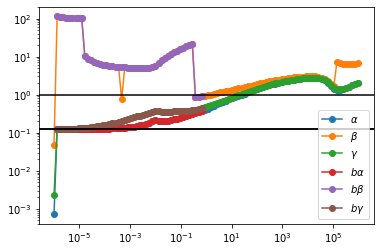

In [92]:
plt.plot(prange, [float(s['x'][-3]) for s in sols], 'o-', label=r'$\alpha$')
plt.plot(prange, [float(s['x'][-2]) for s in sols], 'o-', label=r'$\beta$')
plt.plot(prange, [float(s['x'][-1]) for s in sols], 'o-', label=r'$\gamma$')
plt.plot(prangeb, [float(s['x'][-3]) for s in solsb], 'o-', label=r'$b\alpha$')
plt.plot(prangeb, [float(s['x'][-2]) for s in solsb], 'o-', label=r'$b\beta$')
plt.plot(prangeb, [float(s['x'][-1]) for s in solsb], 'o-', label=r'$b\gamma$')
for q in p0:
    plt.axhline(q, color='k')
plt.xscale('log')
plt.yscale('log')
plt.legend()